# Imports and Paths

In [156]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numba as nb
from astropy.convolution import convolve
from scipy.ndimage import maximum_filter
from scipy.spatial.distance import cdist
import scipy.stats as sts
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [61]:
from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'
#importing plotting parameters
style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
#style = '/home/gleung/scripts/styles/bee-presentationtransparent.mplstyle'
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'

bg = 'white'
lcol = 'black'

In [3]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_latlon(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

In [43]:
dataPath = '/moonbow/gleung/satlcc/GFC_2021_v1.9/'
figPath = '/moonbow/gleung/satlcc-figures/deforest_effect/'
gfcPath = '/moonbow/gleung/satlcc/GFC_processing/'
gswPath = '/moonbow/gleung/satlcc/GSW_processing/'
modisPath = '/moonbow/gleung/satlcc/MODIS_terra_cf/'
anaPath = '/moonbow/gleung/satlcc/deforest_effect/'

for path in [figPath,anaPath]:
    if not os.path.isdir(path):
        os.mkdir(path)

# Merge GSW, GFC, MODIS data

In [9]:
alldata = []

for lat in [0,10,20,30]:
    for lon in [90,100,110,120,130]:
        print(lat,lon)
        lats = [round(l,3) for l in np.linspace(lat-10, lat, 1250+1)][1:]
        lons = [round(l,3) for l in np.linspace(lon, lon+10, 1250+1)][:-1]
        
        forest = np.load(f"{gfcPath}forestcover1km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.pkl.npy")

        data = []
        for yr in range(21):
            out = pd.DataFrame(forest[:,:,yr], 
                                         index=lats, 
                                         columns=lons).stack()
            out.name = f'Forest_{yr}'

            data.append(out)

        data = (pd.concat(data,axis=1))
        
        water = pd.DataFrame(np.load(f"{gswPath}watercover1km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.npy"),
                            index=lats,
                            columns=lons).stack()
        
        data['Water'] = water

        #include only pixels where surface water coverage is below 1%
        data = data[data.Water<0.01]
        
        alldata.append(data)
    
alldata = pd.concat(alldata,axis=0)

for yr in range(1,21):
    alldata[f"Loss_{yr}"] = -(alldata[f"Forest_{yr}"]-alldata[f"Forest_{yr-1}"])

0 90
0 100
0 110
0 120
0 130
10 90
10 100
10 110
10 120
10 130
20 90
20 100
20 110
20 120
20 130
30 90
30 100
30 110
30 120
30 130


In [243]:
yr = 2
prior = [f"Loss_{yr}" for yr in range(1,yr+1)]

sub = alldata[[f"Forest_0",
               f"Forest_{yr-1}",
               f"Forest_{yr}",
               f"Forest_{yr+1}"] + prior]

cf_pre = pd.read_pickle(f"{modisPath}/annual/20{str(yr-1).zfill(2)}.pkl")
cf_post = pd.read_pickle(f"{modisPath}/annual/20{str(yr+1).zfill(2)}.pkl")

cf_pre.index = [(round(lat_,3), round(lon_,3)) for lat_, lon_ in cf_pre.index]
cf_post.index = [(round(lat_,3), round(lon_,3)) for lat_, lon_ in cf_post.index]

sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
sub = sub.dropna()

sub['deltaCloud'] = sub[f"Cloud_{yr+1}"]-sub[f"Cloud_{yr-1}"]
prior = [f"Loss_{yr}" for yr in range(1,yr+1)]
sub['PriorLoss'] = sub[prior].sum(axis=1)

# Identify Control and Deforested Pixels (pivot + convolve)

## Calculate mean within 10 km radius

In [10]:
def mean_within_radius(var,sub,rad=10):
    data = sub.reset_index().pivot(index='level_0',columns='level_1',values=var)
    
    #because the grid is 1km resolution, a distance X km away is just X points
    kernel = np.fromfunction(lambda x, y: ((x-rad)**2 + (y-rad)**2 <= rad**2)*1, 
                             (2*rad+1, 2*rad+1), dtype=int).astype(np.uint8)
    kernel = kernel/np.sum(kernel)

    #doesn't handle nans well
    '''out = scipy.signal.convolve2d(data,kernel, mode='same',
                    boundary='fill',fillvalue=np.nan)'''
    
    #astropy is able to handle nan
    out = convolve(data,kernel,
                   boundary='fill',fill_value=np.nan, 
                   nan_treatment='interpolate',
                   preserve_nan=True)

    temp = pd.DataFrame(data.stack(dropna=False))
    temp.loc[:,f"{var}_10km"] = out.ravel()

    return(temp[f"{var}_10km"])

def max_within_radius(var,sub,rad=10):
    data = sub.reset_index().pivot(index='level_0',columns='level_1',values=var)
    
    #because the grid is 1km resolution, a distance X km away is just X points
    kernel = np.fromfunction(lambda x, y: ((x-rad)**2 + (y-rad)**2 <= rad**2)*1, 
                             (2*rad+1, 2*rad+1), dtype=int).astype(np.uint8)
     
    #substitute nan with 0
    out = maximum_filter(np.nan_to_num(data), footprint=kernel,
                    mode = 'nearest')

    temp = pd.DataFrame(data.stack(dropna=False))
    temp.loc[:,f"{var}_10km_max"] = out.ravel()

    return(temp[f"{var}_10km_max"])

In [1060]:
var = f"PriorLoss"
sub[f"{var}_10km"] = mean_within_radius(var,sub)
sub[f"{var}_10km_max"] = max_within_radius(var,sub)

var = f"Loss_{yr}"
sub[f"{var}_10km"] = mean_within_radius(var,sub)
sub[f"{var}_10km_max"] = max_within_radius(var,sub)

ctrl = sub[(sub.Forest_0>=0.9) &
         (sub.PriorLoss<=0.02) &
         (sub.PriorLoss_10km<=0.02)]
ctrlpts = np.array(list(ctrl.index.values))


KeyboardInterrupt



In [1136]:
ctrl_col = '#B1B1B1'
ass_col = '#B6664A'
def_col = '#87212C'

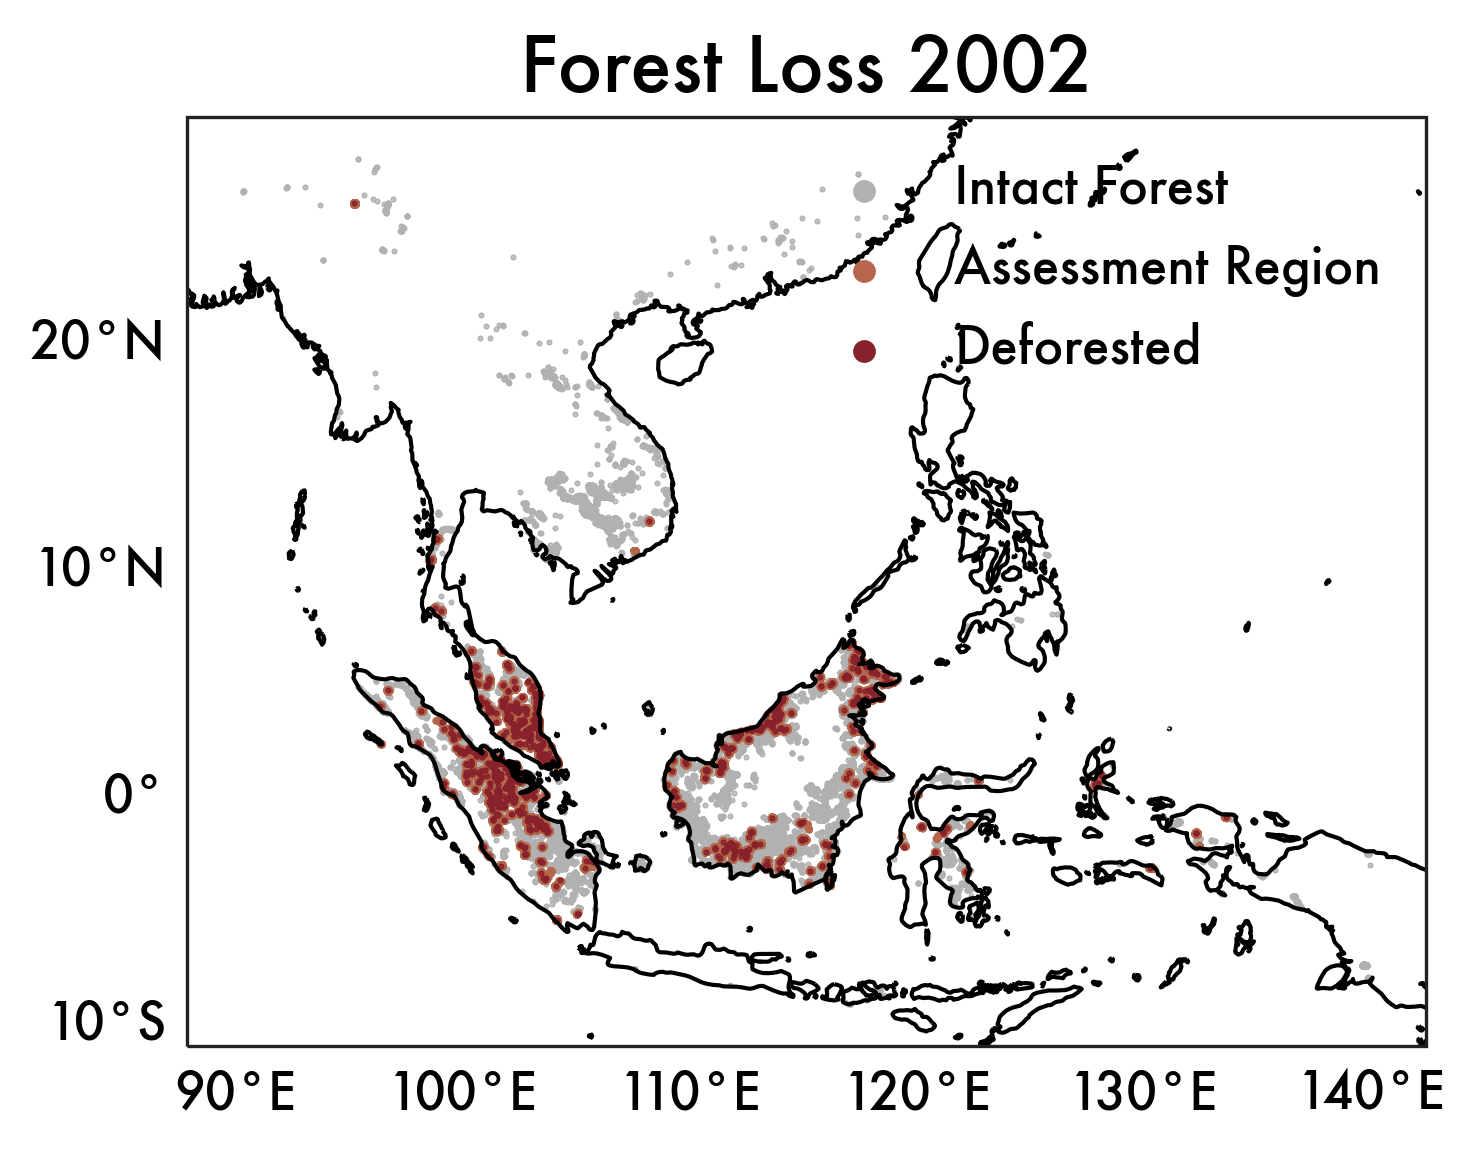

In [1137]:
fig, ax = plt.subplots(1,1,
                       figsize=(8,4),
                       subplot_kw={'projection':ccrs.PlateCarree()})

ax.scatter(ctrl.index.get_level_values(1),
            ctrl.index.get_level_values(0),
           s = 0.2,color=ctrl_col,
          label='Intact Forest')

ax.scatter(defo.index.get_level_values(1),
            defo.index.get_level_values(0),
           s = 0.2,color=ass_col,
          label = 'Assessment Region')

ax.scatter(defo[defo.Loss_2>=0.5].index.get_level_values(1),
            defo[defo.Loss_2>=0.5].index.get_level_values(0),
           s = 0.2,color=def_col,
          label = 'Deforested')

ax.legend(markerscale=10)
ax.set_title(f"Forest Loss 20{str(yr).zfill(2)}",loc='center')

ax.coastlines()
add_latlon(ax)

plt.savefig(f"{figPath}identify_deforest_pixels_2002.png",dpi=300)
plt.show()

In [1107]:
fig, axes = plt.subplots(1,3,
                       sharex=True,sharey=True,
                       figsize=(8,4),
                       subplot_kw={'projection':ccrs.PlateCarree()})

ax = axes[0]
plot = sub.reset_index().pivot(index='level_0',columns='level_1',values=f'Forest_{yr-1}')
plt.pcolormesh(plot.columns, 
              plot.index,
              plot.values,
              cmap=greens,
              vmin = 0,
              vmax = 1)
ax.set_title(f"Forest Cover 20{str(yr-1).zfill(2)}",loc='center')

ax = axes[1]
plot = sub.reset_index().pivot(index='level_0',columns='level_1',values=f'Forest_{yr}')
plt.pcolormesh(plot.columns, 
              plot.index,
              plot.values,
              cmap=greens,
              vmin = 0,
              vmax = 1)
ax.set_title(f"Forest Cover 20{str(yr).zfill(2)}",loc='center')

ax = axes[-1]
ax.scatter(ctrl.index.get_level_values(1),
            ctrl.index.get_level_values(0),
           s = 0.2,color='gray',
          label='Intact Forest')

ax.scatter(defo.index.get_level_values(1),
            defo.index.get_level_values(0),
           s = 0.2,color=red,
          label = 'Deforested')

ax.legend(markerscale=10)
ax.set_title(f"Forest Loss 20{str(yr).zfill(2)}",loc='center')

for ax in axes:
    ax.coastlines()
    add_latlon(ax)


plt.show()
plt.savefig(f"{figPath}identify_deforest_pixels_2.png",dpi=300)

KeyboardInterrupt: 

## Define assessment Pixels

In [898]:
defo = sub[sub[f"Loss_{yr}_10km_max"]>=0.5]

In [11]:
import itertools

def find_pixels_within_dist(loc,dist_thresh=10,res=0.008):
    lat, lon = loc
    latitudes = np.arange(lat-(dist_thresh*res), lat+(dist_thresh*res), res)
    latitudes = latitudes[(latitudes>=-9.992) & (latitudes<=30)]
    
    longitudes = np.arange(lon-(dist_thresh*res),lon+(dist_thresh*res), res)
    longitudes = longitudes[(longitudes>=90) & (longitudes<140)]
    
    pixels = [(round(lat_,3), round(lon_,3)) for lat_, lon_ in itertools.product(latitudes,longitudes)
          if (((lat_-lat)/res)**2 + ((lon_-lon)/res)**2) <= dist_thresh**2]
    
    return(pixels)

In [1161]:
plot = defo[(defo.index.get_level_values(0)>=5) & (defo.index.get_level_values(0)<=7) & 
           (defo.index.get_level_values(1)>=117) & (defo.index.get_level_values(1)<=120)]
plot_c = ctrl[(ctrl.index.get_level_values(0)>=5) & (ctrl.index.get_level_values(0)<=7) & 
           (ctrl.index.get_level_values(1)>=117) & (ctrl.index.get_level_values(1)<=120)]

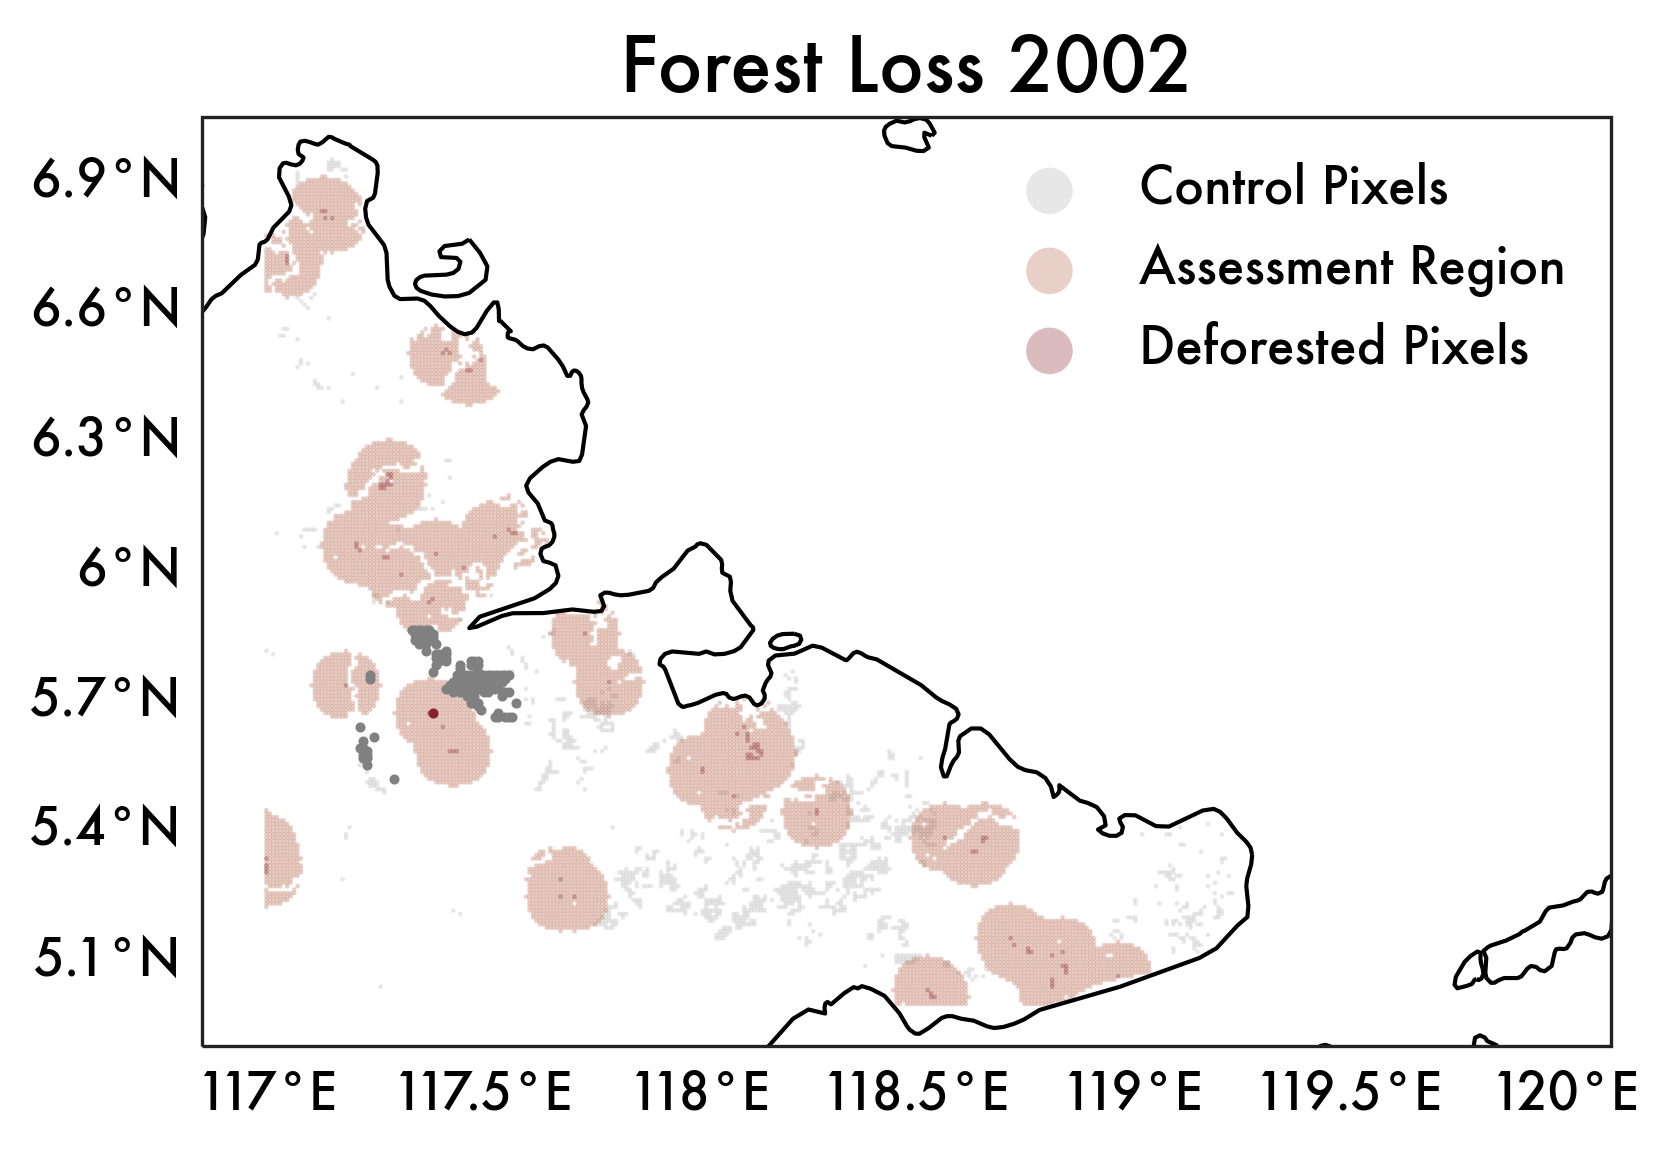

In [1180]:

fig, ax = plt.subplots(1,1,
                       figsize=(8,4),
                       subplot_kw={'projection':ccrs.PlateCarree()})

ax.scatter(plot_c.index.get_level_values(1),
            plot_c.index.get_level_values(0),
           s = 5,color=ctrl_col,marker='.',
          label = 'Control Pixels',alpha=0.3, edgecolor='None')

ax.scatter(plot.index.get_level_values(1),
            plot.index.get_level_values(0),
           s = 5,color=ass_col,marker='.',
          label = 'Assessment Region',alpha=0.3, edgecolor='None')

ax.scatter(plot[plot[f"Loss_{yr}"]>=0.5].index.get_level_values(1),
            plot[plot[f"Loss_{yr}"]>=0.5].index.get_level_values(0),
           s = 5,color=def_col,marker='.',
          label = 'Deforested Pixels',alpha=0.3, edgecolor='None')

i = 4000
ax.scatter(plot.index.get_level_values(1)[i],
           plot.index.get_level_values(0)[i],
           s = 2, color=def_col)

pos = plot.index[i]

dists = ((cdist(np.array(list(pos)).reshape(-1,1).T,
                          ctrlpts)))[0]/0.008

ctrl_sub=ctrl[dists<=25]

ax.scatter(ctrl_sub.index.get_level_values(1),
           ctrl_sub.index.get_level_values(0),
           s = 2, color='gray')


ax.legend(markerscale=10)
ax.set_title(f"Forest Loss 20{str(yr).zfill(2)}",loc='center')

ax.coastlines()
add_latlon(ax)

plt.savefig(f"{figPath}identify_deforest_pixels_2002-zoom.png",dpi=300)
plt.show()

In [945]:
#remove any deforested pixels which don't have an equivalent control pixel within 25km

defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),
                             ctrlpts).min(axis=1))/0.008
defo = defo[defo.MinDist_ctrl<=25] 

for pos in defo.index:
    dists = ((cdist(np.array(list(pos)).reshape(-1,1).T,
                              ctrlpts)))[0]/0.008

    ctrl_sub=ctrl[dists<=25]
    
    defo.loc[pos,'deltaCloud_ctrl'] = ctrl_sub.deltaCloud.mean()
    defo.loc[pos,'deltaCloud_ctrl_count'] = ctrl_sub.deltaCloud.count()
    defo.loc[pos,'deltaCloud_ctrl_std'] = ctrl_sub.deltaCloud.std()
    
defo['didCloud'] = defo.deltaCloud - defo.deltaCloud_ctrl    

/tmp/ipykernel_21867/3471760724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


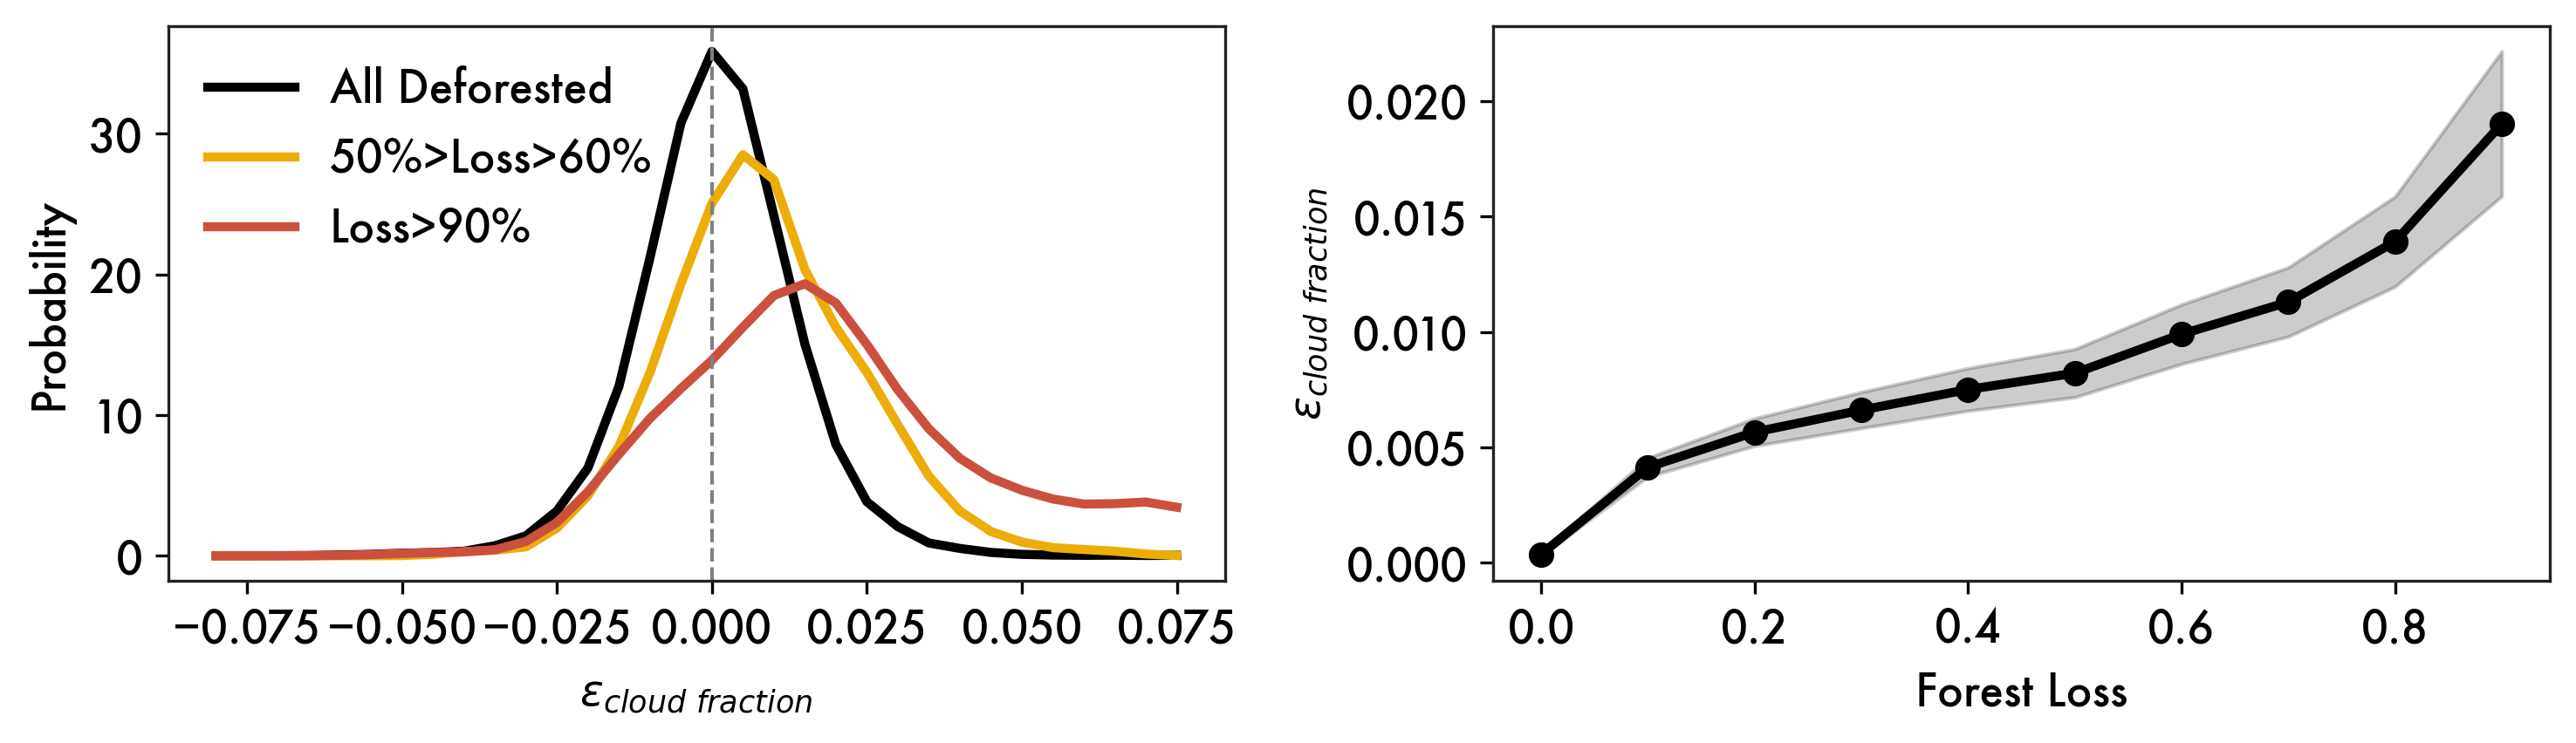

In [1271]:
import scipy.stats as sts


fig, axes = plt.subplots(1,2,figsize=(10,3))

x = np.arange(-0.08,0.08,0.005)

kde = sts.gaussian_kde(defo.didCloud)
axes[0].plot(x,kde.pdf(x),color='black', label = 'All Deforested')

kde = sts.gaussian_kde(defo[(defo.Loss_2>=0.5) & (defo.Loss_2<0.6)].didCloud)
axes[0].plot(x,kde.pdf(x),color=yellow, label = '50%>Loss>60%')

kde = sts.gaussian_kde(defo[defo.Loss_2>=0.9].didCloud)
axes[0].plot(x,kde.pdf(x),color=red, label = 'Loss>90%')

axes[0].legend(loc='upper left')

axes[0].set_ylabel('Probability')
axes[0].set_xlabel('$\epsilon_{cloud\ fraction}$')
axes[0].axvline(0,ls='--',lw=1,color='gray')

res = 0.1
plot = defo.groupby(res * (defo.Loss_2//res)).mean()
plot_std = defo.groupby(res * (defo.Loss_2//res)).std()
plot_cnt = defo.groupby(res * (defo.Loss_2//res)).count()

axes[1].plot(plot.index,plot.didCloud,marker='o',color='black')
axes[1].fill_between(plot.index,
                     plot.didCloud-(1.96*plot_std.didCloud)/np.sqrt(plot_cnt.didCloud),
                     plot.didCloud+(1.96*plot_std.didCloud)/np.sqrt(plot_cnt.didCloud),
                     color='black',alpha=0.2)
#axes[1].axhline(0,ls='--',lw=1)

axes[1].set_xlabel('Forest Loss')
axes[1].set_ylabel('$\epsilon_{cloud\ fraction}$')

plt.savefig(f"{figPath}estimate_effect_2002.png",dpi=300)
plt.show()

# Run on All

In [18]:
cfidx = [(round(lat_,3), round(lon_,3)) for lat_, lon_ in cf_pre.index]

In [248]:
import time

starttime = time.time()
alldf = pd.DataFrame()

for yr in range(2,20):
    #define all years prior to year in question 
    prior = [f"Loss_{yr}" for yr in range(1,yr+1)]

    #subset just the data needed, initial forest cover and loss all years prior to this year
    sub = alldata[[f"Forest_0"]+ prior]
    #calculate total prior loss before this year
    sub['PriorLoss'] = sub[prior].sum(axis=1)
    
    print('subset data',time.time()-starttime)
    
    #read cloud fraction from years before and after this year
    cf_pre = pd.read_pickle(f"{modisPath}/annual/20{str(yr-1).zfill(2)}.pkl")
    cf_post = pd.read_pickle(f"{modisPath}/annual/20{str(yr+1).zfill(2)}.pkl")
    print('cloud read',time.time()-starttime)
    
    cf_pre.index =  [(round(lat_,3), round(lon_,3)) for lat_, lon_ in cf_pre.index]
    cf_post.index =  [(round(lat_,3), round(lon_,3)) for lat_, lon_ in cf_post.index]
    print('cloud index',time.time()-starttime)
    
    sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
    sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
    sub['deltaCloud'] = sub[f"Cloud_{yr+1}"]-sub[f"Cloud_{yr-1}"]
    
    for mo in range(1,13):
        #read cloud fraction from years before and after this year
        cf_pre = pd.read_pickle(f"{modisPath}/{str(mo).zfill(2)}/20{str(yr-1).zfill(2)}.pkl")
        cf_post = pd.read_pickle(f"{modisPath}/{str(mo).zfill(2)}/20{str(yr+1).zfill(2)}.pkl")
        print('cloud read',time.time()-starttime)

        cf_pre.index =  [(round(lat_,3), round(lon_,3)) for lat_, lon_ in cf_pre.index]
        cf_post.index =  [(round(lat_,3), round(lon_,3)) for lat_, lon_ in cf_post.index]
        print('cloud index',time.time()-starttime)

        sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
        sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
        sub[f'deltaCloud{mo}'] = sub[f"Cloud{mo}_{yr+1}"]-sub[f"Cloud{mo}_{yr-1}"]
    
    print('cloud',time.time()-starttime)
    
    #calculating maximum and mean values within 10km radius of pixel
    var = f"PriorLoss"
    sub[f"{var}_10km"] = mean_within_radius(var,sub)
    sub[f"{var}_1km"] = mean_within_radius(var,sub,1)
    sub[f"{var}_2km"] = mean_within_radius(var,sub,2)
    sub[f"{var}_5km"] = mean_within_radius(var,sub,5)
    sub[f"{var}_10km_max"] = max_within_radius(var,sub)

    var = f"Loss_{yr}"
    sub[f"{var}_10km"] = mean_within_radius(var,sub)
    sub[f"{var}_1km"] = mean_within_radius(var,sub,1)
    sub[f"{var}_2km"] = mean_within_radius(var,sub,2)
    sub[f"{var}_5km"] = mean_within_radius(var,sub,5)
    sub[f"{var}_10km_max"] = max_within_radius(var,sub)

    print('spatial aggs',time.time()-starttime)
    
    #define population of possible control points: 
    #(1) high initial forest cover
    #(2) low forest loss prior to this year 
    #(3) low mean forest loss within 10km radius prior to this year
    ctrl = sub[(sub.Forest_0>=0.9) &
             (sub.PriorLoss<=0.02) &
             (sub.PriorLoss_10km<=0.02)]
    ctrlpts = np.array(list(ctrl.index.values))

    print('ctrl points',time.time()-starttime)
    
    #define population of assessment points:
    #any pixel within 10km of a pixel which lost 50% forest cover this year
    defo = sub[sub[f"Loss_{yr}_10km_max"]>=0.5]

    #remove any assessment pixels which don't have an equivalent control pixel within 25km
    #we can't pair them with control pixel so not included in final stats
    defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),
                                 ctrlpts).min(axis=1))/0.008
    defo = defo[defo.MinDist_ctrl<=25] 
    
    print('assessment points',time.time()-starttime)
    
    if len(defo)!=0:
        #for each remaining assessment pixel, find control points which are near enough (within 25km)
        #to serve as control for this pixel
        #take mean cloud cover
        for pos in defo.index:
            dists = ((cdist(np.array(list(pos)).reshape(-1,1).T,
                                      ctrlpts)))[0]/0.008

            ctrl_sub=ctrl[dists<=25]

            defo.loc[pos,'deltaCloud_ctrl'] = ctrl_sub.deltaCloud.mean()
            for mo in range(1,13):
                defo.loc[pos,f'deltaCloud{mo}_ctrl'] = ctrl_sub[f"deltaCloud{mo}"].mean()
            #defo.loc[pos,'deltaCloud_ctrl_count'] = ctrl_sub.deltaCloud.count()
            #defo.loc[pos,'deltaCloud_ctrl_std'] = ctrl_sub.deltaCloud.std()

        #this is episilon/difference-in-differences metric
        defo['didCloud'] = defo.deltaCloud - defo.deltaCloud_ctrl 
        for mo in range(1,13):
            defo[f'didCloud{mo}'] = defo[f'deltaCloud{mo}'] -  defo[f'deltaCloud{mo}_ctrl']
            
        print('calc eps',time.time()-starttime)

        #just save needed columns
        defo = defo[np.append([f'Loss_{yr}','PriorLoss',
                               f'Loss_{yr}_1km','PriorLoss_1km',
                               f'Loss_{yr}_2km','PriorLoss_2km',
                               f'Loss_{yr}_5km','PriorLoss_5km',
                               f'Loss_{yr}_10km','PriorLoss_10km',
                    'deltaCloud','deltaCloud_ctrl','didCloud'],[f"didCloud{mo}" for mo in range(1,13)])]
        defo['year'] = yr

        #add this to full list
        alldf = pd.concat([alldf,defo])

        print(yr,time.time()-starttime)

/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 0.4495820999145508
cloud read 16.886244297027588
cloud index 158.04103636741638


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 327.19412064552307
cloud index 455.32497096061707


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 654.9672286510468
cloud index 793.4163391590118


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 982.2944693565369
cloud index 1108.34477186203


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 1310.8164694309235
cloud index 1443.9480600357056


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 1638.4020204544067
cloud index 1768.0315873622894


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 1970.87407040596
cloud index 2105.7904200553894


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 2305.2478070259094
cloud index 2434.5808951854706


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 2633.77051115036
cloud index 2768.639633178711


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 2959.9003977775574
cloud index 3082.7728278636932


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 3282.2125129699707
cloud index 3404.7223467826843


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 3604.2112197875977
cloud index 3729.166255235672


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 3901.3995232582092
cloud index 4019.413177728653


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])


cloud 4181.76407122612
spatial aggs 4494.002735614777
ctrl points 4499.861124277115


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 4775.565464258194
calc eps 5216.267121076584
2 5216.347686052322


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 5216.7162408828735
cloud read 5227.122193574905
cloud index 5345.573038339615


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 5492.656286716461
cloud index 5607.400957584381


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 5754.979511022568
cloud index 5870.242763519287


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 6021.802768468857
cloud index 6133.391826868057


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 6294.898461103439
cloud index 6417.22265291214


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 6547.472632408142
cloud index 6661.300373315811


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 6819.904681444168
cloud index 6935.559092760086


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 7107.191104650497
cloud index 7226.6819796562195


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 7396.579569101334
cloud index 7509.3536059856415


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 7676.034390211105
cloud index 7795.799530982971


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 7972.7523193359375
cloud index 8092.125445604324


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 8263.380818605423
cloud index 8383.83867764473


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 8550.96965789795
cloud index 8674.980386257172
cloud 8836.888131856918
spatial aggs 9134.106452703476
ctrl points 9138.933924913406


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 9180.805267333984
calc eps 9452.128465890884
3 9452.21924829483


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 9452.6161506176
cloud read 9463.243984222412
cloud index 9577.776061534882


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 9746.180277585983
cloud index 9864.674522638321


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 10034.269010305405
cloud index 10159.492397546768


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 10321.93850851059
cloud index 10440.246652841568


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 10597.565366983414
cloud index 10719.096287727356


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 10893.545305013657
cloud index 11017.799489498138


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 11189.797684907913
cloud index 11307.838715314865


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 11482.029435396194
cloud index 11608.821159124374


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 11788.948115348816
cloud index 11915.096768856049


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 12090.49270772934
cloud index 12213.867239713669


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 12391.89628458023
cloud index 12522.053158283234


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 12710.690188884735
cloud index 12843.255753278732


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])


cloud read 13029.864760398865
cloud index 13151.79423069954
cloud 13309.65356206894
spatial aggs 13644.18645620346
ctrl points 13649.600257635117


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 13698.065721035004
calc eps 14095.442421197891
4 14095.69773197174


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 14096.603691339493
cloud read 14107.644171476364
cloud index 14231.995546102524


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 14398.01893043518
cloud index 14528.510302782059


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 14701.211328268051
cloud index 14826.094624757767


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 15001.309386730194
cloud index 15130.09441781044


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 15297.09624171257
cloud index 15427.566317081451


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 15606.630605697632
cloud index 15733.854761600494


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 15914.94179725647
cloud index 16052.646269321442


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 16224.378161430359
cloud index 16355.022372961044


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 16536.055423736572
cloud index 16676.899720668793


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 16879.023465633392
cloud index 17004.276920318604


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 17193.63613986969
cloud index 17328.760302066803


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 17525.443242788315
cloud index 17654.246420145035


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])


cloud read 17845.52854371071
cloud index 17975.5675907135
cloud 18169.18817257881
spatial aggs 18502.227427005768
ctrl points 18508.471435308456


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 18542.939764261246
calc eps 18852.37083673477
5 18852.54563140869


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 18853.289867401123
cloud read 18863.69866514206
cloud index 19005.68979716301


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 19212.386325597763
cloud index 19340.494218587875


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 19522.257409334183
cloud index 19660.934981822968


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 19864.571340560913
cloud index 19997.817202568054


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 20203.084623336792
cloud index 20336.29867386818


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 20535.806482315063
cloud index 20667.795080900192


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 20863.064492464066
cloud index 20992.699074029922


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 21173.409303188324
cloud index 21313.076773881912


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 21505.240679502487
cloud index 21647.252551555634


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 21845.829773664474
cloud index 21983.693828582764


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 22177.53489780426
cloud index 22310.359522104263


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 22507.27560019493
cloud index 22637.990016698837
cloud read 22831.61119747162
cloud index 22975.615395784378
cloud 23146.475291013718
spatial aggs 23473.767290592194
ctrl points 23480.03209543228


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 23515.104212522507
calc eps 23811.022342443466
6 23811.236712932587


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 23812.127049684525
cloud read 23823.02690720558
cloud index 23939.58526778221


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 24120.510474920273
cloud index 24268.360975265503


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 24459.58701658249
cloud index 24585.271786928177


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 24776.189133644104
cloud index 24907.563762426376


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 25084.134116888046
cloud index 25223.464828968048


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 25410.7090446949
cloud index 25547.640942573547


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 25737.594970941544
cloud index 25883.636933088303


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 26088.457867622375
cloud index 26227.093666553497


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 26417.609580755234
cloud index 26556.702228546143


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 26758.21622776985
cloud index 26892.221104621887


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 27086.398469924927
cloud index 27224.343794822693


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])


cloud read 27407.40124297142
cloud index 27547.258412837982
cloud read 27733.86009478569
cloud index 27873.565917491913
cloud 28063.122250556946
spatial aggs 28388.47831106186
ctrl points 28396.488396167755


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 28417.96634411812
calc eps 28669.531263828278
7 28669.955038785934


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 28670.991149187088
cloud read 28677.618221998215
cloud index 28827.132603645325


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 29010.72371816635
cloud index 29158.917683839798


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 29351.077131986618
cloud index 29478.934527397156


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 29666.094623565674
cloud index 29805.58872127533


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 30000.916719675064
cloud index 30149.507680416107


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 30328.190329790115
cloud index 30462.033745765686


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 30655.71153140068
cloud index 30763.774488449097


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 30930.43688416481
cloud index 31072.71944975853


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 31271.34033679962
cloud index 31402.297572135925


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 31603.388773918152
cloud index 31739.69162130356


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 31943.770340442657
cloud index 32069.032898187637


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])


cloud read 32258.81188249588
cloud index 32387.119425296783
cloud read 32575.408046722412
cloud index 32709.69070148468
cloud 32899.517812252045
spatial aggs 33227.5319416523
ctrl points 33233.445610523224


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 33248.29708981514
calc eps 33446.2852973938
8 33446.83933234215


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 33448.26080083847
cloud read 33458.052612781525
cloud index 33596.135045051575


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 33772.8501431942
cloud index 33903.157076358795


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 34077.21411895752
cloud index 34229.015751600266


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 34401.67361950874
cloud index 34533.52110123634


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 34706.25639081001
cloud index 34843.50039482117


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 35019.88386011124
cloud index 35158.47919988632


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 35338.81043624878
cloud index 35474.657022476196


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 35649.6782515049
cloud index 35784.334488630295


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 35947.09096813202
cloud index 36079.87561035156


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 36251.31371498108
cloud index 36391.748167037964


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 36559.23155093193
cloud index 36689.60068130493
cloud read 36871.47604084015
cloud index 37013.10990905762
cloud read 37188.894126176834
cloud index 37319.30776953697
cloud 37483.25957417488
spatial aggs 37799.66391968727
ctrl points 37805.32968211174


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 37815.22911643982
calc eps 37995.88133096695
9 37996.54142355919


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 37997.88850426674
cloud read 38008.64142155647
cloud index 38146.34002876282


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 38341.57236075401
cloud index 38469.0142686367


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 38657.90546655655
cloud index 38783.284450769424


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 38974.08133625984
cloud index 39099.81950902939


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 39299.186081171036
cloud index 39426.65203332901


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 39620.845759153366
cloud index 39759.654876470566


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 39952.14969563484
cloud index 40086.763548612595


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 40267.086193323135
cloud index 40394.80398225784


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 40589.164798498154
cloud index 40717.92423462868


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 40902.28524470329
cloud index 41029.87744688988


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])


cloud read 41214.39540743828
cloud index 41344.00661492348
cloud read 41530.22717165947
cloud index 41663.29344844818
cloud read 41841.649329185486
cloud index 41983.46577358246
cloud 42161.831978321075
spatial aggs 42497.06782126427
ctrl points 42503.259489536285


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 42511.26609945297
calc eps 42651.60335230827
10 42652.574880599976


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 42654.76895427704
cloud read 42665.5508890152
cloud index 42802.63398885727


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 42983.65761399269
cloud index 43111.00718975067


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 43275.52564620972
cloud index 43421.98155808449


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 43585.20214962959
cloud index 43712.77327179909


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 43889.39140224457
cloud index 44036.0453414917


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 44219.02404141426
cloud index 44344.91447710991


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 44525.2700650692
cloud index 44667.59436702728


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 44841.3240275383
cloud index 44974.07185411453


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 45150.07673573494
cloud index 45280.09605526924


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 45447.6690557003
cloud index 45584.27522444725


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])


cloud read 45756.92205429077
cloud index 45895.48557806015
cloud read 46072.11179614067
cloud index 46194.54068350792
cloud read 46374.25011062622
cloud index 46511.53128361702
cloud 46681.3073284626
spatial aggs 46987.36432790756
ctrl points 46994.15475988388


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 47000.61462545395
calc eps 47109.6131837368
11 47110.35918498039


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 47112.17355513573
cloud read 47124.18491268158
cloud index 47254.39357972145


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 47425.131006002426
cloud index 47566.53899741173


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 47742.95963835716
cloud index 47876.92416405678


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 48063.669520139694
cloud index 48194.26162171364


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 48376.85417532921
cloud index 48525.23437714577


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 48685.227102041245
cloud index 48805.89539718628


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 48980.94702768326
cloud index 49111.549325466156


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 49295.09108042717
cloud index 49431.77402186394


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 49607.8999376297
cloud index 49744.510726451874


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 49915.114916324615
cloud index 50052.72183299065
cloud read 50226.4504032135
cloud index 50362.06327676773
cloud read 50537.283682346344
cloud index 50663.41437983513
cloud read 50835.66269302368
cloud index 50968.39454746246
cloud 51129.9058907032
spatial aggs 51462.0098092556
ctrl points 51468.79123353958


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 51472.82469844818
calc eps 51563.56935381889
12 51564.65271067619


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 51566.6116335392
cloud read 51577.30725455284
cloud index 51717.834079265594


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 51897.313786268234
cloud index 52031.83992648125


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 52206.01050758362
cloud index 52332.87232732773


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 52515.89892578125
cloud index 52653.31585407257


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 52832.149903059006
cloud index 52964.63355612755


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 53142.69754076004
cloud index 53297.59256386757


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 53473.91227865219
cloud index 53600.69168925285


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 53778.3503639698
cloud index 53921.15010857582


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 54101.079887866974
cloud index 54232.06263637543


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])


cloud read 54397.240874528885
cloud index 54533.34488916397
cloud read 54714.5022251606
cloud index 54858.66419696808
cloud read 55039.08091020584
cloud index 55170.927426576614
cloud read 55343.176271915436
cloud index 55482.85310268402
cloud 55654.447803258896
spatial aggs 56001.05794286728
ctrl points 56007.51437497139


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 56009.69658493996
calc eps 56057.85051751137
13 56059.025514125824


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 56061.22887849808
cloud read 56075.387266397476
cloud index 56213.58702349663


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 56376.368515491486
cloud index 56517.04894685745


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 56689.51156306267
cloud index 56810.05743122101


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 56989.951521635056
cloud index 57129.47150063515


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 57310.73340845108
cloud index 57435.39505028725


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 57609.809885025024
cloud index 57744.40274953842


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 57925.78249549866
cloud index 58059.11861371994


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 58230.32213830948
cloud index 58365.87708544731


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 58533.27218222618
cloud index 58670.001373529434


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])


cloud read 58845.37551212311
cloud index 58988.32703614235
cloud read 59166.334608078
cloud index 59302.72876906395
cloud read 59481.18339776993
cloud index 59620.12569689751
cloud read 59790.580109119415
cloud index 59918.74479532242
cloud 60086.57077717781
spatial aggs 60424.90693497658
ctrl points 60431.26267576218


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 60436.27844572067
calc eps 60473.23114871979
14 60474.38476920128


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 60476.118911504745
cloud read 60483.220317840576
cloud index 60625.68434095383


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 60809.40523457527
cloud index 60935.28250861168


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 61110.62495088577
cloud index 61251.83669090271


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 61429.463612794876
cloud index 61572.83119034767


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 61749.06296086311
cloud index 61878.14526247978


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 62058.65733170509
cloud index 62193.08151054382


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 62365.04876303673
cloud index 62499.862678050995


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 62674.328292131424
cloud index 62808.22466015816


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 62987.03091216087
cloud index 63106.70785856247
cloud read 63283.56102633476
cloud index 63421.56496787071
cloud read 63605.53422522545
cloud index 63743.28859591484
cloud read 63918.72672247887
cloud index 64051.73563027382
cloud read 64223.23793339729
cloud index 64355.42961978912
cloud 64531.73545241356
spatial aggs 64885.72469496727
ctrl points 64891.93314099312


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 64893.0218834877
calc eps 64915.33465242386
15 64916.65197467804


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 64918.99005031586
cloud read 64931.11474633217
cloud index 65071.86624741554


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 65248.79708456993
cloud index 65385.897525310516


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 65560.46664786339
cloud index 65689.48728847504


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 65873.56084275246
cloud index 66014.04628682137


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 66189.85178804398
cloud index 66318.50582933426


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 66484.7524137497
cloud index 66635.8172647953


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 66798.74805927277
cloud index 66923.99288773537


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 67096.1719686985
cloud index 67241.98040938377


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])


cloud read 67410.3753194809
cloud index 67549.93397593498
cloud read 67724.9905591011
cloud index 67851.94258999825
cloud read 68037.20471262932
cloud index 68164.5448589325
cloud read 68338.65372943878
cloud index 68472.97488975525
cloud read 68643.8028345108
cloud index 68771.67939329147
cloud 68935.84686112404
spatial aggs 69288.6281042099
ctrl points 69292.3971965313


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 69293.16744709015
calc eps 69309.14235544205
16 69310.63573861122


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 69313.75774765015
cloud read 69324.26876282692
cloud index 69455.80004310608


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 69636.46987867355
cloud index 69767.24486112595


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 69945.23624491692
cloud index 70073.88732790947


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 70228.8392829895
cloud index 70360.73499059677


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 70530.61046242714
cloud index 70653.81901788712


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 70828.61997818947
cloud index 70949.17068433762


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 71106.83535766602
cloud index 71246.83396244049


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 71429.39031338692
cloud index 71564.03857636452


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])


cloud read 71741.04510903358
cloud index 71869.01125264168
cloud read 72041.16889119148
cloud index 72163.87385082245
cloud read 72339.20626139641
cloud index 72462.58102059364
cloud read 72632.55560207367
cloud index 72769.61017131805
cloud read 72947.92810869217
cloud index 73087.61555242538
cloud 73248.69019913673
spatial aggs 73604.66975212097
ctrl points 73611.51760673523


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 73612.05566716194
calc eps 73618.68391609192
17 73620.95322704315


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 73624.33379387856
cloud read 73638.67138409615
cloud index 73774.39026355743


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 73956.46688270569
cloud index 74093.74510931969


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 74271.0029990673
cloud index 74404.81104493141


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 74583.42981433868
cloud index 74721.8040189743


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 74899.70599269867
cloud index 75042.34012937546


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 75227.9578909874
cloud index 75362.29514336586


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 75548.47624778748
cloud index 75687.96138834953


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 75870.15425682068
cloud index 76001.1399936676
cloud read 76180.33410191536
cloud index 76311.78891253471
cloud read 76490.09585261345
cloud index 76626.19146347046
cloud read 76816.52929282188
cloud index 76953.96175789833
cloud read 77144.70262789726
cloud index 77281.40427494049
cloud read 77471.3885319233
cloud index 77603.59019899368
cloud 77760.64098525047
spatial aggs 78106.90466952324
ctrl points 78111.51447629929


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


assessment points 78111.93361377716
calc eps 78116.10857892036
18 78117.80704760551


/tmp/ipykernel_3684/3998020098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['PriorLoss'] = sub[prior].sum(axis=1)


subset data 78120.22093844414
cloud read 78125.87723970413
cloud index 78267.58181762695


/tmp/ipykernel_3684/3998020098.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

cloud read 78454.6712346077
cloud index 78592.94929480553


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 78783.86333155632
cloud index 78909.88989853859


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 79103.32019281387
cloud index 79245.15691542625


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 79432.15494680405
cloud index 79565.56408596039


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 79744.72702789307
cloud index 79877.54782342911


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])
/tmp/ipykernel_3684/3998020098.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

cloud read 80060.96527314186
cloud index 80197.50364255905


/tmp/ipykernel_3684/3998020098.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr-1}"] = sub.index.map(cf_pre['mean'])
/tmp/ipykernel_3684/3998020098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[f"Cloud{mo}_{yr+1}"] = sub.index.map(cf_post['mean'])


cloud read 80368.03196978569
cloud index 80507.54749631882
cloud read 80696.25254917145
cloud index 80830.05806875229
cloud read 81013.23627114296
cloud index 81165.83034157753
cloud read 81354.73215270042
cloud index 81490.87252736092
cloud read 81680.54589819908
cloud index 81818.25424313545
cloud read 82005.69625067711
cloud index 82149.13196873665
cloud 82313.06357240677
spatial aggs 82660.88787674904
ctrl points 82668.82408642769
assessment points 82669.39065933228


/tmp/ipykernel_3684/3998020098.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defo['MinDist_ctrl'] = (cdist(np.array(list(defo.index.values)),


In [228]:
print(alldf.columns)

Index(['Loss_2', 'Loss_2_10km', 'PriorLoss', 'PriorLoss_10km', 'deltaCloud',
       'deltaCloud_ctrl', 'didCloud', 'didCloud1', 'didCloud2', 'didCloud3',
       'didCloud4', 'didCloud5', 'didCloud6', 'didCloud7', 'didCloud8',
       'didCloud9', 'didCloud10', 'didCloud11', 'didCloud12', 'year', 'Loss_3',
       'Loss_3_10km', 'Loss_4', 'Loss_4_10km', 'Loss_5', 'Loss_5_10km',
       'Loss_6', 'Loss_6_10km', 'Loss_7', 'Loss_7_10km', 'Loss_8',
       'Loss_8_10km', 'Loss_9', 'Loss_9_10km', 'Loss_10', 'Loss_10_10km',
       'Loss_11', 'Loss_11_10km', 'Loss_12', 'Loss_12_10km', 'Loss_13',
       'Loss_13_10km', 'Loss_14', 'Loss_14_10km', 'Loss_15', 'Loss_15_10km',
       'Loss_16', 'Loss_16_10km', 'Loss_17', 'Loss_17_10km', 'Loss_18',
       'Loss_18_10km', 'Loss', 'Loss_10km'],
      dtype='object')


In [249]:
alldf['Loss'] = alldf[[f'Loss_{yr}' for yr in range(2,19)]].mean(axis=1)
alldf['Loss_1km'] = alldf[[f'Loss_{yr}_1km' for yr in range(2,19)]].mean(axis=1)
alldf['Loss_2km'] = alldf[[f'Loss_{yr}_2km' for yr in range(2,19)]].mean(axis=1)
alldf['Loss_5km'] = alldf[[f'Loss_{yr}_5km' for yr in range(2,19)]].mean(axis=1)
alldf['Loss_10km'] = alldf[[f'Loss_{yr}_10km' for yr in range(2,19)]].mean(axis=1)

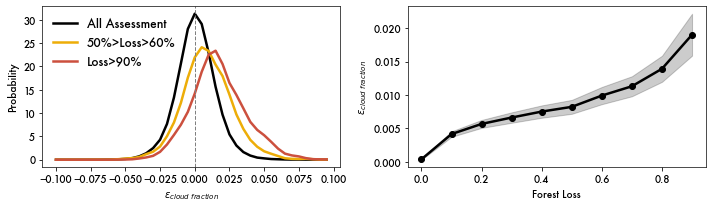

In [23]:
import scipy.stats as sts

fig, axes = plt.subplots(1,2,figsize=(10,3))

x = np.arange(-0.1,0.1,0.005)

kde = sts.gaussian_kde(alldf.didCloud)
axes[0].plot(x,kde.pdf(x),color='black', label = 'All Assessment')

kde = sts.gaussian_kde(alldf[(alldf.Loss>=0.5) & (alldf.Loss<0.6)].didCloud)
axes[0].plot(x,kde.pdf(x),color=yellow, label = '50%>Loss>60%')

kde = sts.gaussian_kde(alldf[alldf.Loss>=0.9].didCloud)
axes[0].plot(x,kde.pdf(x),color=red, label = 'Loss>90%')

axes[0].legend(loc='upper left')

axes[0].set_ylabel('Probability')
axes[0].set_xlabel('$\epsilon_{cloud\ fraction}$')
axes[0].axvline(0,ls='--',lw=1,color='gray')

res = 0.1
plot = alldf.groupby(res * (alldf.Loss_2//res)).mean()
plot_std = alldf.groupby(res * (alldf.Loss_2//res)).std()
plot_cnt = alldf.groupby(res * (alldf.Loss_2//res)).count()

axes[1].plot(plot.index,plot.didCloud,marker='o',color='black')
axes[1].fill_between(plot.index,
                     plot.didCloud-(1.96*plot_std.didCloud)/np.sqrt(plot_cnt.didCloud),
                     plot.didCloud+(1.96*plot_std.didCloud)/np.sqrt(plot_cnt.didCloud),
                     color='black',alpha=0.2)
#axes[1].axhline(0,ls='--',lw=1)

axes[1].set_xlabel('Forest Loss')
axes[1].set_ylabel('$\epsilon_{cloud\ fraction}$')

plt.savefig(f"{figPath}estimate_effect_allyrs.png",dpi=300)
plt.show()

In [241]:
print(alldf.dropna())

Empty DataFrame
Columns: [Loss_2, Loss_2_10km, PriorLoss, PriorLoss_10km, deltaCloud, deltaCloud_ctrl, didCloud, didCloud1, didCloud2, didCloud3, didCloud4, didCloud5, didCloud6, didCloud7, didCloud8, didCloud9, didCloud10, didCloud11, didCloud12, year, Loss_3, Loss_3_10km, Loss_4, Loss_4_10km, Loss_5, Loss_5_10km, Loss_6, Loss_6_10km, Loss_7, Loss_7_10km, Loss_8, Loss_8_10km, Loss_9, Loss_9_10km, Loss_10, Loss_10_10km, Loss_11, Loss_11_10km, Loss_12, Loss_12_10km, Loss_13, Loss_13_10km, Loss_14, Loss_14_10km, Loss_15, Loss_15_10km, Loss_16, Loss_16_10km, Loss_17, Loss_17_10km, Loss_18, Loss_18_10km, Loss, Loss_10km]
Index: []

[0 rows x 54 columns]


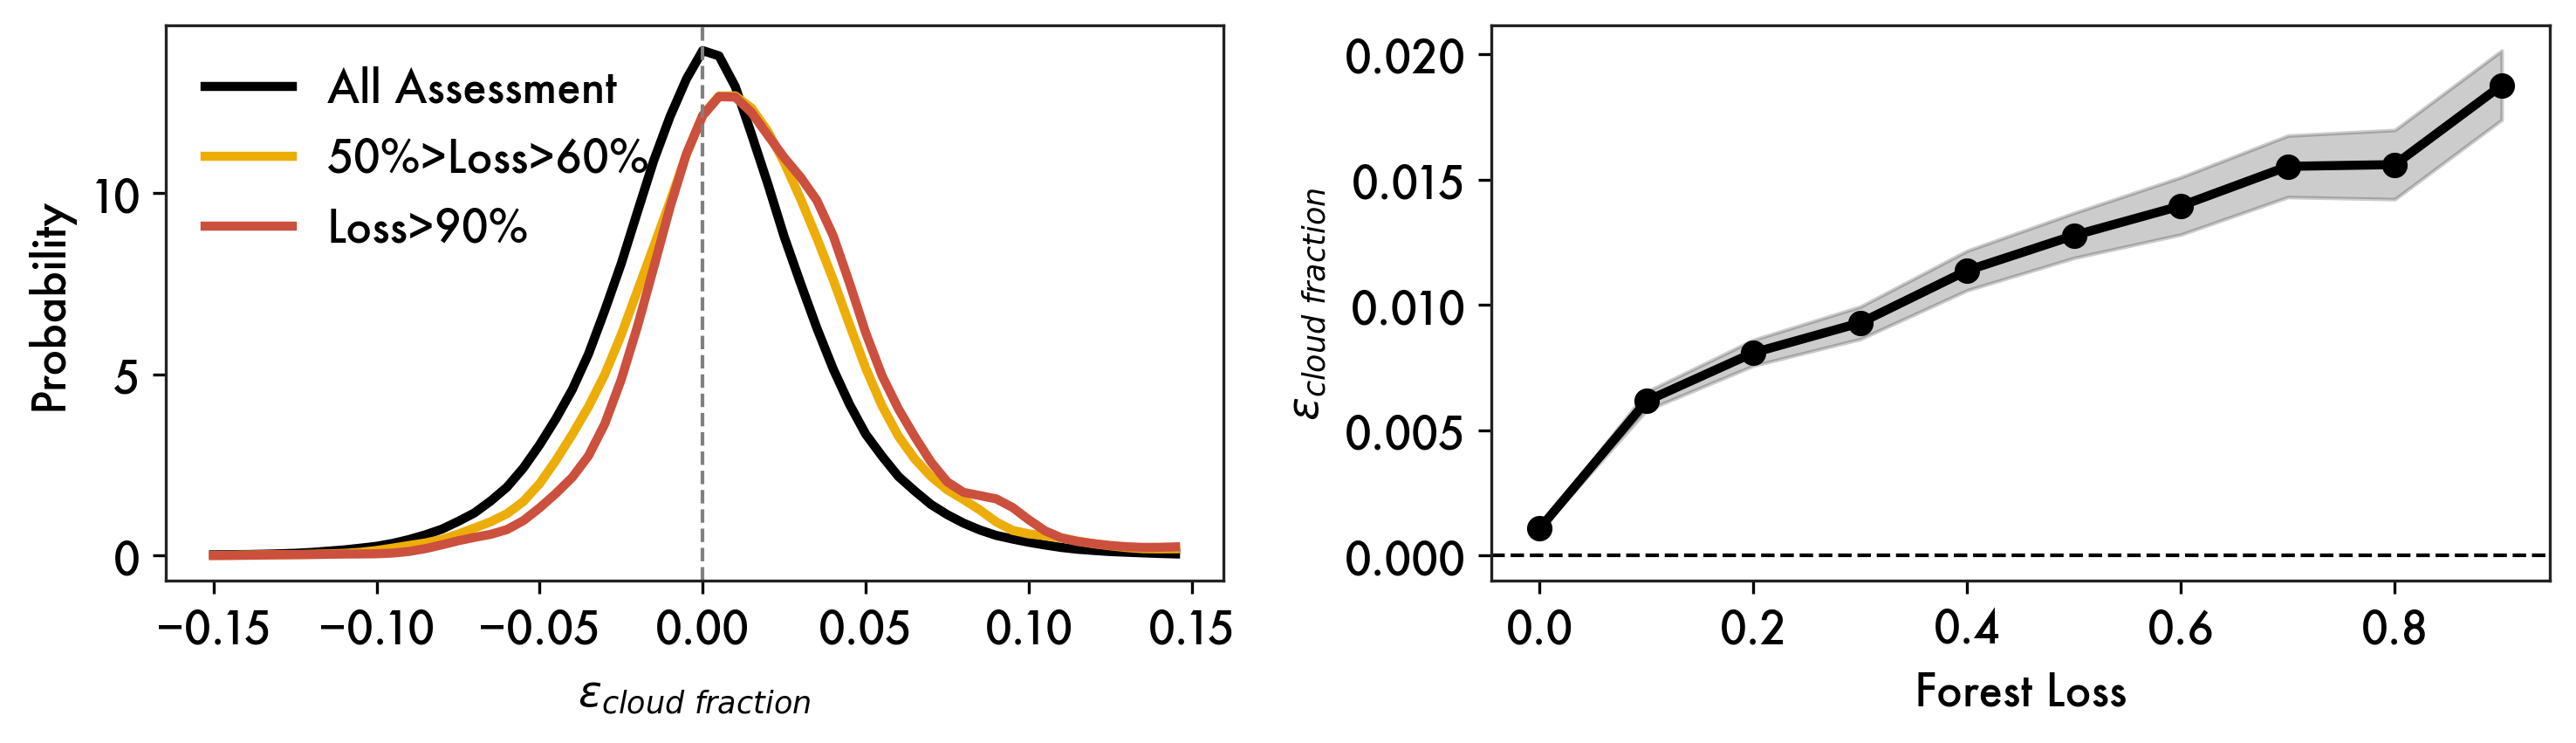

1


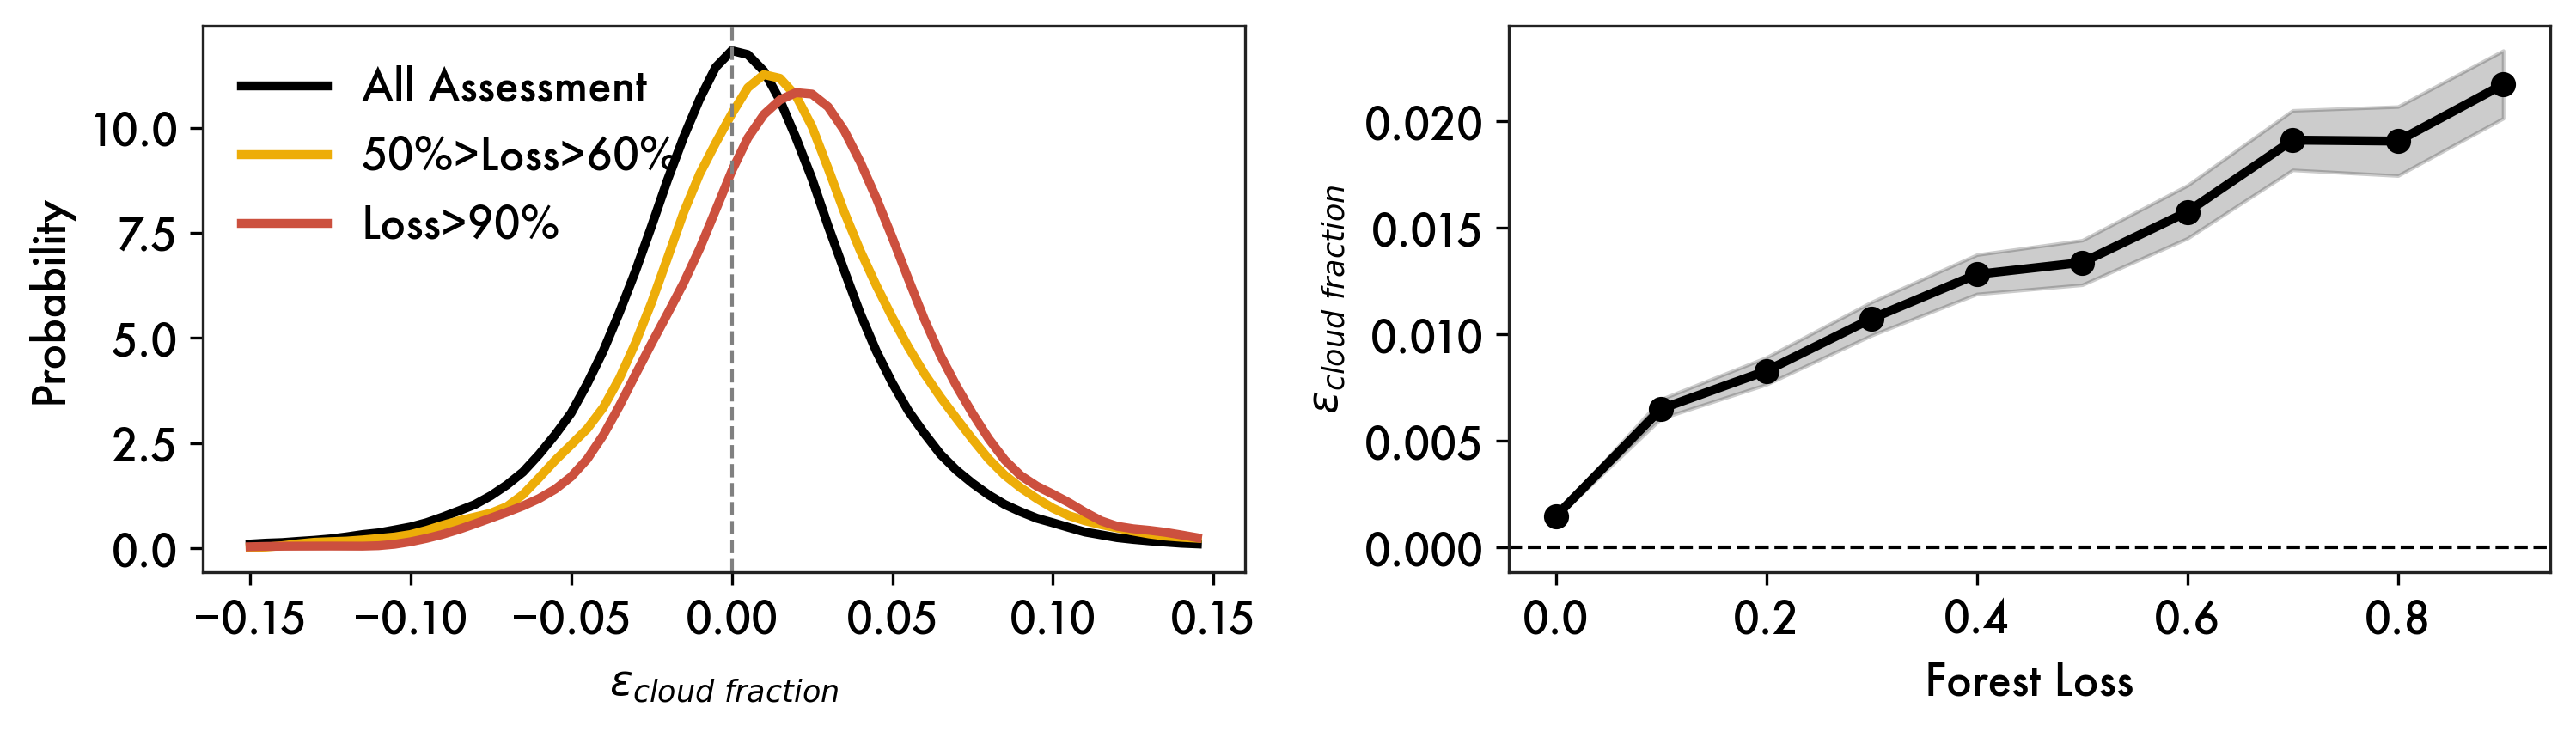

2


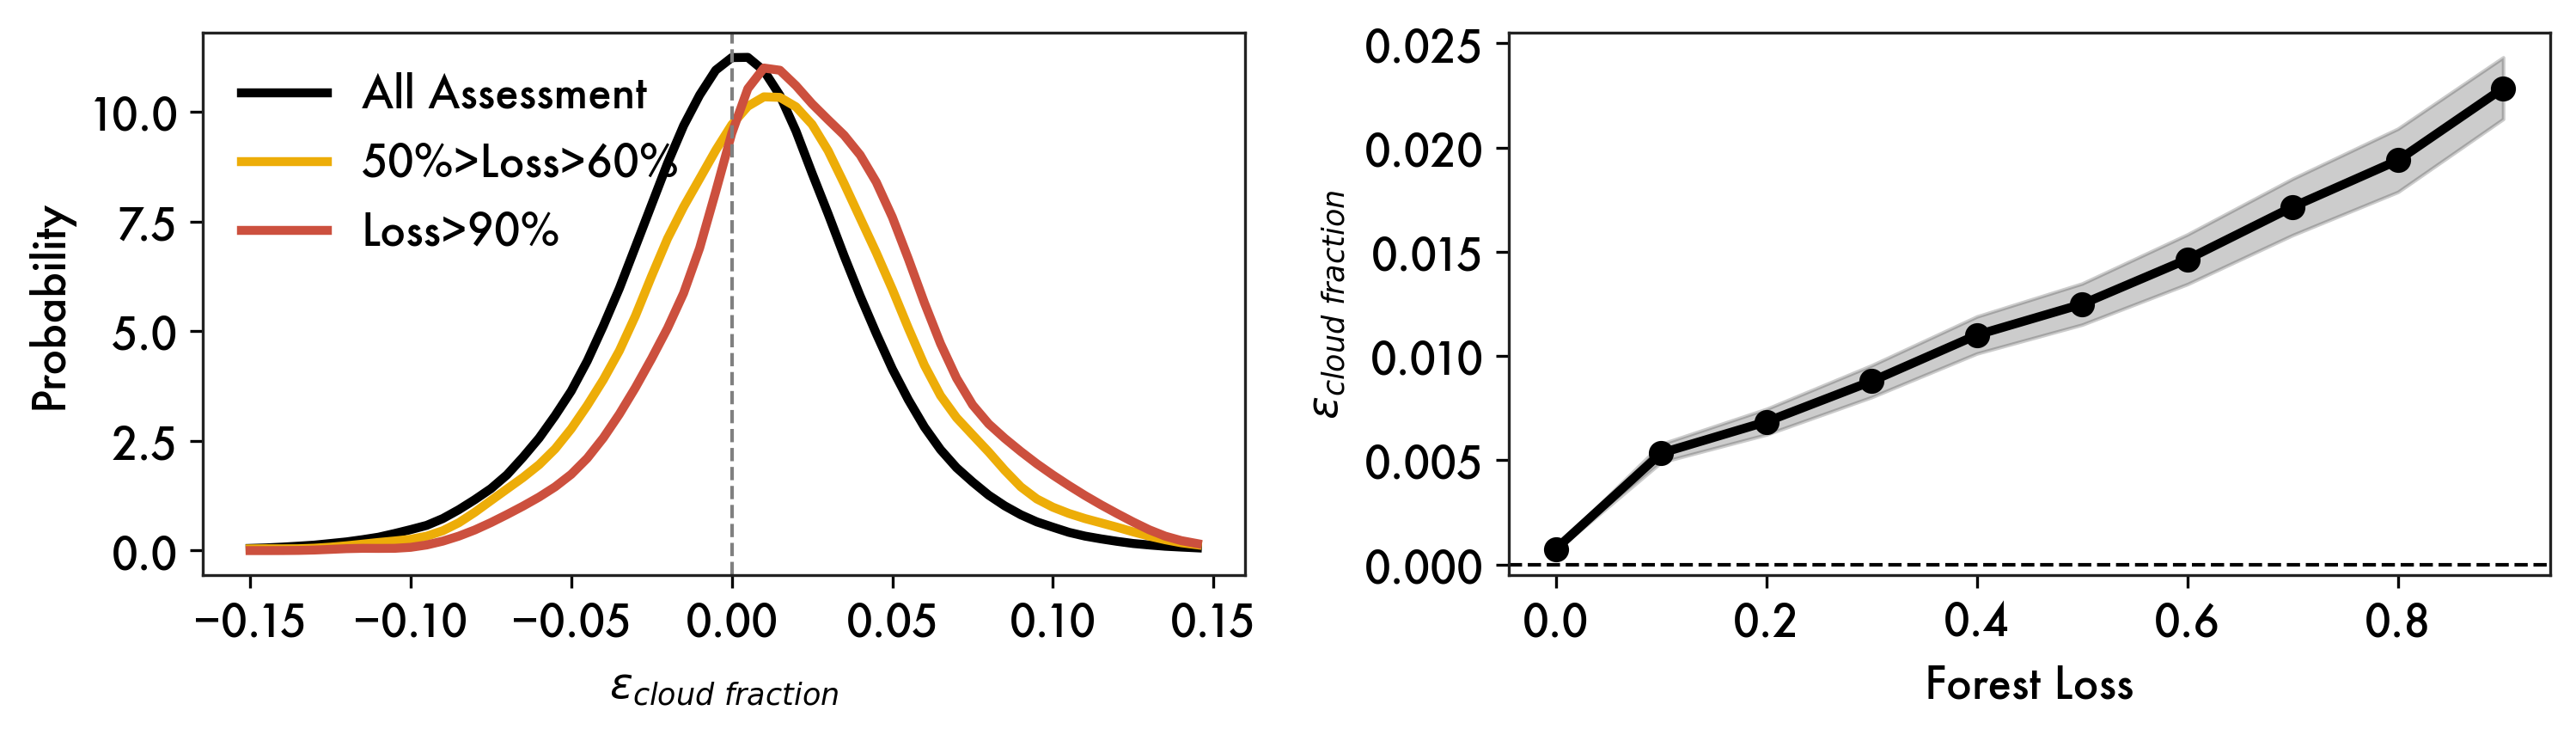

3


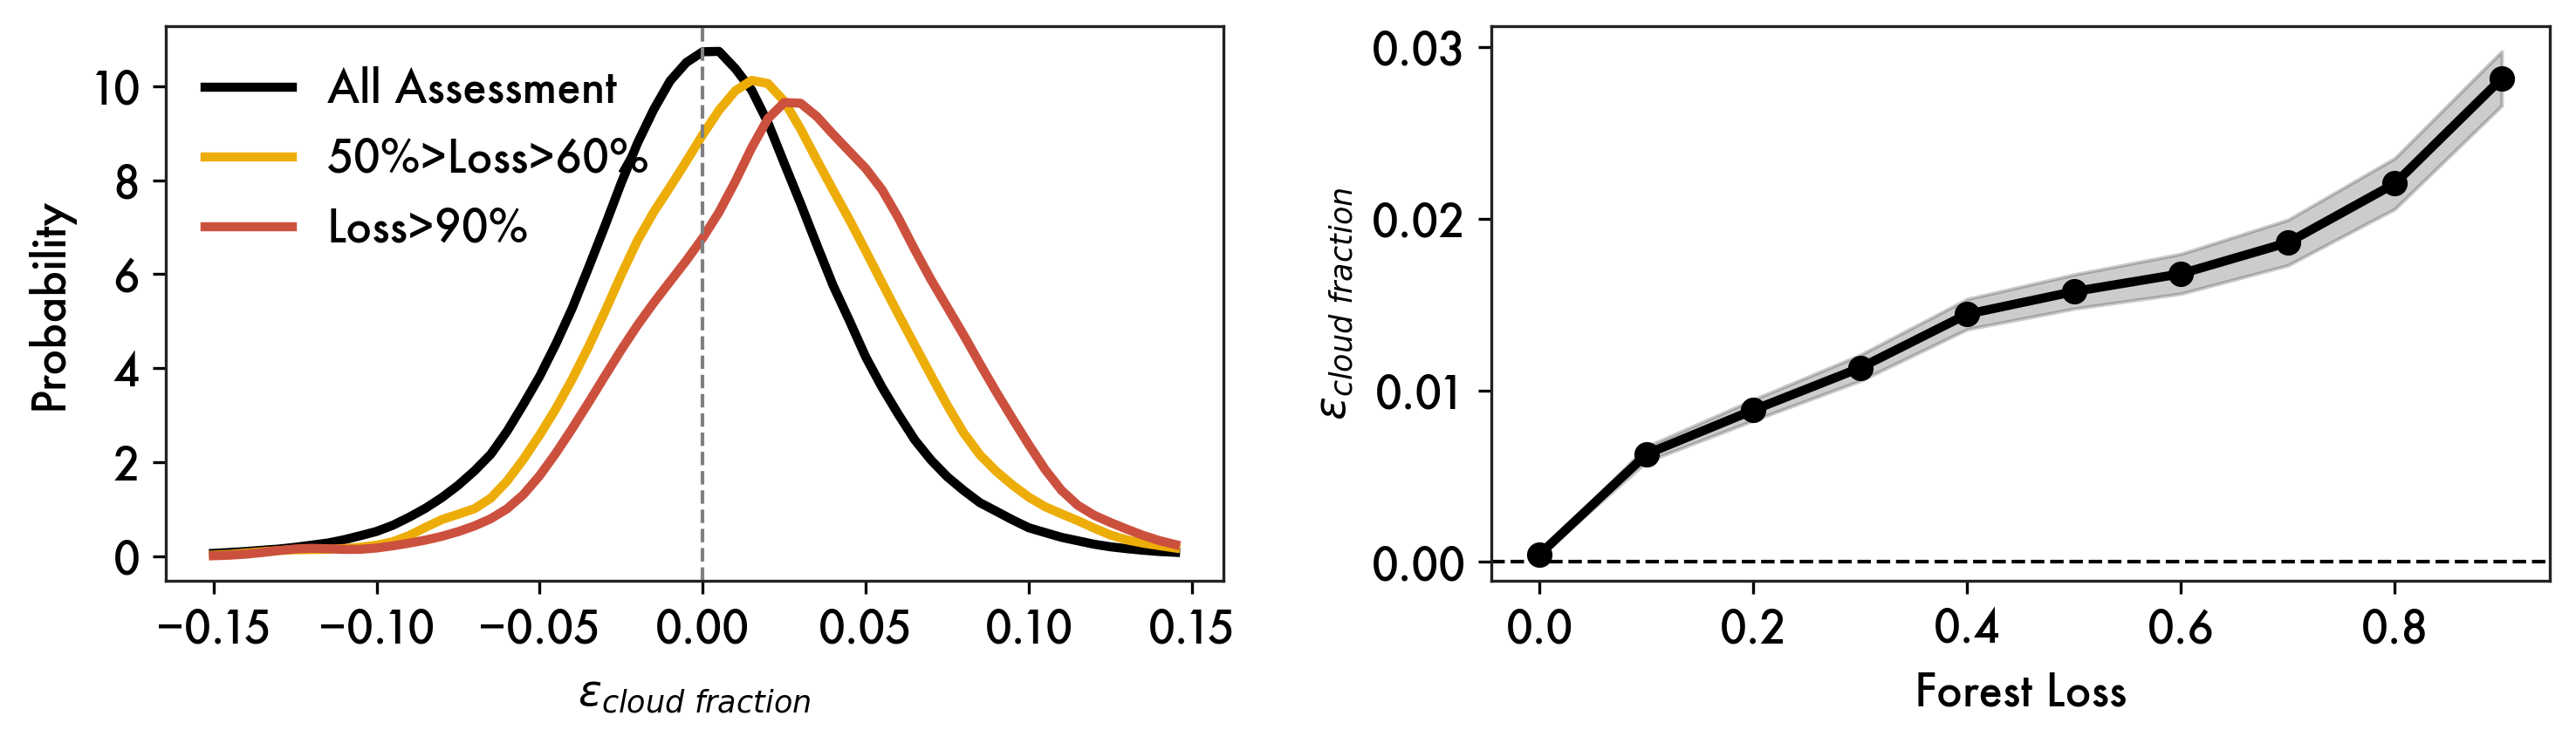

4


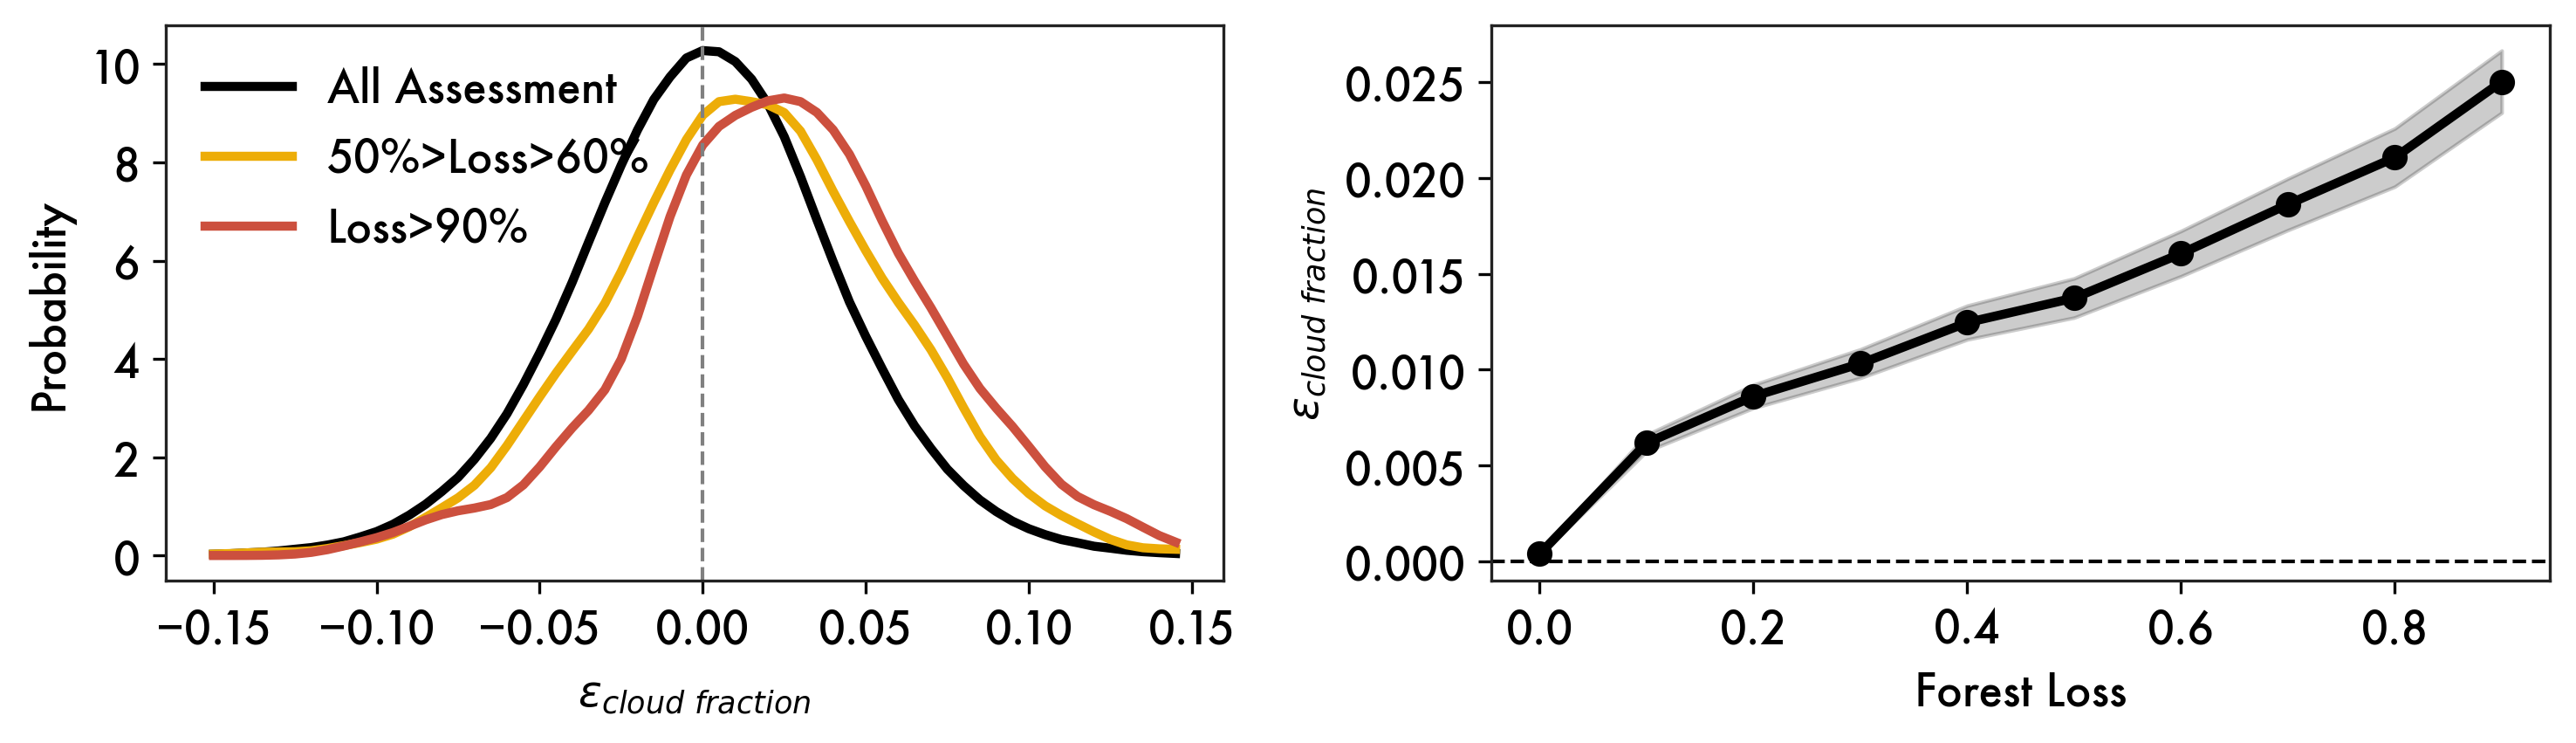

5


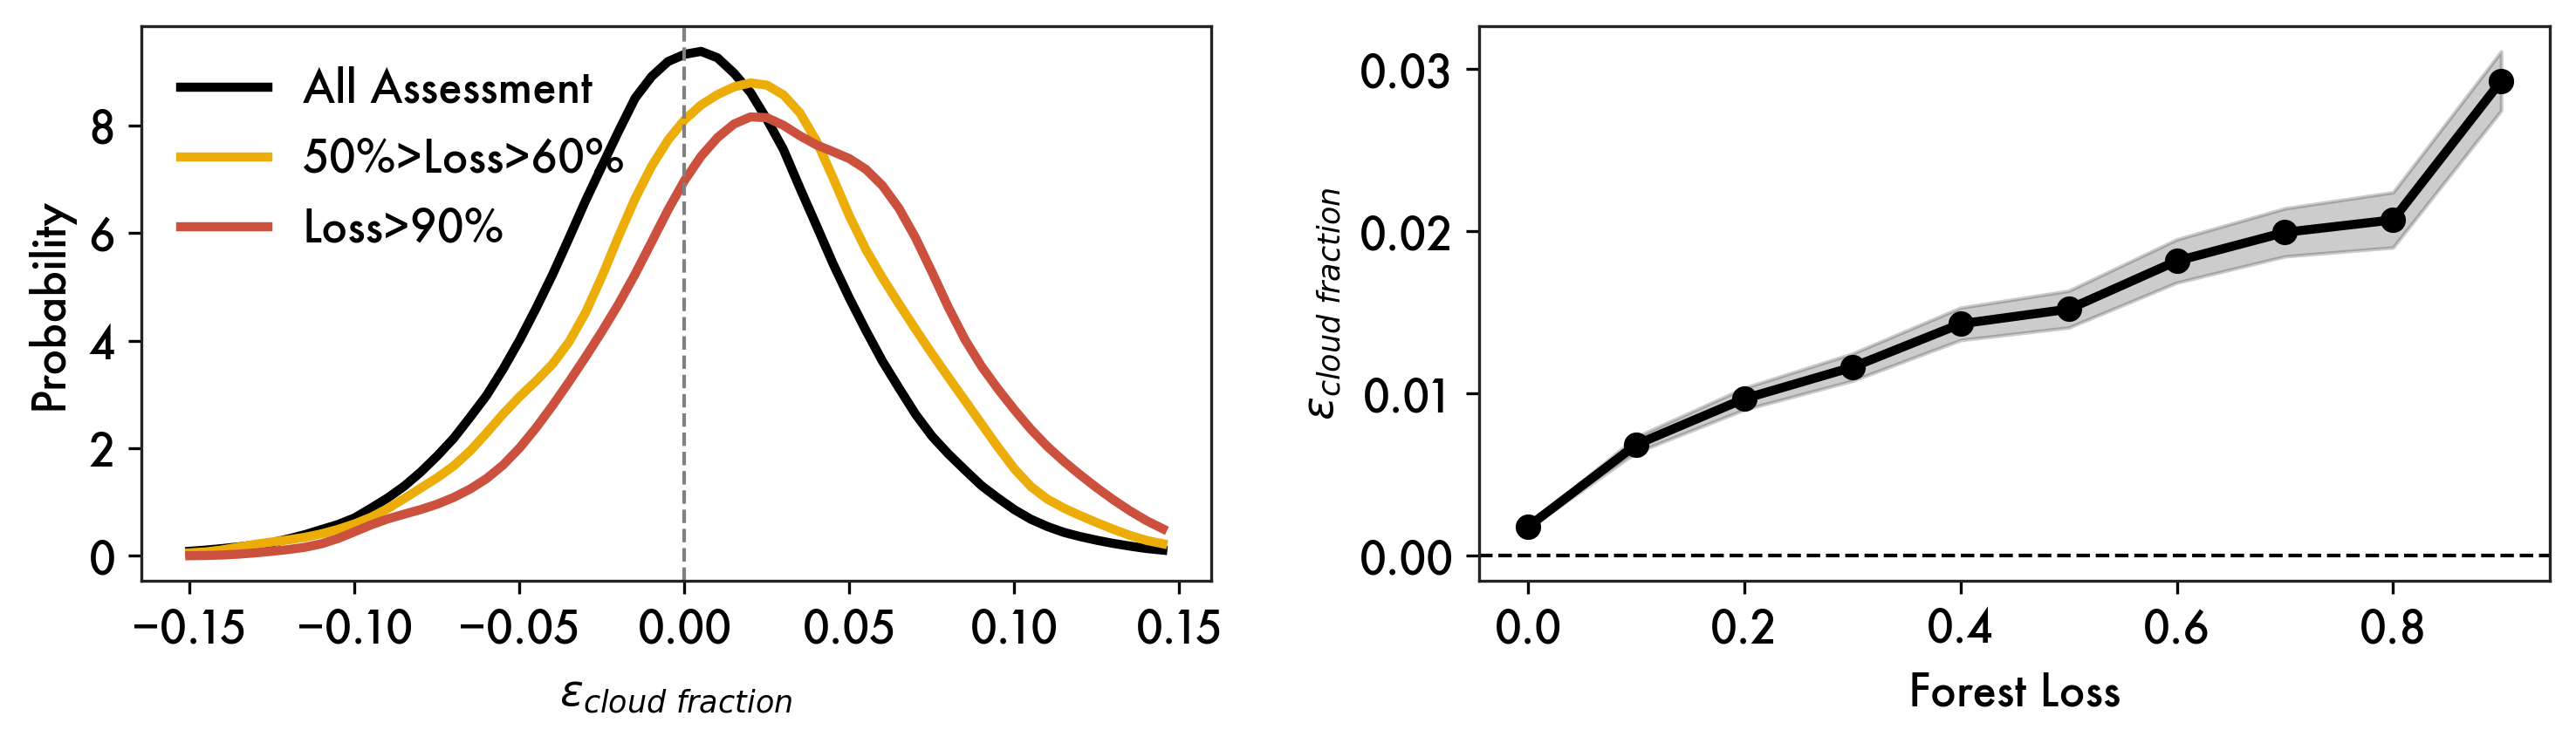

6


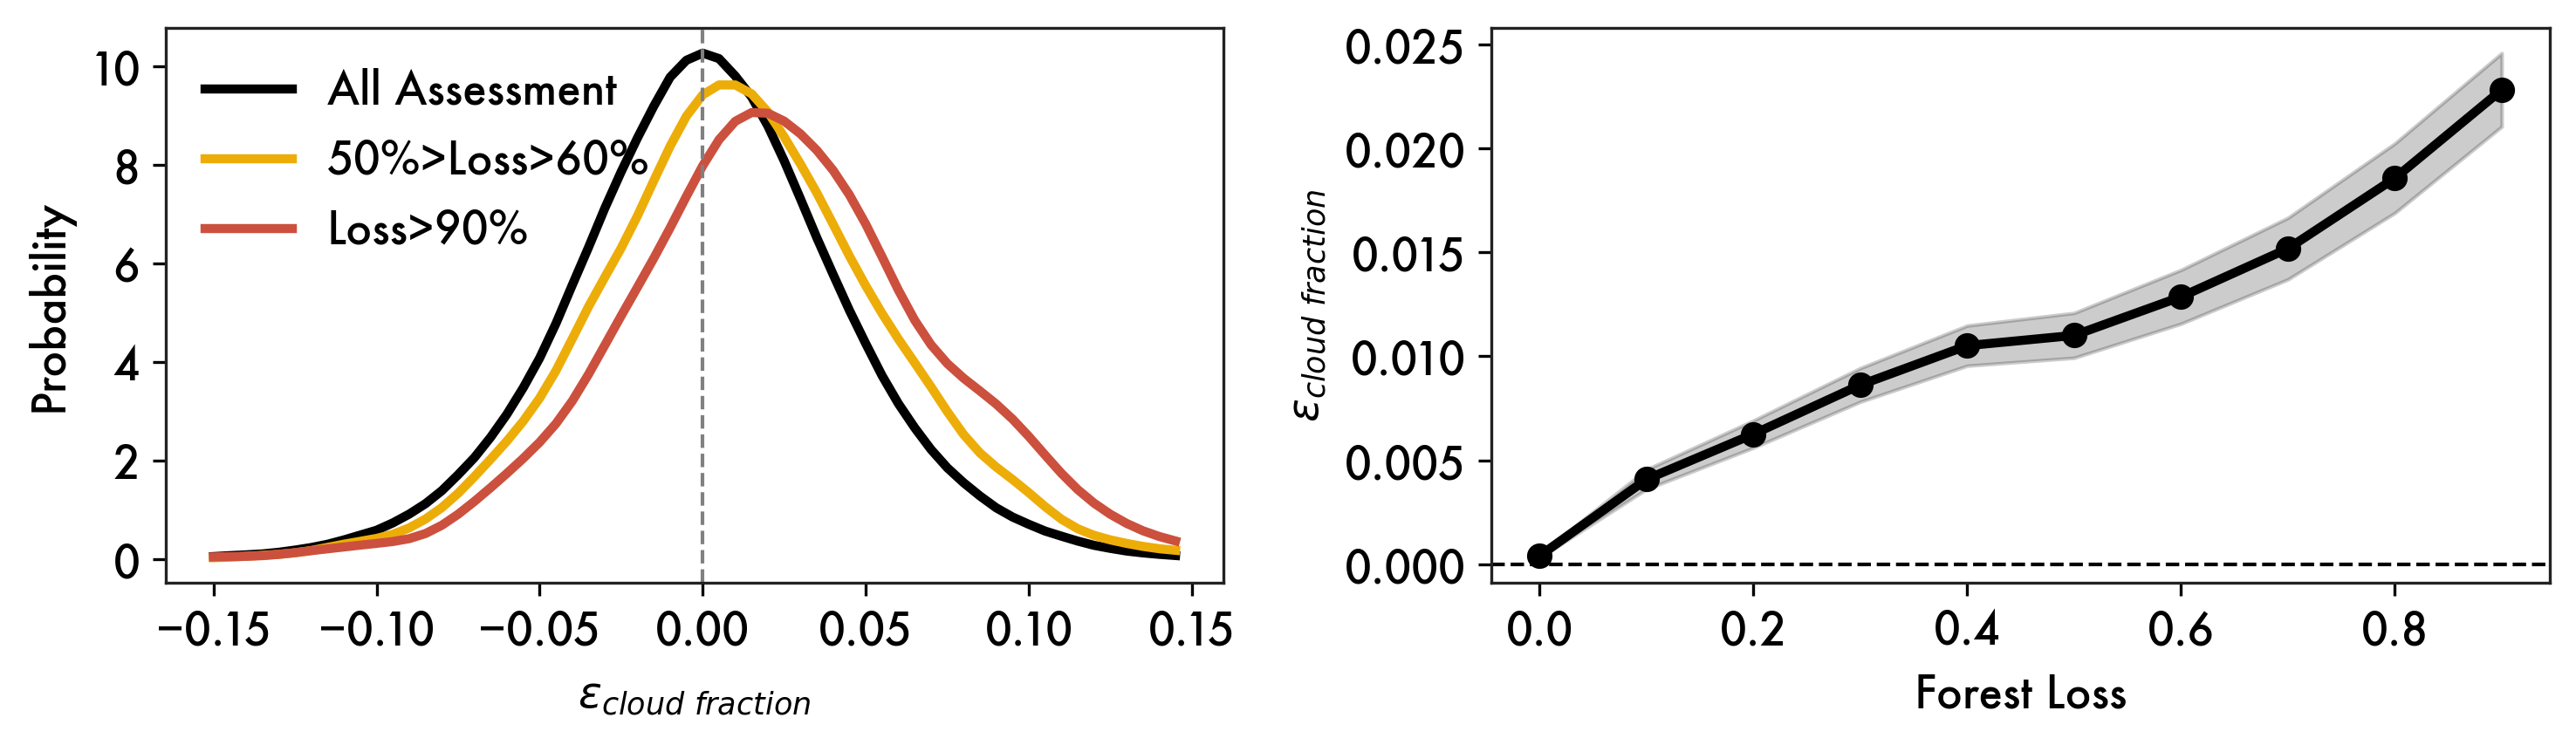

7


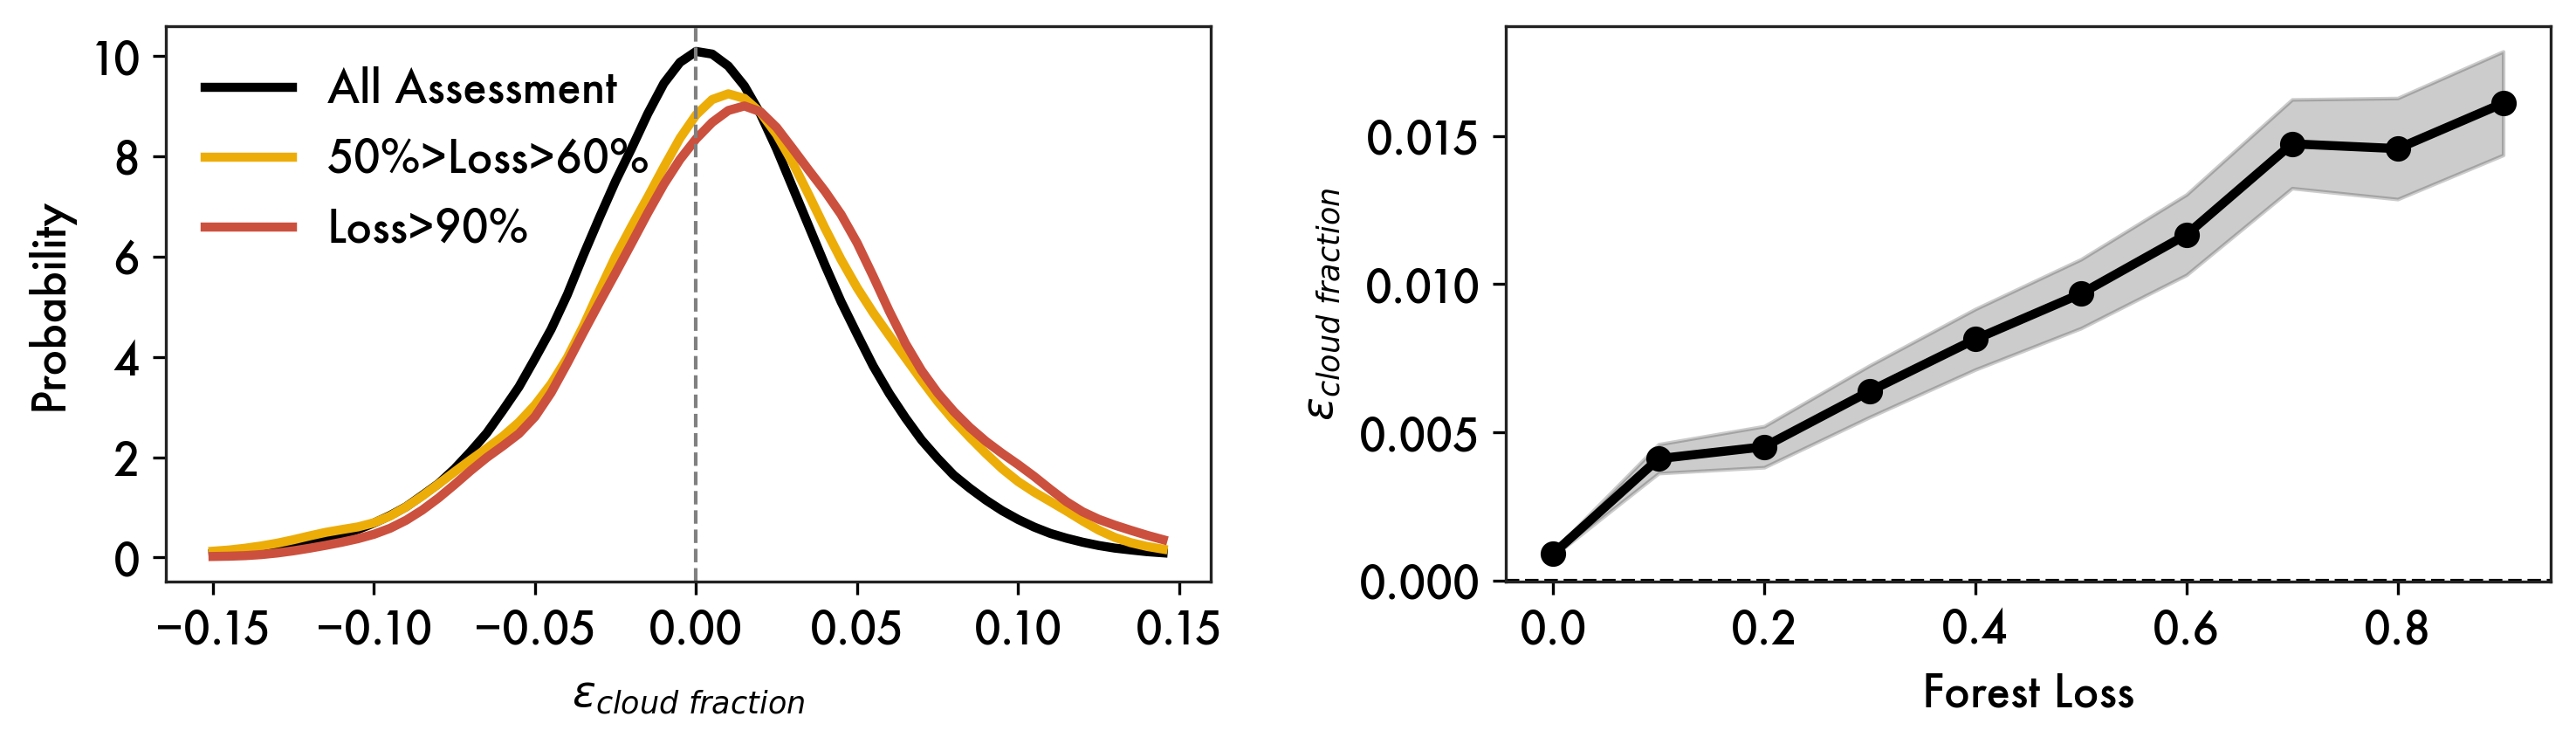

8


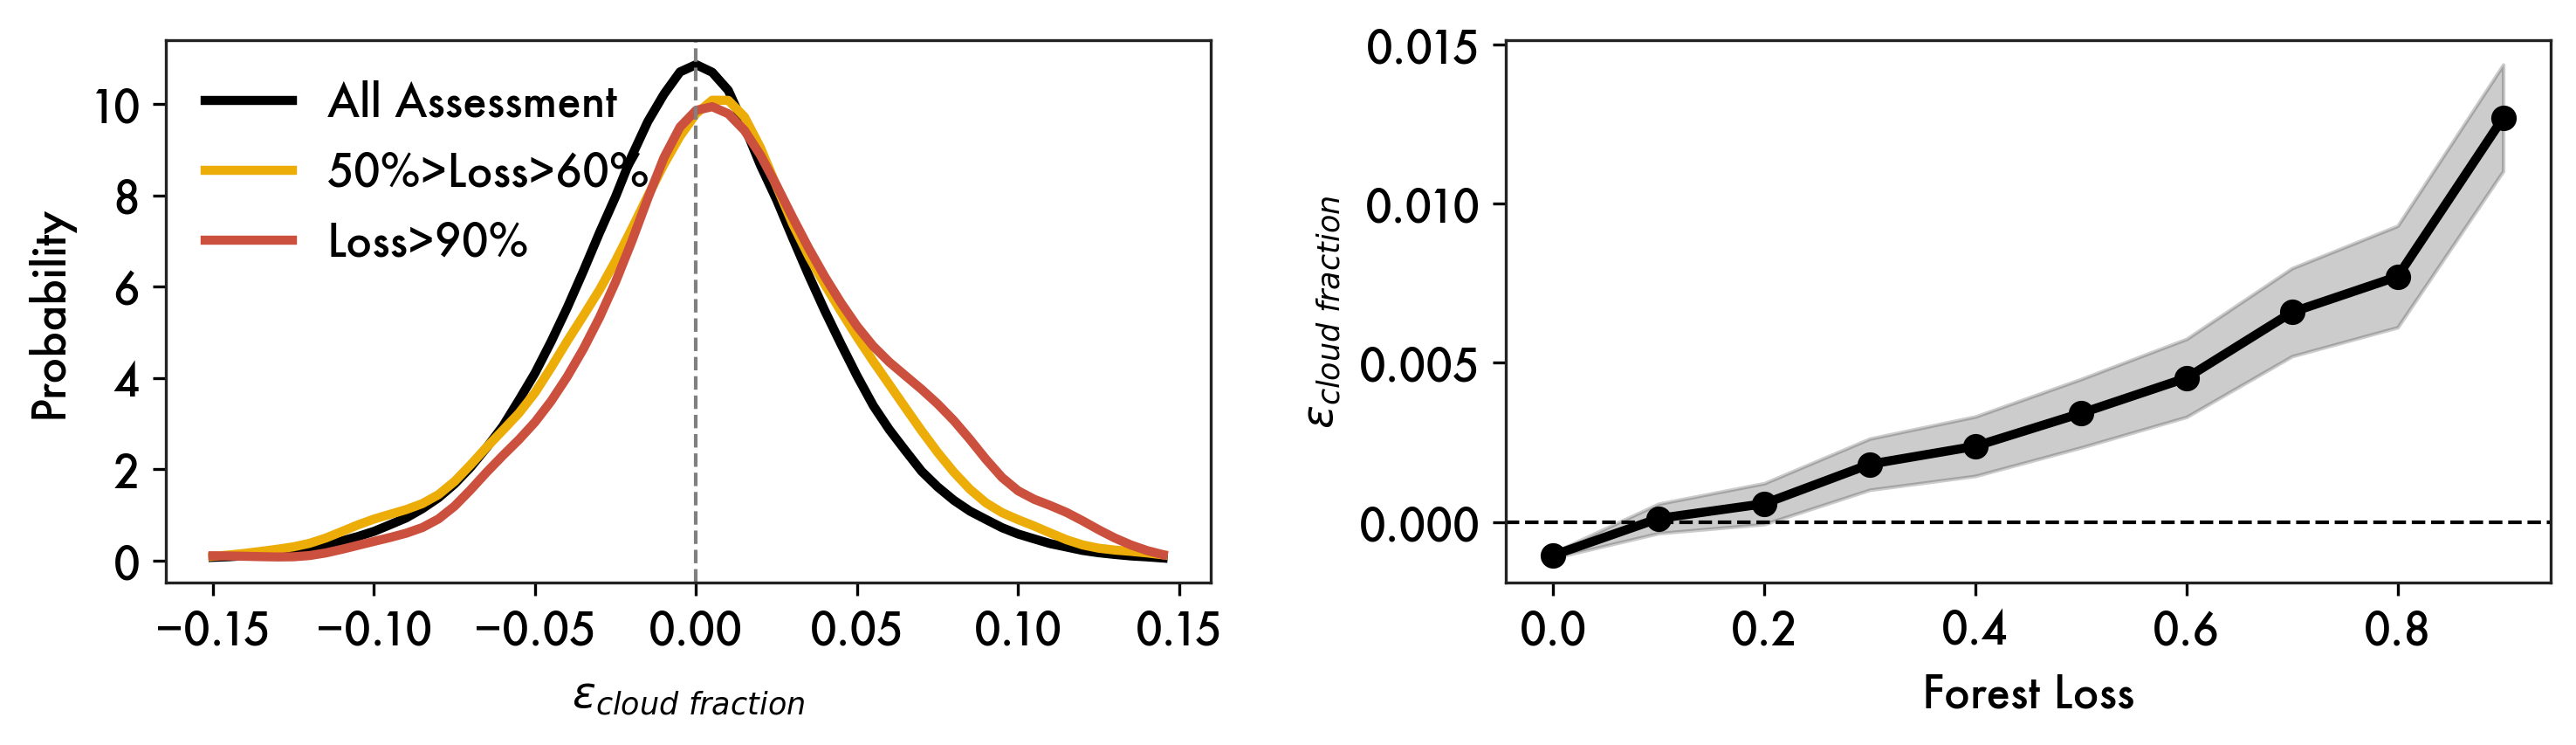

9


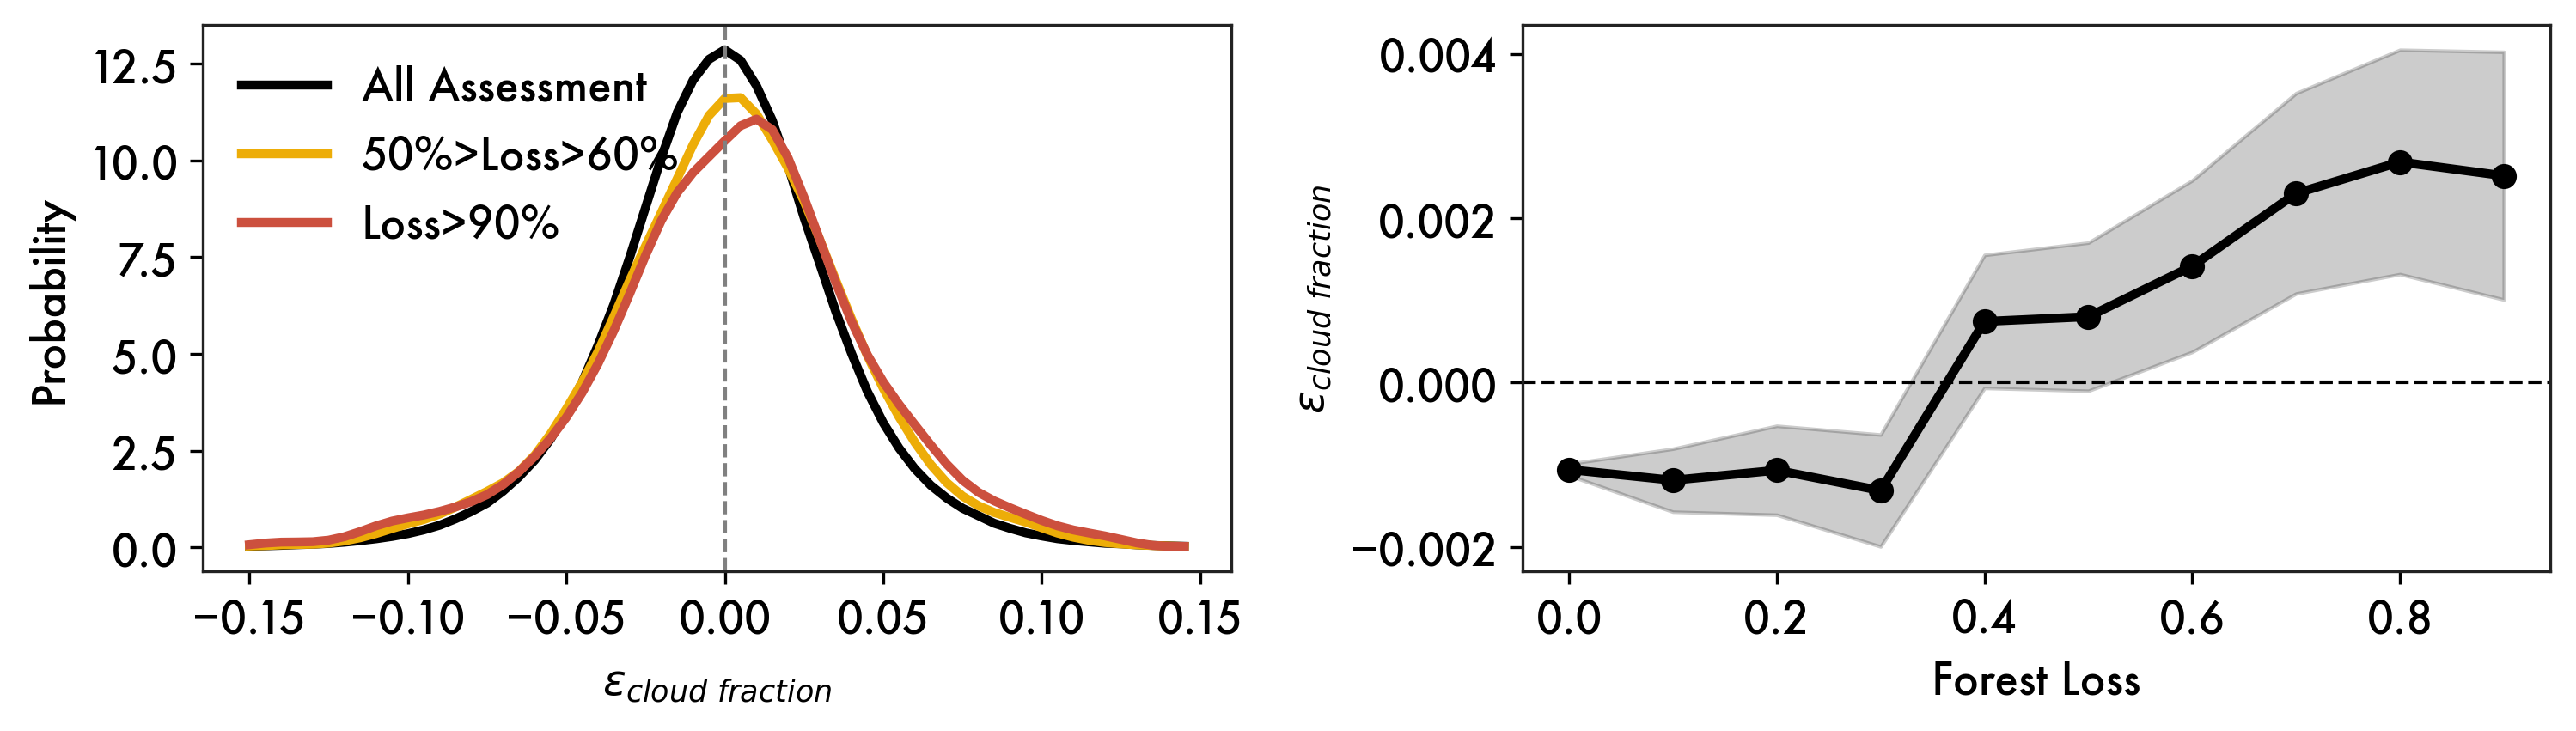

10


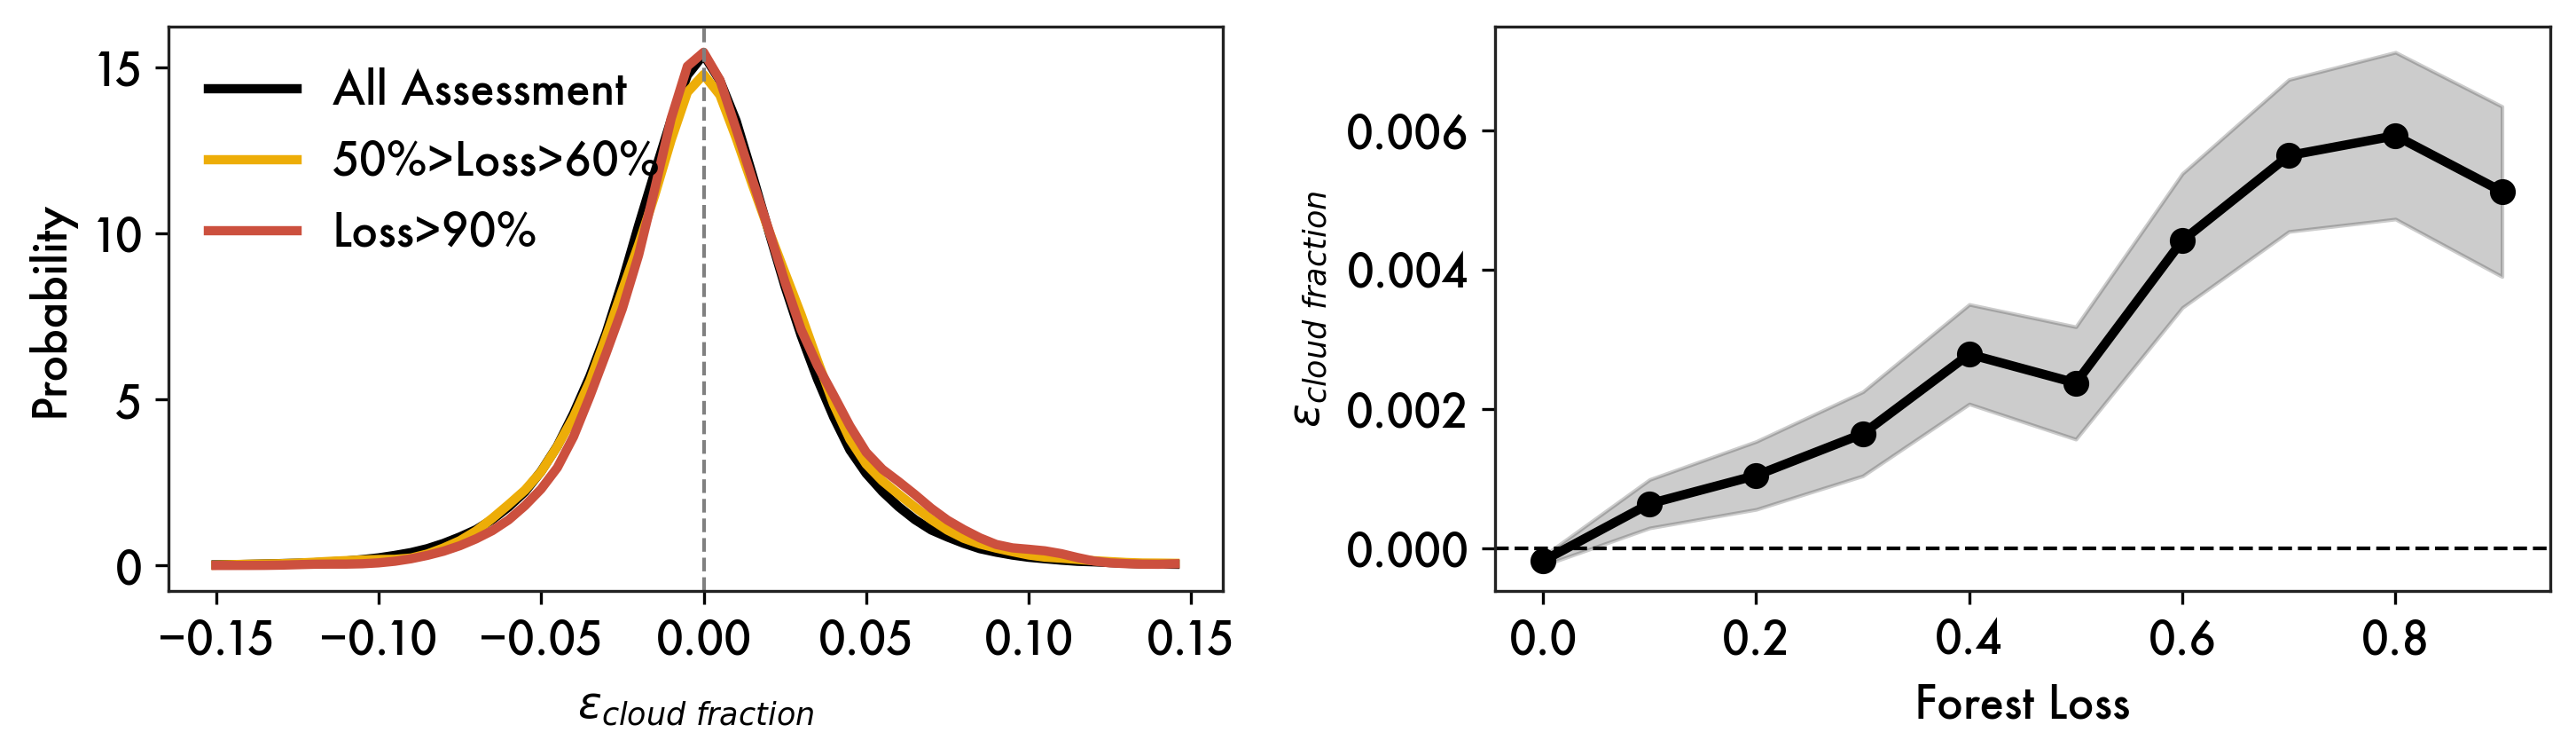

11


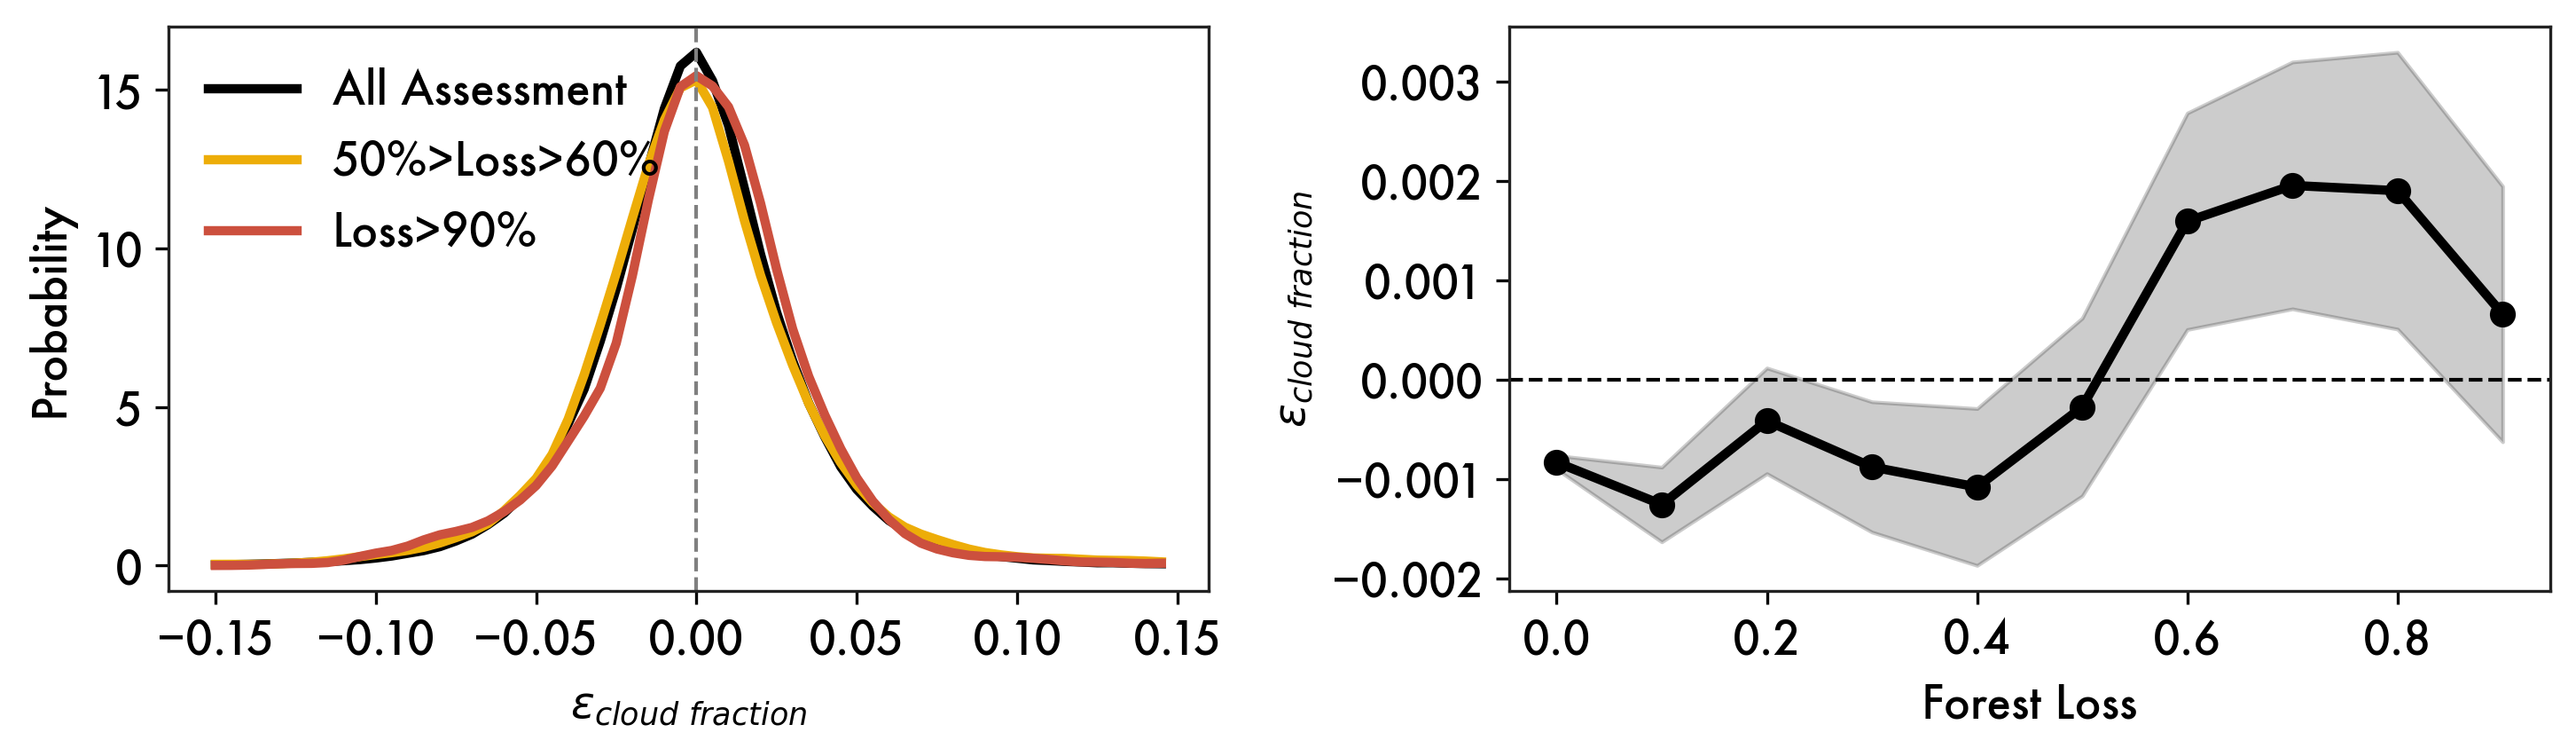

12


In [264]:
import scipy.stats as sts

for mo in range(1,13):
    fig, axes = plt.subplots(1,2,figsize=(10,3))

    x = np.arange(-0.15,0.15,0.005)

    kde = sts.gaussian_kde(alldf[f"didCloud{mo}"].dropna())
    axes[0].plot(x,kde.pdf(x),color='black', label = 'All Assessment')

    kde = sts.gaussian_kde(alldf[(alldf.Loss>=0.5) & (alldf.Loss<0.6)][f"didCloud{mo}"].dropna())
    axes[0].plot(x,kde.pdf(x),color=yellow, label = '50%>Loss>60%')

    kde = sts.gaussian_kde(alldf[alldf.Loss>=0.9][f"didCloud{mo}"].dropna())
    axes[0].plot(x,kde.pdf(x),color=red, label = 'Loss>90%')

    axes[0].legend(loc='upper left')

    axes[0].set_ylabel('Probability')
    axes[0].set_xlabel('$\epsilon_{cloud\ fraction}$')
    axes[0].axvline(0,ls='--',lw=1,color='gray')

    res = 0.1
    plot = alldf.groupby(res * (alldf.Loss//res)).mean()
    plot_std = alldf.groupby(res * (alldf.Loss//res)).std()
    plot_cnt = alldf.groupby(res * (alldf.Loss//res)).count()

    axes[1].plot(plot.index,plot[f"didCloud{mo}"],marker='o',color='black')
    axes[1].fill_between(plot.index,
                         plot[f"didCloud{mo}"]-(1.96*plot_std[f"didCloud{mo}"])/np.sqrt(plot_cnt[f"didCloud{mo}"]),
                         plot[f"didCloud{mo}"]+(1.96*plot_std[f"didCloud{mo}"])/np.sqrt(plot_cnt[f"didCloud{mo}"]),
                         color='black',alpha=0.2)
    axes[1].axhline(0,ls='--',lw=1)

    axes[1].set_xlabel('Forest Loss')
    axes[1].set_ylabel('$\epsilon_{cloud\ fraction}$')

    plt.show()
    plt.close('all')
    print(mo)

In [263]:
print(alldf)

                     Loss  PriorLoss  Loss_1km  PriorLoss_1km  Loss_2km  \
-5.448  104.160  0.000000   0.001953  0.004102       0.004492  0.003005   
-5.440  104.128  0.000000   0.000000  0.000586       0.002344  0.002523   
        104.136  0.000000   0.000000  0.005273       0.005664  0.003729   
        104.144  0.023438   0.023438  0.008789       0.008789  0.003817   
        104.152  0.001953   0.001953  0.006836       0.006836  0.004084   
...                   ...        ...       ...            ...       ...   
 18.072 96.376   0.000000   0.000000  0.000000       0.001953  0.000651   
        96.384   0.000000   0.000000  0.001465       0.031494  0.000651   
        96.392   0.005859   0.005859  0.001465       0.050049  0.001953   
        96.400   0.000000   0.025391  0.004395       0.038330  0.003472   
 18.120 96.400   0.000000   0.017578  0.000977       0.013672  0.000366   

                 PriorLoss_2km  Loss_5km  PriorLoss_5km  Loss_10km  \
-5.448  104.160       0.00323

In [250]:
alldf = alldf[np.append(['Loss','PriorLoss',
               'Loss_1km','PriorLoss_1km',
               'Loss_2km','PriorLoss_2km',
               'Loss_5km','PriorLoss_5km',
               'Loss_10km','PriorLoss_10km',
               'deltaCloud','deltaCloud_ctrl',
               'didCloud','year'],[f"didCloud{mo}" for mo in range(1,13)])]

In [251]:
alldf.to_pickle(f"{anaPath}/terra_cf_10km_all.pkl")

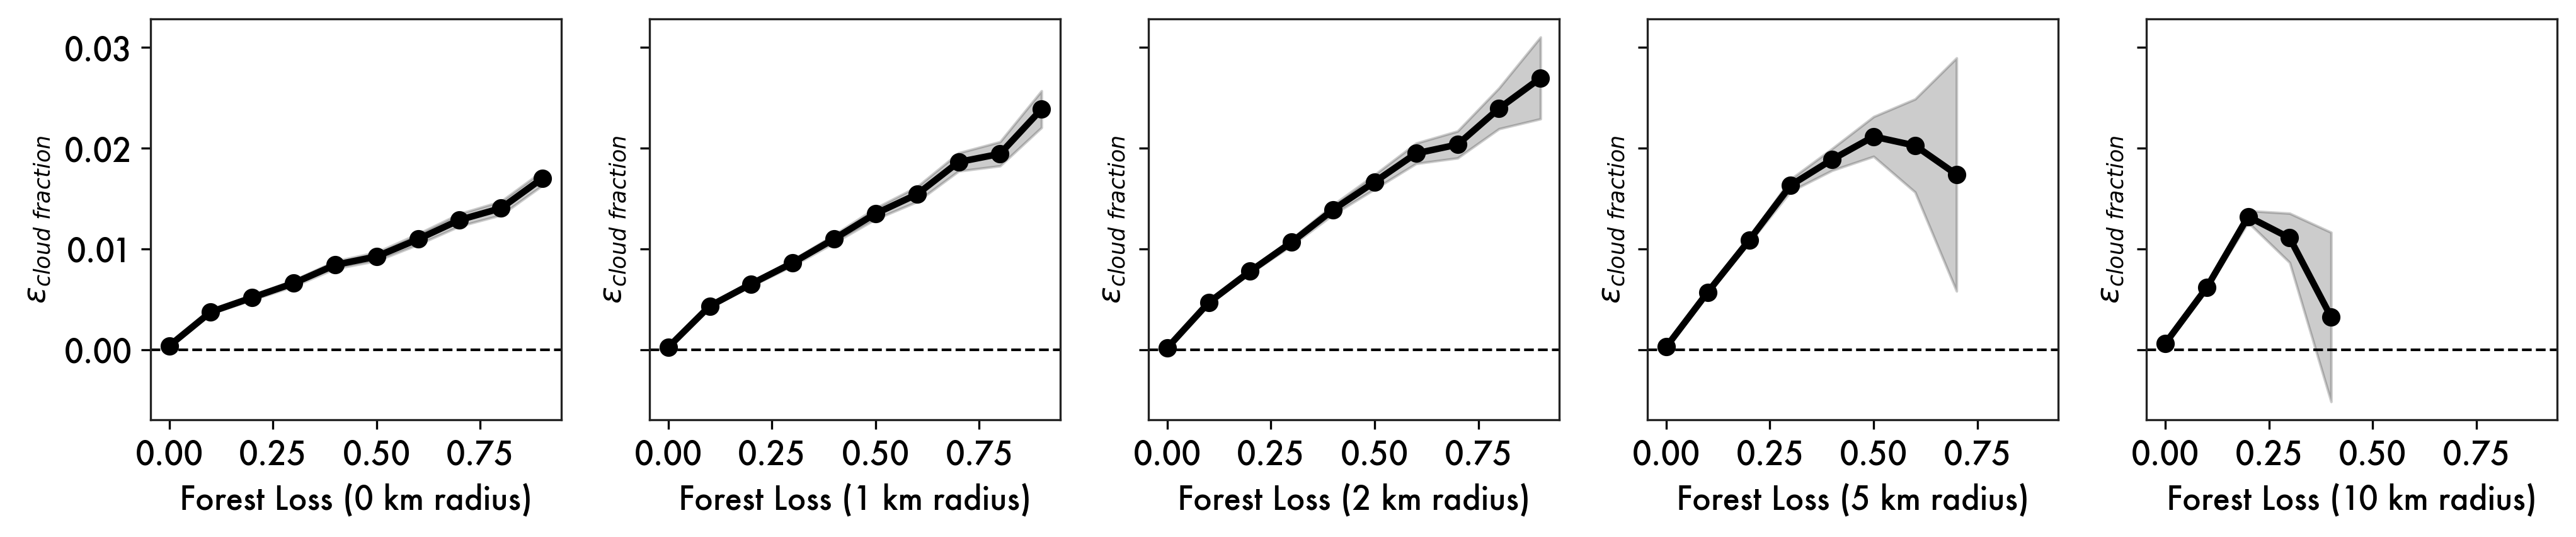

In [324]:
import scipy.stats as sts

fig, axes = plt.subplots(1,5,figsize=(14,3),sharex=True,sharey=True)

res = 0.1


for ax,d in zip(axes,[0,1,2,5,10]):
    if d == 0:
        var = 'Loss'
    else:
        var = f"Loss_{d}km"
    plot = alldf.groupby(res * (alldf[var]//res)).mean()
    plot_std = alldf.groupby(res * (alldf[var]//res)).std()
    plot_cnt = alldf.groupby(res * (alldf[var]//res)).count()

    plot = plot[plot_cnt>10]
    plot_std = plot_std[plot_cnt>10]

    ax.plot(plot.index,plot[f"didCloud"],marker='o',color='black')
    ax.fill_between(plot.index,
                         plot[f"didCloud"]-(1.96*plot_std[f"didCloud"])/np.sqrt(plot_cnt[f"didCloud"]),
                         plot[f"didCloud"]+(1.96*plot_std[f"didCloud"])/np.sqrt(plot_cnt[f"didCloud"]),
                         color='black',alpha=0.2)
    ax.axhline(0,ls='--',lw=1)

    ax.set_xlabel(f'Forest Loss ({d} km radius)')
    ax.set_ylabel('$\epsilon_{cloud\ fraction}$')

plt.show()
plt.close('all')

# Statistical Sampling for Hypothesis Testing

In [292]:
low = alldf[alldf.Loss_1km <= 0.2]
high = alldf[alldf.Loss_1km >= 0.8]

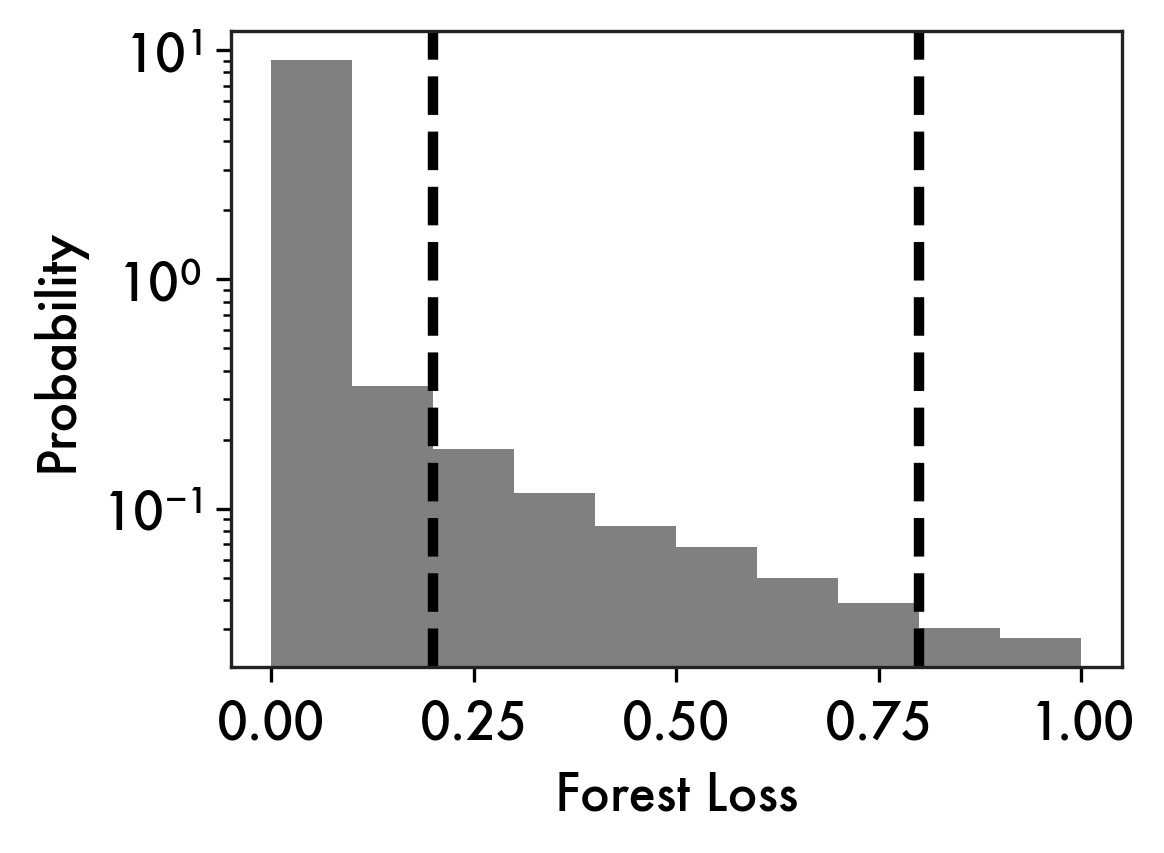

In [293]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.hist(alldf.Loss, density=1, color='gray')
ax.axvline(0.2,ls='--')
ax.axvline(0.8,ls='--')
ax.set_yscale('log')
ax.set_ylabel('Probability')
ax.set_xlabel('Forest Loss')

plt.show()

In [294]:
d = 1
nbins = 10
res = 0.2/nbins

low['Loss_bin'] = low[f"Loss_{d}km"]//res
high['Loss_bin'] = (high[f"Loss_{d}km"]-0.8)//res

/tmp/ipykernel_3684/2951191680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['Loss_bin'] = low[f"Loss_{d}km"]//res
/tmp/ipykernel_3684/2951191680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['Loss_bin'] = (high[f"Loss_{d}km"]-0.8)//res


In [295]:
pts = temp[['longitude','latitude']]

In [296]:
def update_proximity(df, min_dist = 10):
    """
    Count neighbors within 10 km
    """
    points = df[['longitude', 'latitude']]
    proximity = np.sum(cdist(points, points) < min_dist*0.008, 0)

    return proximity


def drop_closest(df_closest, min_dist = 10):
    """
    Drop points that have the most neighbors within 10 km (threshold)
    
    df_closest['proximity'] contains the number of neighbors within 10 km
    """
    df_closest['proximity'] = update_proximity(df_closest, min_dist) 
    
    threshold = df_closest['proximity'].max()
    copy = df_closest.query('proximity < {0}'.format(threshold))
    
    return copy.copy()

def drops_2(df_2, min_dist = 10):
    """
    For every two points within 10 km, drop one
    """
    df_2['proximity'] = update_proximity(df_2, min_dist) 

    drops = df_2.query('proximity == 2').sort_values(
            ['longitude', 'latitude'])

    df_2 = df_2.copy().drop(drops.index[::2])

    df_2['proximity'] = update_proximity(df_2, min_dist) 
    
    return df_2.copy()

def iterate_drop(df_iterate, min_dist = 10):
    """
    Ensure that all selected points are more than 10 km apart
    
    """
    df_iterate = df_iterate.copy()
    df_iterate['proximity'] = update_proximity(df_iterate, min_dist)     
    
    while df_iterate.proximity.max() > 2:
        df_iterate = drop_closest(df_iterate, min_dist)

    df_iterate = drops_2(df_iterate, min_dist)

    return df_iterate.copy()

def isolate_points(subset, min_dist = 10):
    """
    Imposes a minimum distance of min_dist=10 km between points for each year
    """
    distanced = pd.DataFrame()
    
    for year in subset.year.unique():
        
        d = iterate_drop(subset.query("year == {0}".format(year)),
                         min_dist = min_dist)
        distanced = pd.concat([distanced,d],ignore_index=True)
        
    return(distanced)

In [297]:
np.random.seed(0)
    
b = 0
nsample = 50
nrepeat = 500

data = low.copy().reset_index()
data.columns = np.append(['latitude','longitude'],data.columns[2:])

In [298]:
starttime = time.time()

for data,col in zip([low,high],
                   [blue,red]):
    #xs = []
    ys = []
    
    data = data.copy().reset_index()
    data.columns = np.append(['latitude','longitude'],data.columns[2:])

    for i in range(nrepeat):
        subset = pd.DataFrame()

        for b in range(10):
            temp = data[data.Loss_bin==b]

            if len(temp) > nsample: 
                num = np.minimum(nsample*3,len(temp))
                temp = temp.sample(num)

            if len(temp)>0:
                temp = isolate_points(temp)

            temp = temp.sample(nsample)

            subset = pd.concat([temp,subset],ignore_index=True)
            
        #xs.append(subset.Loss.mean())
        ys.append(subset.mean()[['didCloud']+[f'didCloud{mo}' for mo in range(1,13)]])
        
        print(i,time.time()-starttime)

    if col == blue:
        low_samps = ys#(xs,ys)
    else:
        high_samps = ys#(xs,ys)


0 2.911616086959839
1 4.4369823932647705
2 6.053544759750366
3 7.654908180236816
4 9.222583770751953
5 10.831342458724976



KeyboardInterrupt



In [283]:
print(low_samps[0])

didCloud      0.002861
didCloud1     0.006472
didCloud2     0.002382
didCloud3     0.003664
didCloud4     0.005070
didCloud5     0.003627
didCloud6     0.006151
didCloud7     0.002078
didCloud8     0.003416
didCloud9     0.001416
didCloud10   -0.001374
didCloud11    0.000049
didCloud12   -0.000708
dtype: float64


1


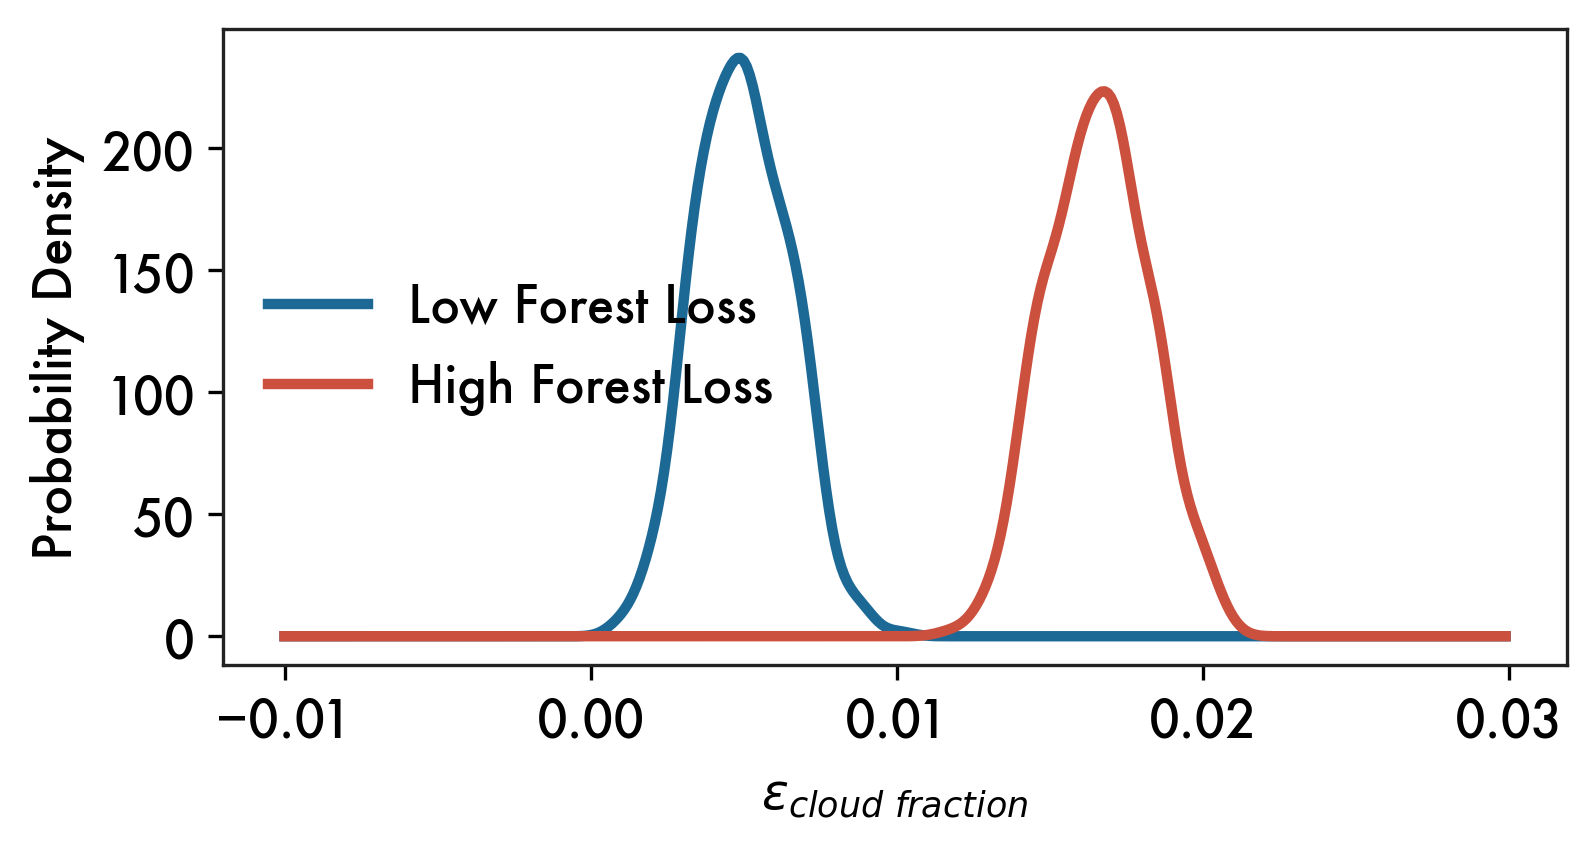

2


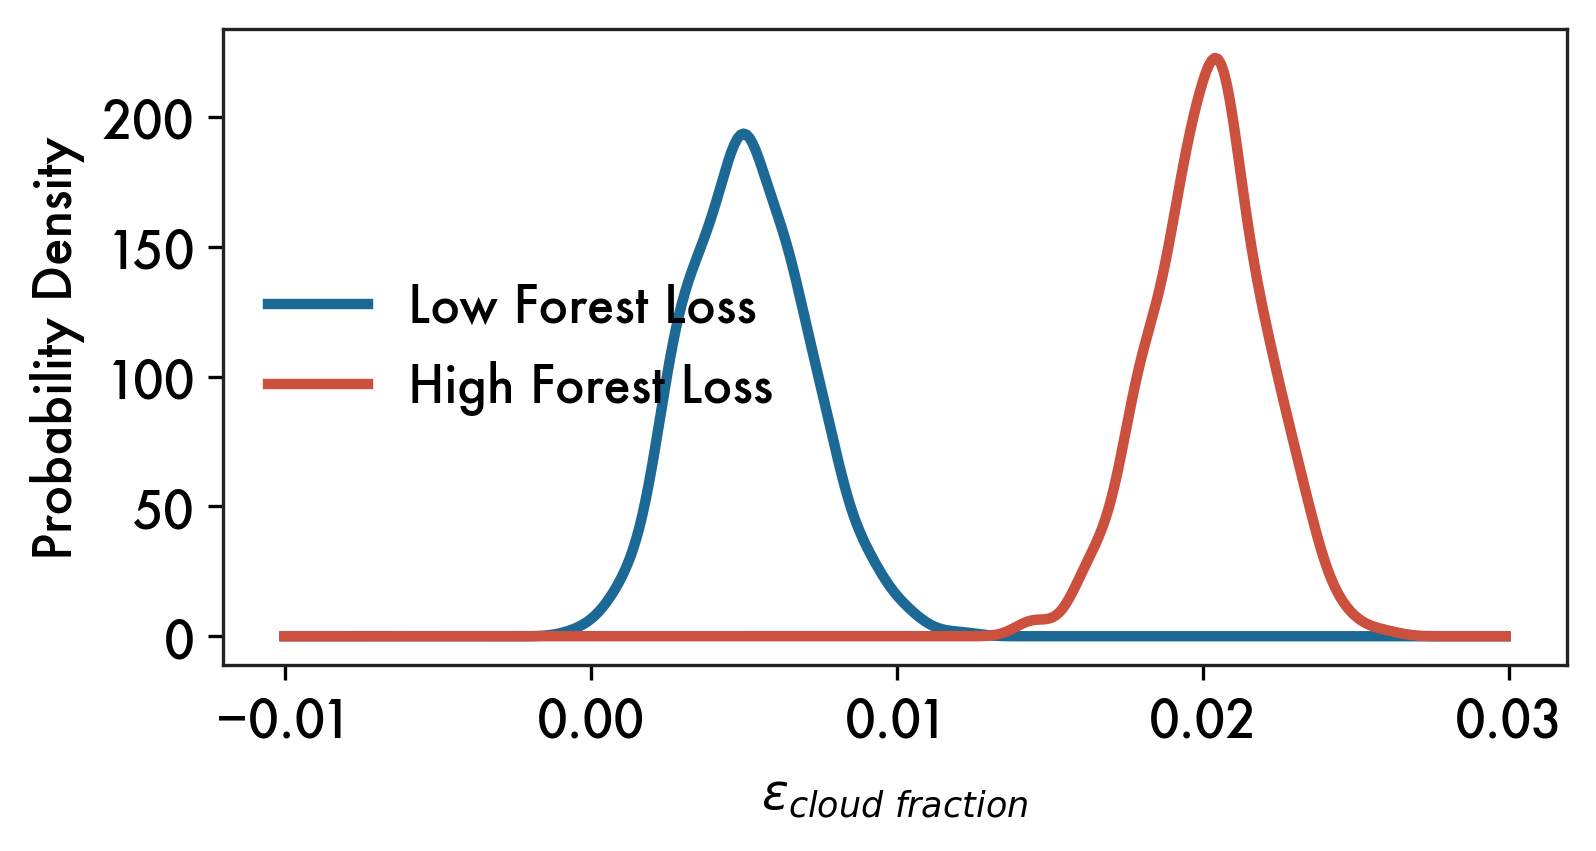

3


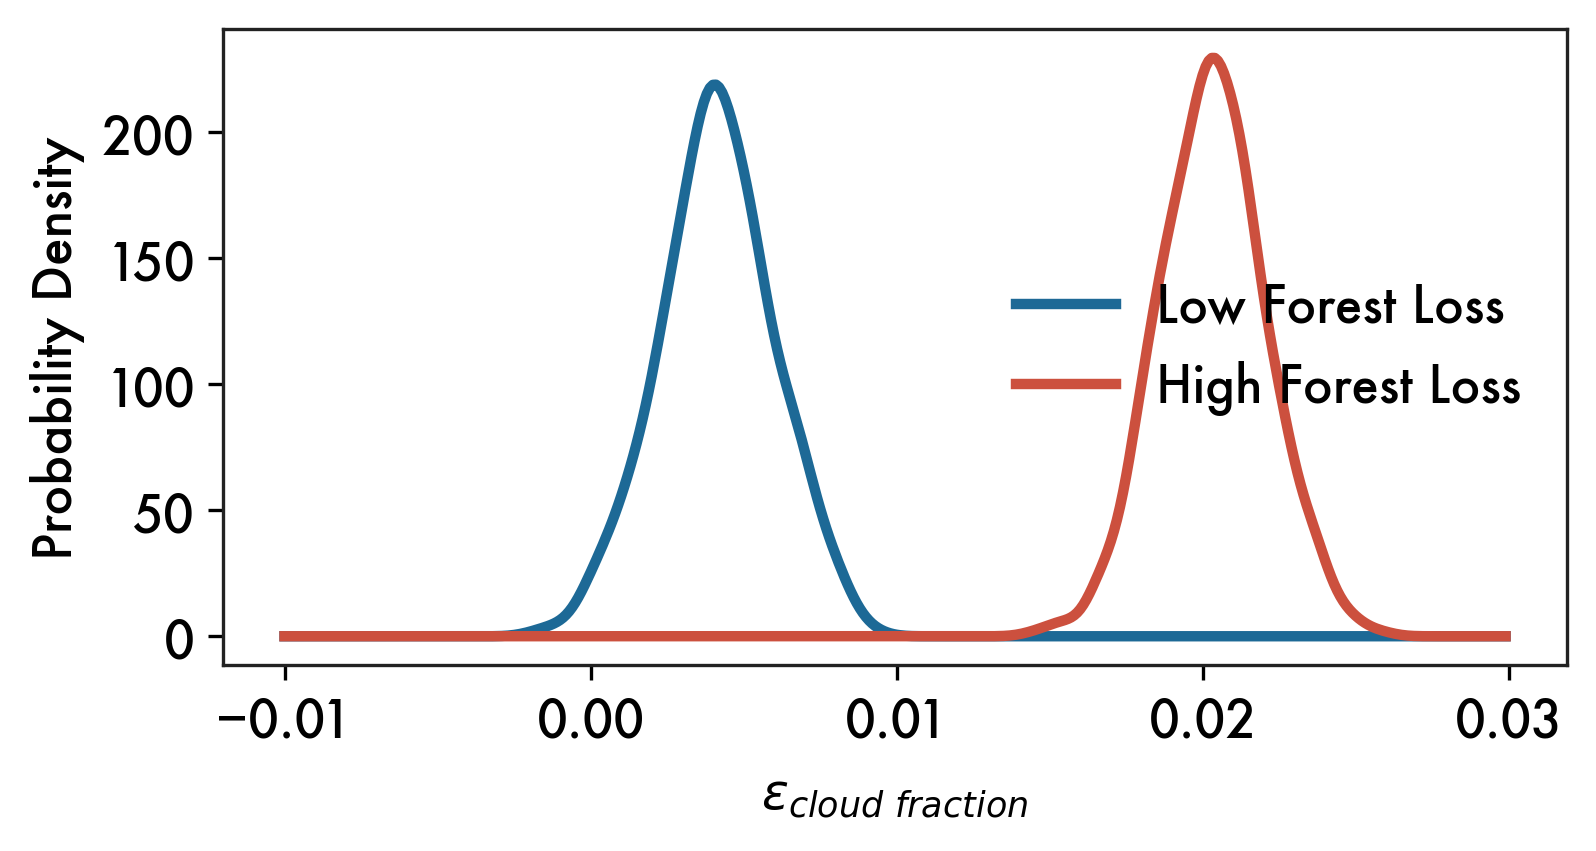

4


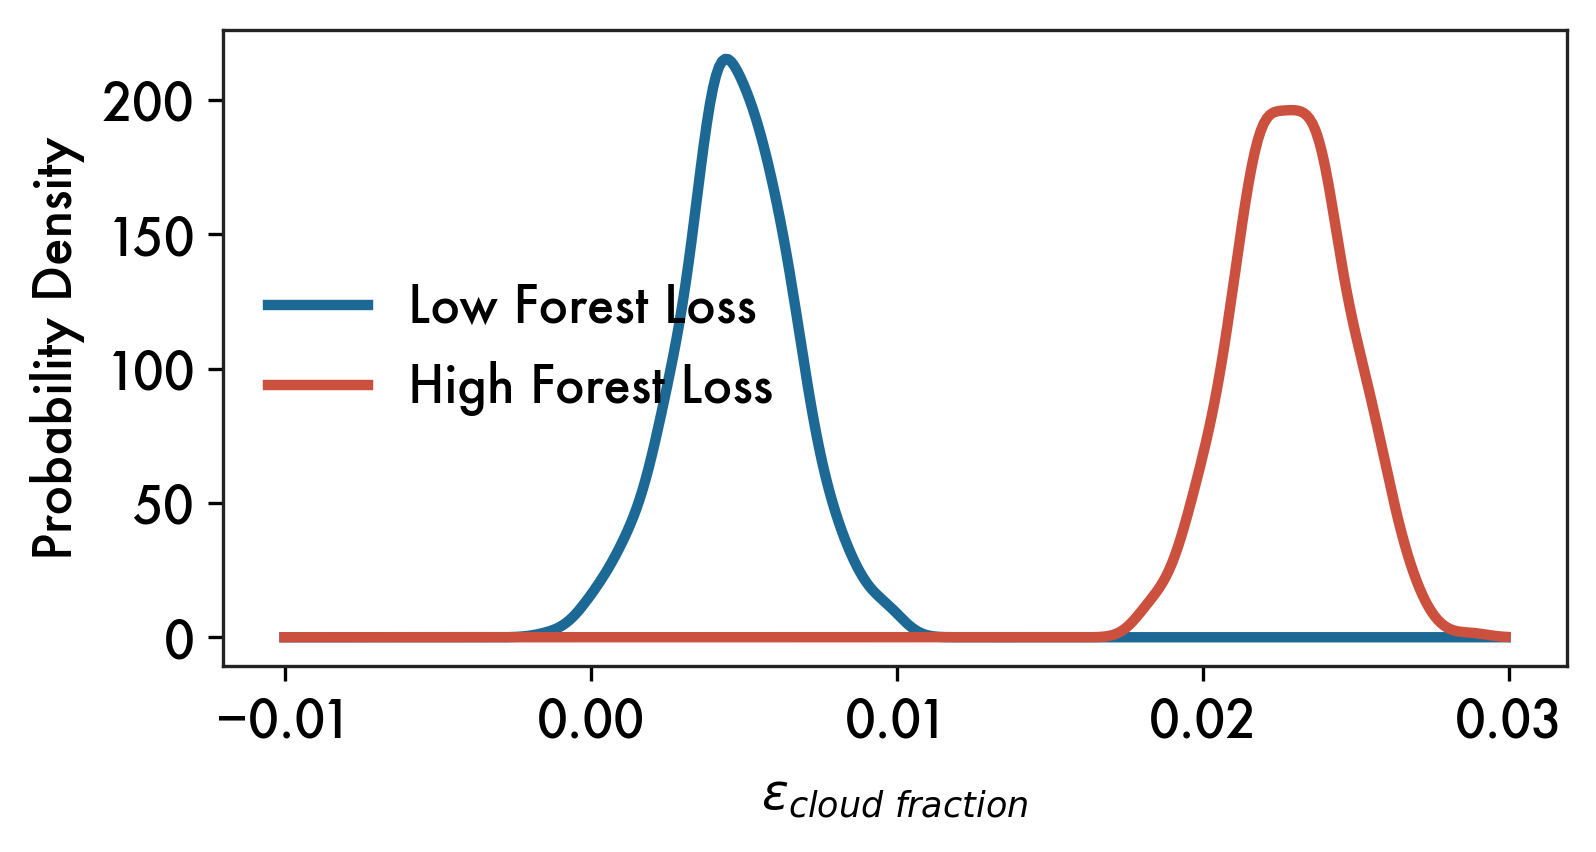

5


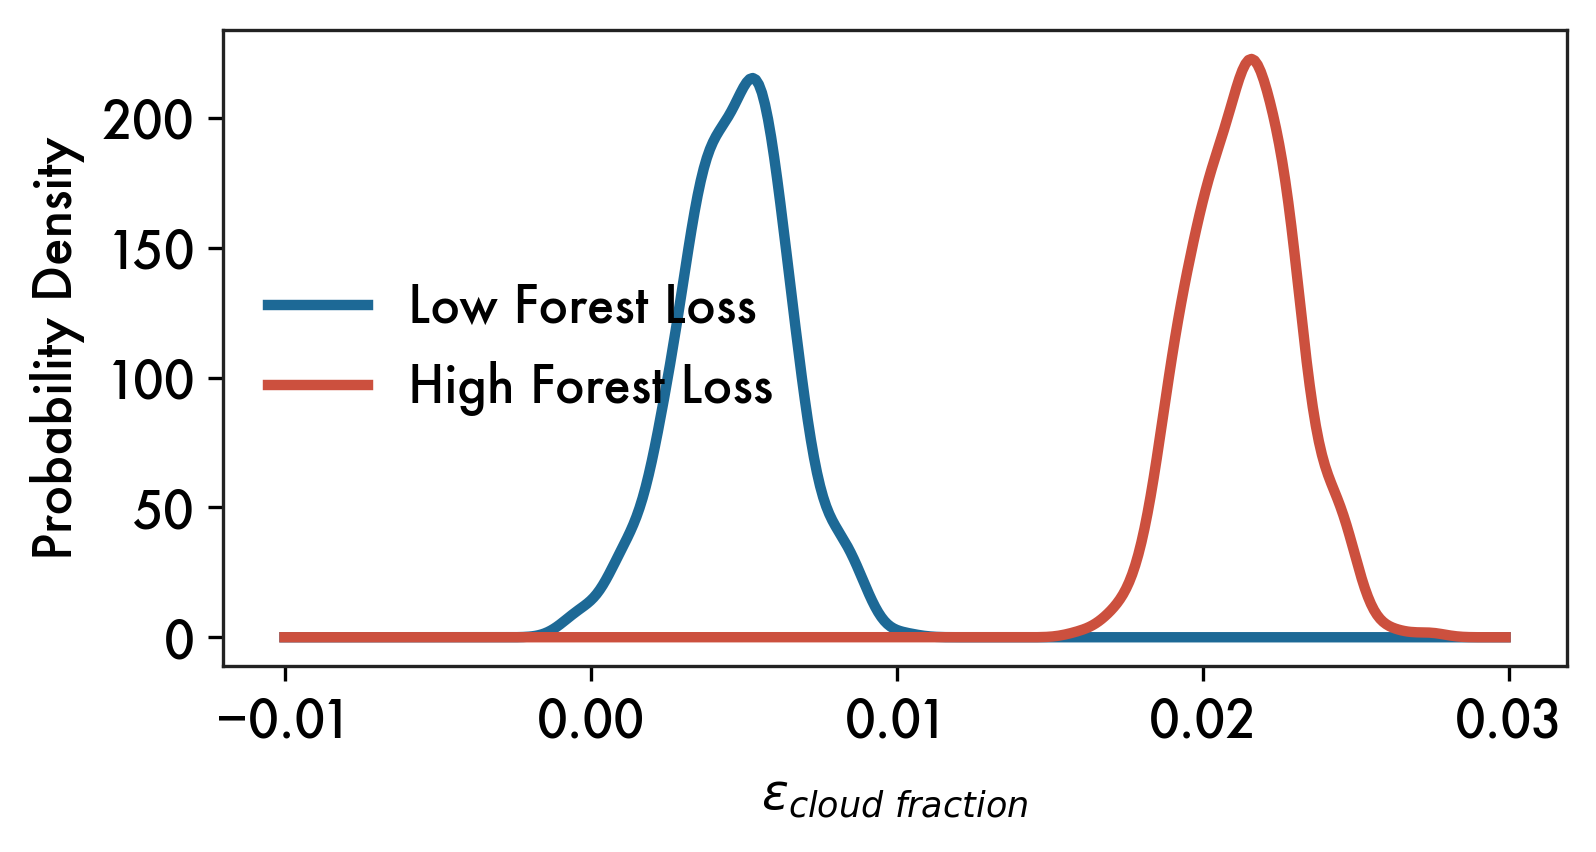

6


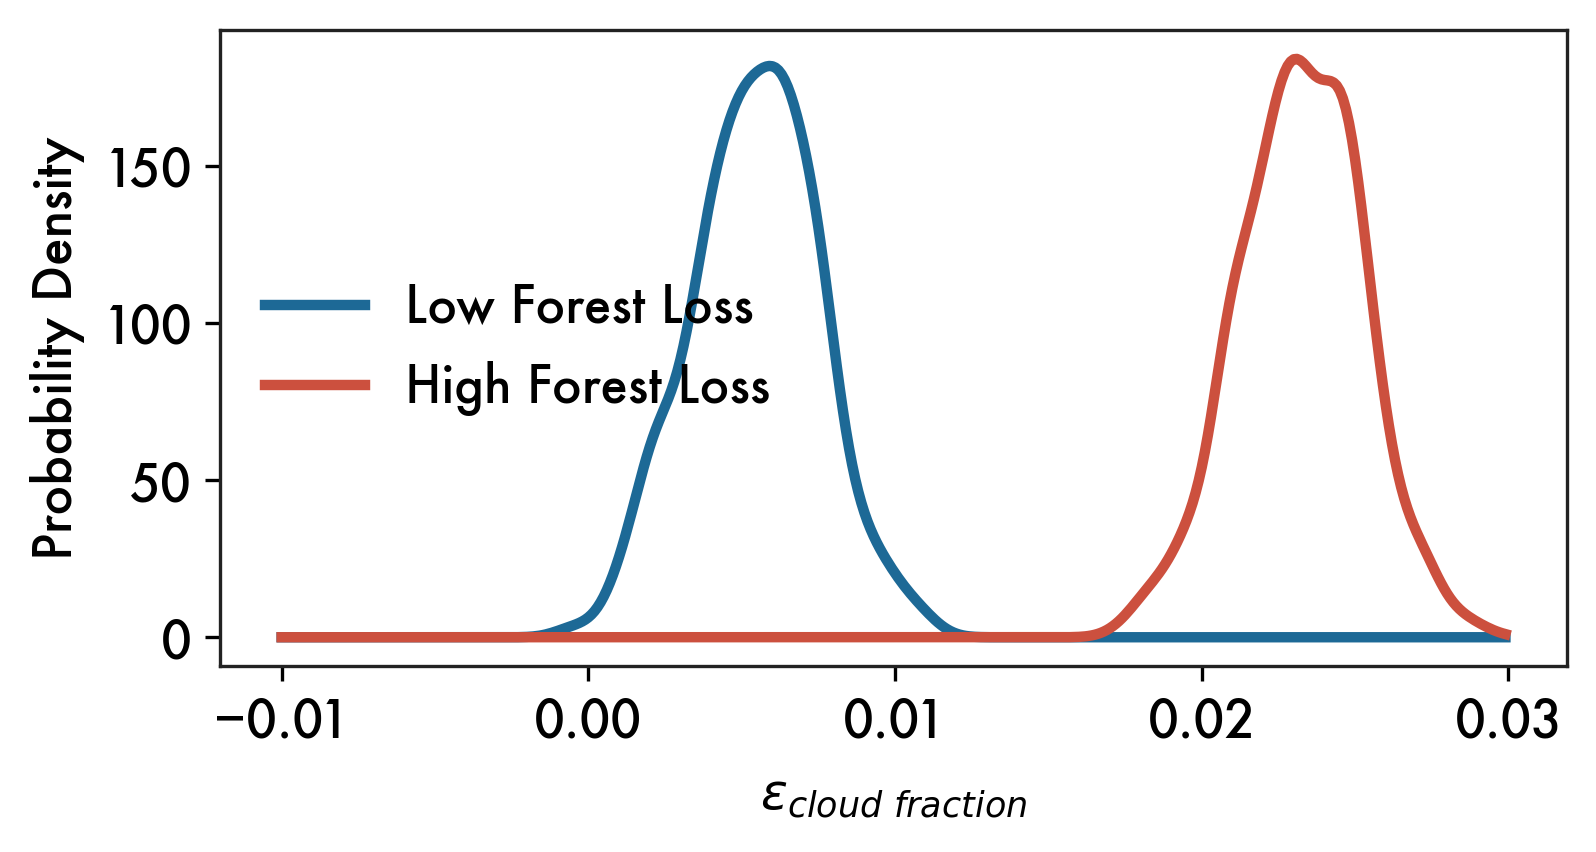

7


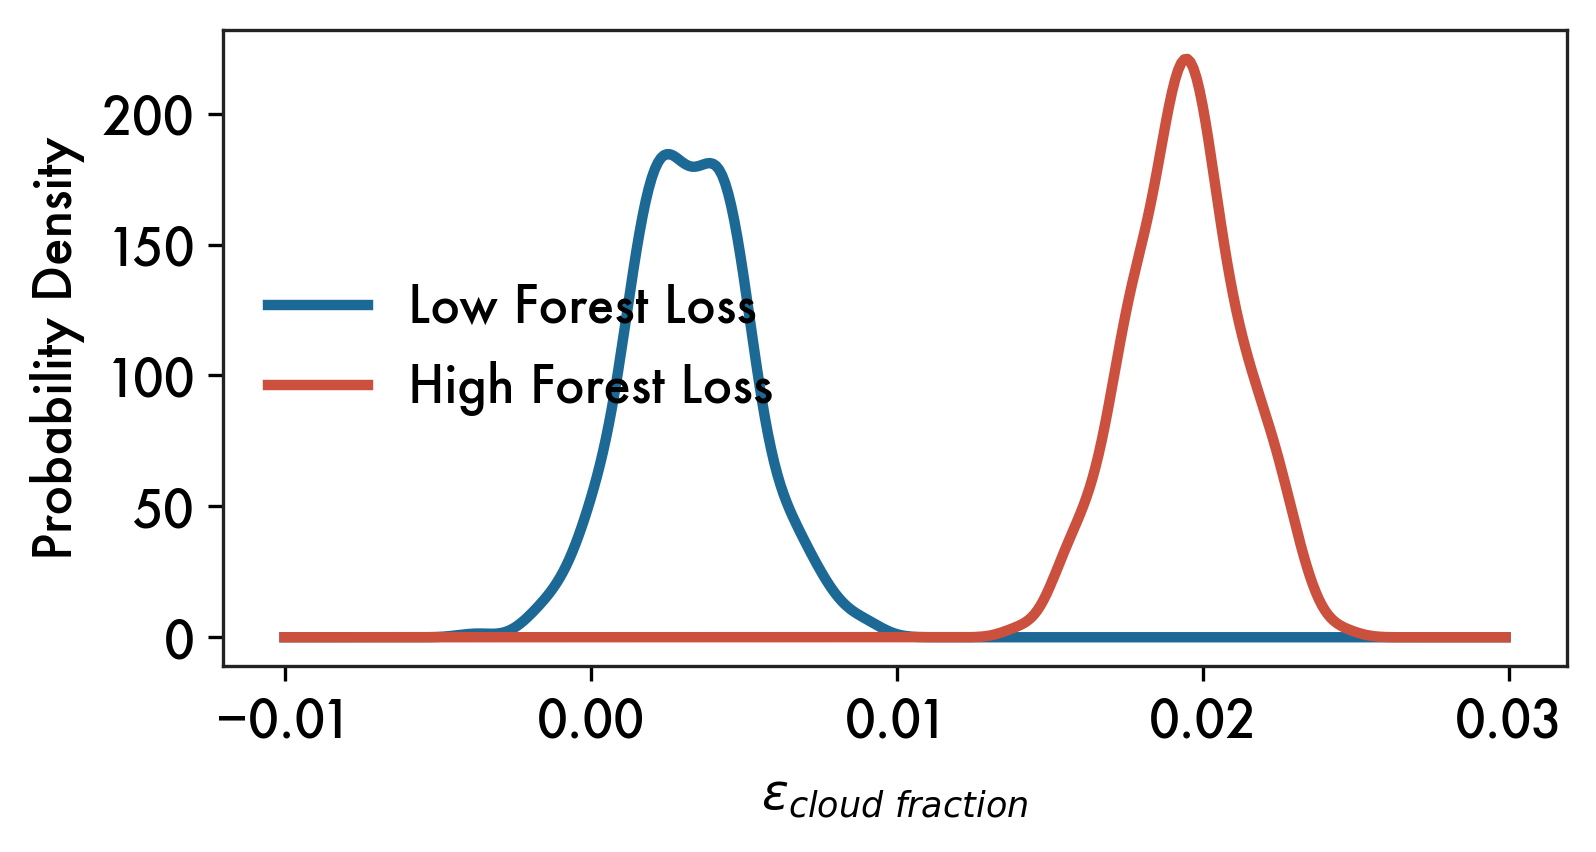

8


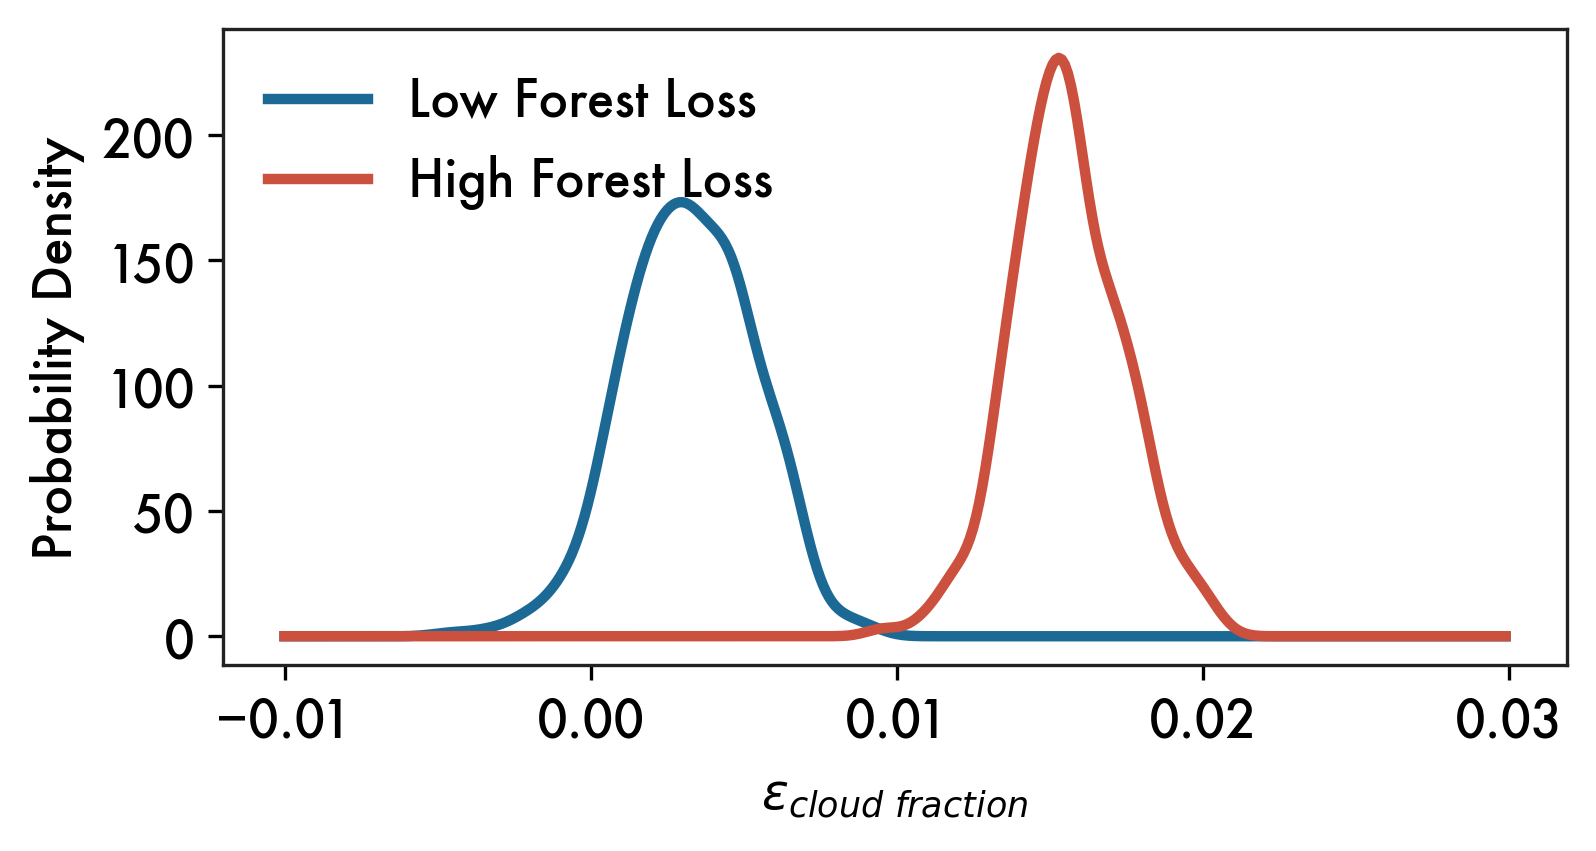

9


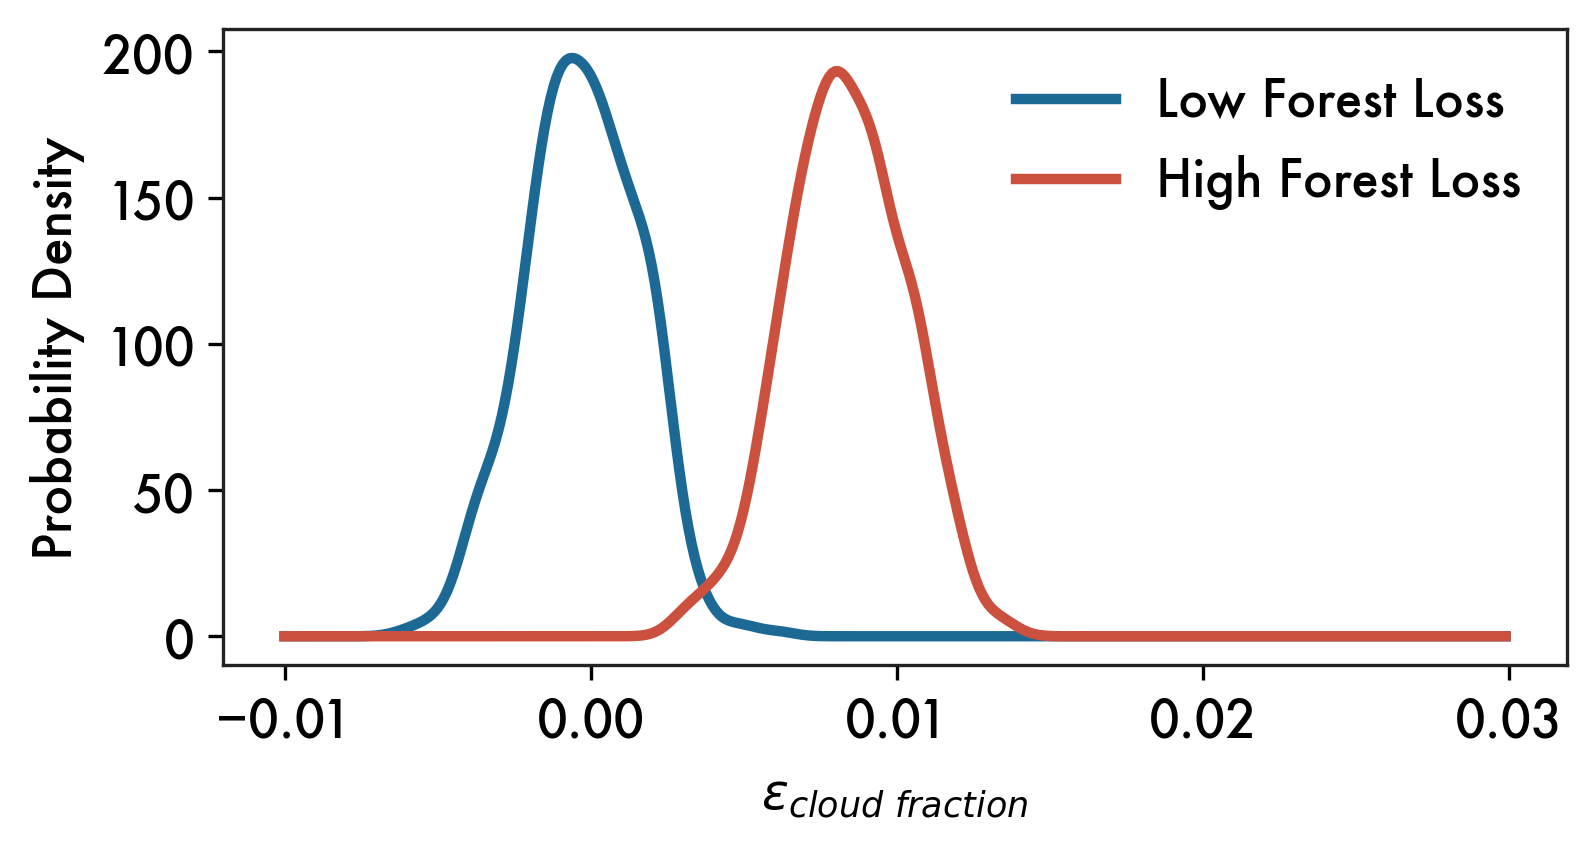

10


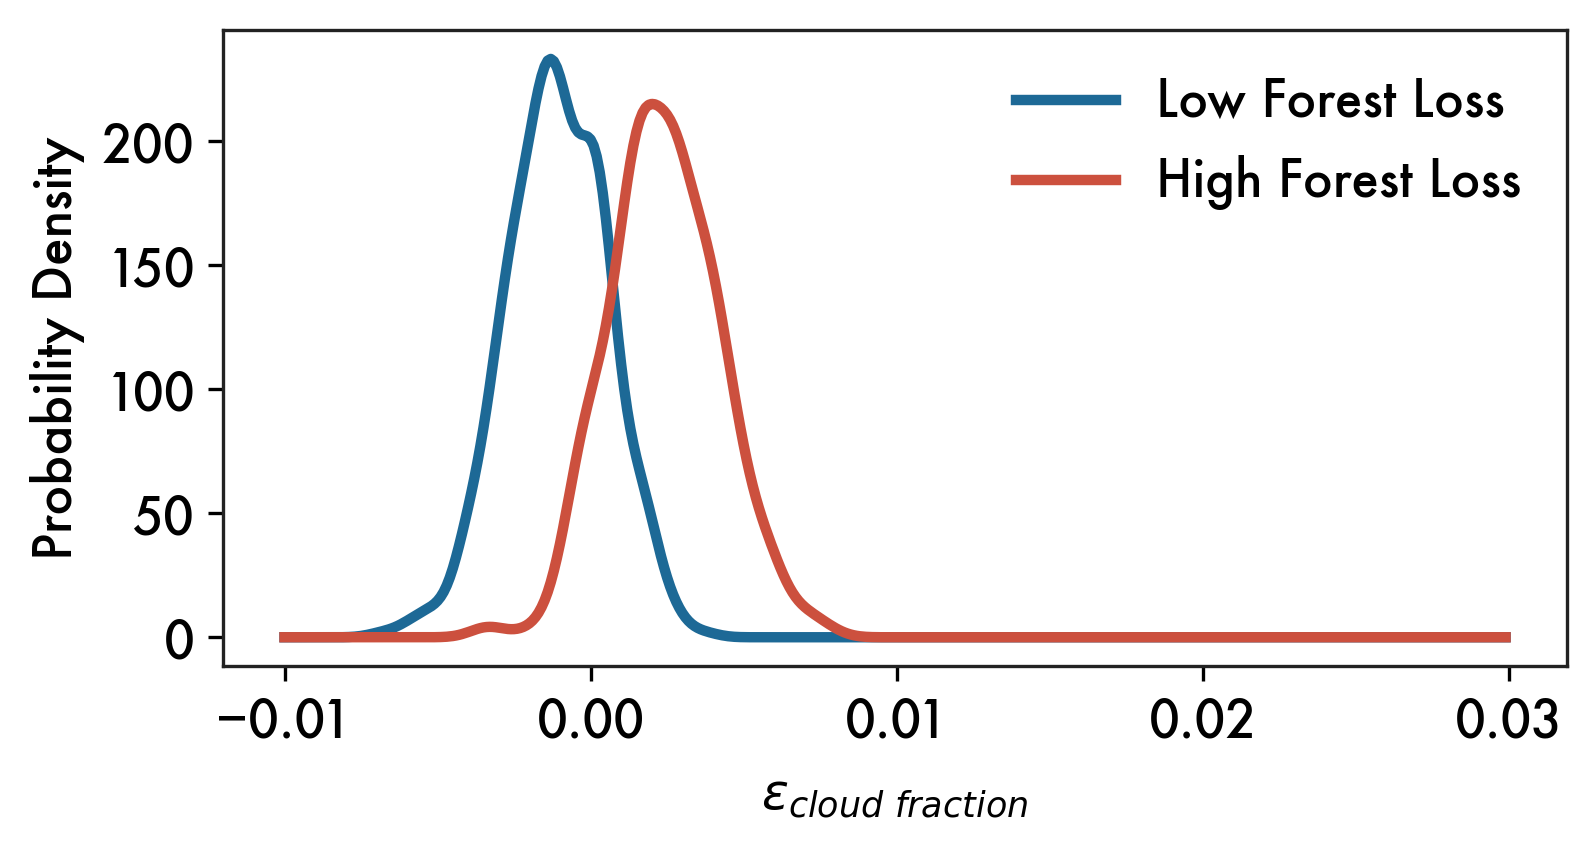

11


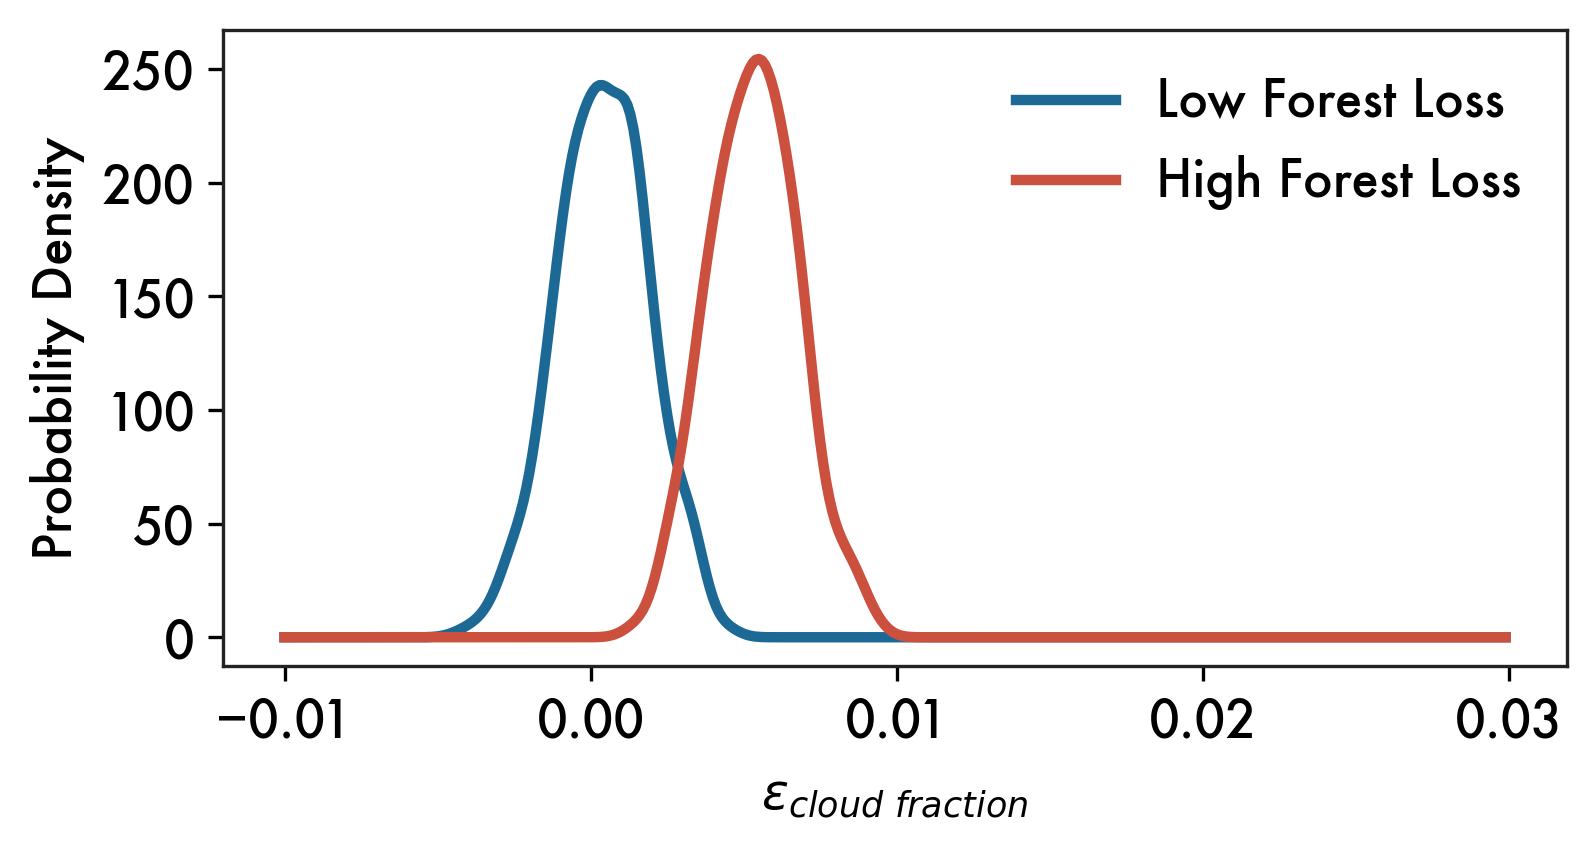

12


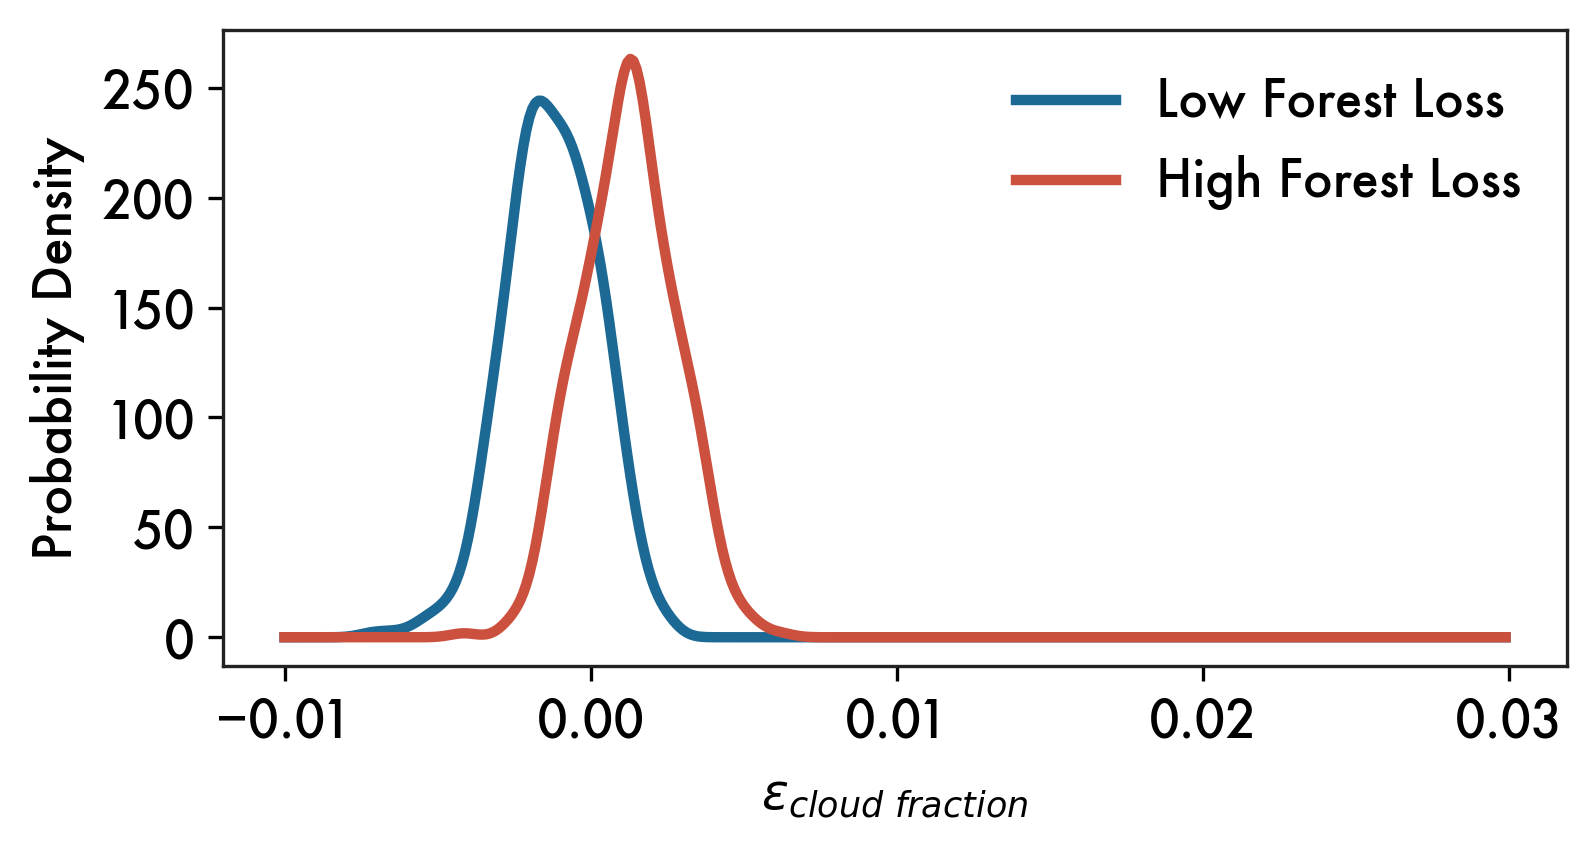

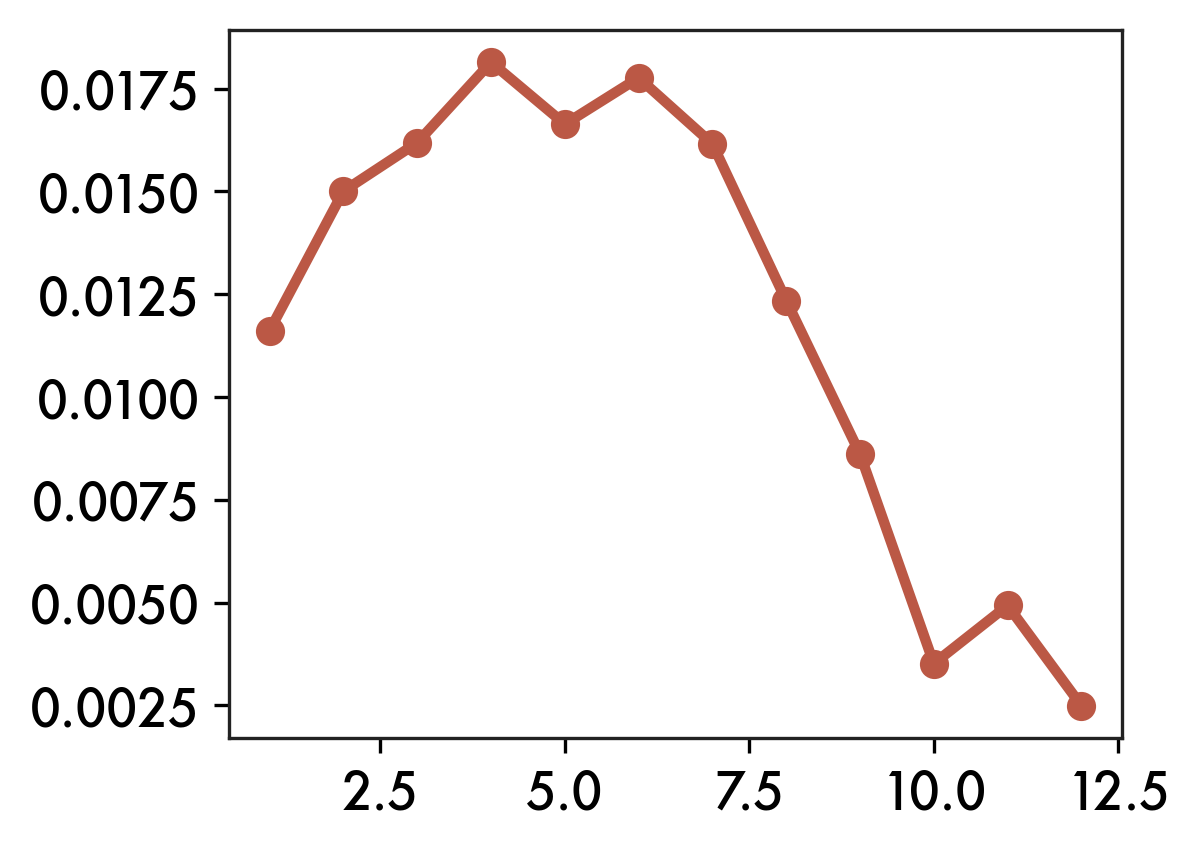

In [291]:
plot = []

for mo in range(1,13):
    print(mo)
    x = np.arange(-0.01,0.03,0.0001)

    #plt.hist(low_samps[1],color=blue)
    #plt.hist(high_samps[1],color=red)

    fig, ax = plt.subplots(1,1,figsize=(5.5,3))
    
    plot.append(np.mean([high_samps[i][mo] for i in range(len(high_samps))])-np.mean([low_samps[i][mo] for i in range(len(low_samps))]))

    kde = sts.gaussian_kde([low_samps[i][mo] for i in range(len(low_samps))])#low_samps)
    plt.plot(x,kde.pdf(x),color=blue, label = 'Low Forest Loss')
    kde = sts.gaussian_kde([high_samps[i][mo] for i in range(len(high_samps))])#high_samps)
    plt.plot(x,kde.pdf(x),color=red, label = 'High Forest Loss')

    ax.set_ylabel('Probability Density')
    ax.set_xlabel('$\epsilon_{cloud\ fraction}$')

    plt.legend()
    plt.savefig(f"{figPath}/bootstrapped-effect.png",dpi=300)
    plt.show()
    plt.close('all')
    
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(range(1,13),plot, marker='o')

plt.show()

# Identify Control and Deforested Pixels

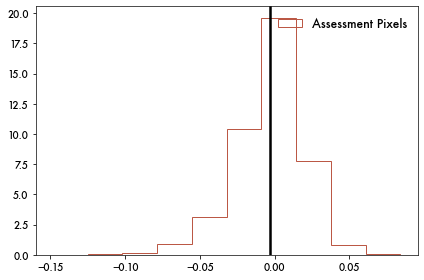

In [371]:
assess_thresh = 10

out = []
for pos in defo.index:
    assess = find_pixels_within_dist(pos,assess_thresh)
    out.extend([a for a in assess if a in sub.index])

assess = sub.loc[out]

plt.hist(assess.deltaCloud, histtype='step', density=1,
        label = 'Assessment Pixels')
plt.axvline(assess.deltaCloud.mean())

plt.legend()

In [330]:
def calc_distance(loc1,loc2):
    lat1, lon1 = loc1
    lat2, lon2 = loc2
    
    return(np.sqrt(((lat1-lat2)/res)**2+((lon1-lon2)/res)**2))

In [596]:
ctrl = sub[(sub.Forest_0>=0.9) & (sub.PriorLoss<=0.02)].copy()

In [594]:
def calc_dist_from_assessment(pos, x, res = 0.08):
    return(np.min(cdist(np.expand_dims(np.array(pos),axis=0), 
                                                  np.array(list(x.index))))/0.008)

calc_dist_from_assessment = np.vectorize(calc_dist_from_assessment,excluded=['x','res'])

In [606]:
def mean_property_in_range(sub,pos,prop,dist=10):
    temp = find_pixels_within_dist(pos,dist)

    return(sub.loc[[a for a in temp if a in sub.index],prop].mean())

mean_property_in_range = np.vectorize(mean_property_in_range, excluded=['sub','prop','dist'])

In [621]:
dist = 50

for pos in assess.index[:1]:
    
    temp = find_pixels_within_dist(pos,dist)
    temp_ctrl = ctrl.loc[[a for a in temp if a in ctrl.index]]

    temp_ctrl['PriorLoss_10km'] = mean_property_in_range(sub = sub,
                                                        pos = temp_ctrl.index,
                                                        prop = 'PriorLoss',
                                                        dist = 10)
    temp_ctrl[f'Loss{yr}_10km'] = mean_property_in_range(sub = sub,
                                                        pos = temp_ctrl.index,
                                                        prop = f'Loss_{yr}',
                                                        dist = 10)
    temp_ctrl = temp_ctrl[(temp_ctrl['PriorLoss_10km'] <= 0.02) &
                         (temp_ctrl[f'Loss{yr}_10km'] <= 0.02)]
    
    print(assess.loc[pos,'deltaCloud'], 
          temp_ctrl.mean().deltaCloud, 
          assess.loc[pos,'deltaCloud']-temp_ctrl.mean().deltaCloud)

-7.712  107.936   -0.065113
Name: deltaCloud, dtype: float64 -0.14345721338328724 -7.712  107.936    0.078345
Name: deltaCloud, dtype: float64


/tmp/ipykernel_21867/1375166329.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(assess.loc[pos,'deltaCloud'],
/tmp/ipykernel_21867/1375166329.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  assess.loc[pos,'deltaCloud']-temp_ctrl.mean().deltaCloud)


In [458]:
%lprun -f mean_property_in_range mean_property_in_range(sub,ctrl.index[0],'PriorLoss')

Timer unit: 1e-06 s

Total time: 0.020167 s
File: /tmp/ipykernel_21867/3801473608.py
Function: mean_property_in_range at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def mean_property_in_range(sub,pos,prop,dist=10):
     2         1       7534.0   7534.0     37.4      temp = find_pixels_within_dist(pos,dist)
     3                                           
     4         1      12633.0  12633.0     62.6      return(sub.loc[[a for a in temp if a in sub.index],prop].mean())

In [467]:
print(calc_distance(pos,assess.index[0]))

7.615773105863958


In [528]:
print(np.expand_dims(np.array(pos),axis=0).shape)
print(np.array(list(ctrl.index[:2])).shape)

print(pos)
print(ctrl.index[:2])

(1, 2)
(2, 2)
(-7.656, 107.912)
MultiIndex([(-0.328, 99.904),
            (-0.328, 99.912)],
           )


In [530]:
print(

10.837150917099944


In [462]:
print(ctrl.index)

MultiIndex([(-0.328,  99.904),
            (-0.328,  99.912),
            (-0.328,  99.928),
            ( -0.32,  99.912),
            ( -0.32,   99.92),
            ( -0.32,  99.928),
            (-0.312,  99.856),
            (-0.312,   99.88),
            (-0.312,  99.888),
            (-0.312,  99.912),
            ...
            (25.176, 113.712),
            (25.256, 113.784),
            ( 25.32, 113.664),
            (  25.4, 115.624),
            (25.536,  114.96),
            ( 25.56,   117.4),
            (  25.6, 118.616),
            (26.816, 115.872),
            (27.472,  117.44),
            ( 27.48,  117.44)],
           length=80711)


In [449]:
%%timeit

mean_property_in_range(sub,ctrl.index[0],'PriorLoss')

7.83 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [424]:
for pos_ in ctrl.index:
    temp = find_pixels_within_dist(pos_,10)
    temp = [a for a in temp if a in sub.index]
    temp = sub.loc[temp]
    ctrl.loc[pos_,'PriorLoss_10km'] = (temp[prior].sum(axis=1)).mean()
    
print(ctrl)

KeyboardInterrupt: 

In [ ]:
print

In [394]:
prior = [f"Loss_{yr}" for yr in range(1,yr+1)]

for pos in assess.index[100:110]:
    ctrl = find_pixels_within_dist(pos,25)
    ctrl = [a for a in ctrl if a in sub.index]
    
    ctrl = sub.loc[ctrl]

    ctrl = ctrl[ctrl.Forest_0>=0.9]
    print(ctrl)
    #ctrl = ctrl[(ctrl[prior]<0.1).all(axis=1) & (ctrl['Forest_0']>=0.9)]
    for pos_ in ctrl.index[:1]:
        print(pos_)
        temp = find_pixels_within_dist(pos_,10)
        temp = [a for a in temp if a in sub.index]
        
        temp = sub.loc[temp].mean()
    
        print(temp)
    '''for pos_ in ctrl.index:
        print(pos_)
        plt.scatter(pos_[1],pos_[0],color='black')
        temp = find_pixels_within_dist(pos_,10)
        temp = [a for a in temp if a in sub.index]
        
        print(sub.loc[temp,prior].max())'''
        
plt.show()

Empty DataFrame
Columns: [Forest_0, Forest_1, Forest_2, Forest_3, Loss_1, Loss_2, Cloud_1, Cloud_3, deltaCloud]
Index: []
Empty DataFrame
Columns: [Forest_0, Forest_1, Forest_2, Forest_3, Loss_1, Loss_2, Cloud_1, Cloud_3, deltaCloud]
Index: []
Empty DataFrame
Columns: [Forest_0, Forest_1, Forest_2, Forest_3, Loss_1, Loss_2, Cloud_1, Cloud_3, deltaCloud]
Index: []
Empty DataFrame
Columns: [Forest_0, Forest_1, Forest_2, Forest_3, Loss_1, Loss_2, Cloud_1, Cloud_3, deltaCloud]
Index: []
Empty DataFrame
Columns: [Forest_0, Forest_1, Forest_2, Forest_3, Loss_1, Loss_2, Cloud_1, Cloud_3, deltaCloud]
Index: []
Empty DataFrame
Columns: [Forest_0, Forest_1, Forest_2, Forest_3, Loss_1, Loss_2, Cloud_1, Cloud_3, deltaCloud]
Index: []
Empty DataFrame
Columns: [Forest_0, Forest_1, Forest_2, Forest_3, Loss_1, Loss_2, Cloud_1, Cloud_3, deltaCloud]
Index: []
Empty DataFrame
Columns: [Forest_0, Forest_1, Forest_2, Forest_3, Loss_1, Loss_2, Cloud_1, Cloud_3, deltaCloud]
Index: []
Empty DataFrame
Columns:

(array([  176.,   708.,  2416.,  5198.,  9475., 19878., 14382.,  5299.,
          772.,   182.]),
 array([-0.11821355, -0.10094051, -0.08366747, -0.06639444, -0.0491214 ,
        -0.03184836, -0.01457532,  0.00269771,  0.01997075,  0.03724379,
         0.05451683]),
 <BarContainer object of 10 artists>)

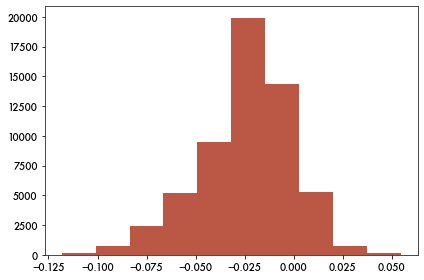

In [160]:


#control pixels are those which have intact forest (>90%)
#and prior deforestation was less than 10% per year
ctrl = alldata[(alldata[prior]<0.1).all(axis=1) & 
               (alldata["Forest_0"]>=0.9)]

# Read GFC data and identify forest loss pixels + control pixels

Procedure from Crompton et al. (2021):
1. Find pixels where forest loss occurred in year t.
2. Find deltaCloudCover between t+1 and t-1 for that pixel.
3. Find control pixels nearby (<25km away) where forest % is high and no forest loss (within 10km radius). 
4. Calculate deforestation effect: deltaCloudCover_deforested - deltaCloudCover_control

In [307]:
import itertools

latitudes = np.arange(-9.992,30.008,0.008)
longitudes = np.arange(90,140,0.008)

def find_assess_pixels(lat,lon,assess_thresh=10,res=0.008):
    latitudes = np.arange(lat-assess_thresh*res, lat+assess_thresh*res, res)
    latitudes = latitudes[(latitudes>=-9.992) & (latitudes<=30)]
    
    longitudes = np.arange(lon-assess_thresh*res,lon+assess_thresh*res, res)
    longitudes = longitudes[(longitudes>=90) & (longitudes<140)]
    
    assess_pixels = [(round(lat_,3), round(lon_,3)) for lat_, lon_ in itertools.product(latitudes,longitudes)
          if (((lat_-lat)**2 + (lon_-lon)**2) / 0.008) <= assess_thresh**2]
    
    return(assess_pixels)

In [305]:
forest = alldata[alldata.Forest_0>0]

In [299]:
alldata = alldata.set_index(['lat','lon'])

In [309]:
assess_thresh = 10 #10 km area

for lat,lon in defo.index[:1]:
    assess_pixels = find_control_pixels(lat,lon)

420


In [312]:
print(mod_pre.loc[assess_pixels[0:10]])

NameError: name 'mod_pre' is not defined

In [517]:
alldefo = pd.DataFrame()
allctrl = pd.DataFrame()

for yr in [2,3,4]:
    #deforested pixels are those where loss was above 50% 
    #in a given year
    defo = alldata[alldata[f"Loss_{yr}"]>=0.5]

    defo = defo[['lat','lon',
                f'Forest_{yr-1}',f'Forest_{yr+1}',
                f'Loss_{yr}']]
    defo['lat'] = defo.lat.round(2)
    defo['lon'] = defo.lon.round(2)
    defo = defo.set_index(['lat','lon'])

    prior = [f"Loss_{yr}" for yr in range(1,yr+1)]

    #control pixels are those which have intact forest (>90%)
    #and prior deforestatoin was less than 10% per year
    ctrl = alldata[(alldata[prior]<0.1).all(axis=1) & 
                   (alldata["Forest_0"]>=0.9)]

    ctrl = ctrl[['lat','lon',
                f'Forest_{yr-1}',f'Forest_{yr+1}',
                f'Loss_{yr}']]
    ctrl['lat'] = ctrl.lat.round(2)
    ctrl['lon'] = ctrl.lon.round(2)
    ctrl = ctrl.set_index(['lat','lon'])

    mod_pre = pd.read_pickle(f"{modisPath}annual/cloudcover_mean_20{str(yr-1).zfill(2)}.pkl")
    mod_post = pd.read_pickle(f"{modisPath}annual/cloudcover_mean_20{str(yr+1).zfill(2)}.pkl")

    defo[f'CC_{yr-1}'] = defo.index.map(mod_pre.stack())
    defo[f'CC_{yr+1}'] = defo.index.map(mod_post.stack())
    defo['Delta_CC'] = defo[f'CC_{yr+1}']-defo[f'CC_{yr-1}']

    ctrl[f'CC_{yr-1}'] = ctrl.index.map(mod_pre.stack())
    ctrl[f'CC_{yr+1}'] = ctrl.index.map(mod_post.stack())
    ctrl['Delta_CC'] = ctrl[f'CC_{yr+1}']-ctrl[f'CC_{yr-1}']
    
    alldefo = pd.concat([alldefo,defo])
    allctrl = pd.concat([allctrl,ctrl])

In [520]:
plot_c = (allctrl.groupby(0.1 * (allctrl[f"Loss_{yr}"]//0.1)).agg(['mean','std']))
plot_d = (alldefo.groupby(0.1 * (alldefo[f"Loss_{yr}"]//0.1)).agg(['mean','std']))

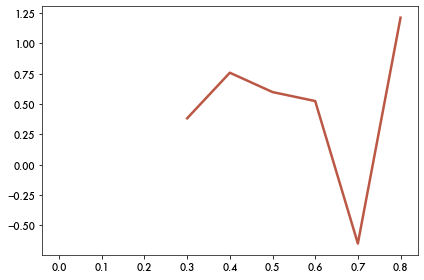

In [521]:
plt.plot(plot_d.index,plot_d.Delta_CC['mean'])
plt.plot(plot_c.index,plot_c.Delta_CC['mean'])

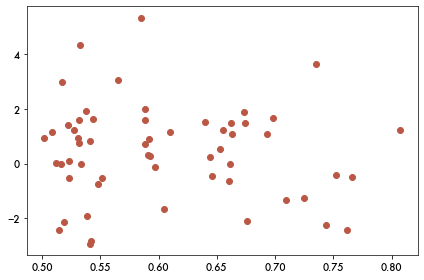

In [479]:
plt.scatter(defo[f"Loss_{yr}"],defo.Delta_CC)

In [186]:
res = 0.008

print(sorted(np.unique(res * ((alldata.lon)//res)))[:10])

[89.992, 90.0, 90.016, 90.024, 90.304, 90.312, 90.328, 90.336, 90.352, 90.36]


In [184]:
print(sorted(np.unique(alldata.lon))[:10])

[90.0, 90.008, 90.016, 90.032, 90.304, 90.312, 90.32, 90.328, 90.336, 90.344]


In [185]:
print(sorted(mod_pre.columns.values)[:10])

[90.0, 90.04, 90.08, 90.12, 90.16, 90.2, 90.24, 90.28, 90.32, 90.36]


In [182]:
print(alldata.lon)

0          99.120
1          99.232
2          99.232
3          99.160
4          99.168
           ...   
383113    120.488
383114    120.376
383115    120.440
383116    120.760
383117    120.792
Name: lon, Length: 383118, dtype: float64
